7/24/2019 This is going to be the notebook I'm going to use to calculate present my results. It's going to use the
MTurk-collected data and calculate all of the ngram overlap scores on it.

In [1]:
import sys
sys.path.append("..")

In [2]:
from monroe_data import MonroeData, MonroeDataEntry, Color # for loading in training data
from evaluation import delta_e_dist
import caption_featurizers # for tokenizing input to nltk bleu

In [3]:
import numpy as np
import pickle as pkl
from nlgeval import NLGEval
import matplotlib.pyplot as plt
%matplotlib inline

In [960]:
import importlib
import monroe_data
importlib.reload(monroe_data)
from monroe_data import MonroeData, MonroeDataEntry, Color 

In [14]:
# 0 set up mturk data (and any other data needed)
#mturk_data = MonroeData("../data/csv/mturk_augmented_data_pilot.csv", single_speaker=False)
#mturk_data_combined = MonroeData("../data/csv/mturk_augmented_data_exp12.csv", single_speaker=False)
dev_data = MonroeData("../data/csv/dev_corpus_monroe.csv", "../data/entries/dev_entries_monroe.pkl")
train_data = MonroeData("../data/csv/train_corpus_monroe.csv", "../data/entries/train_entries_monroe.pkl")

In [303]:
for i in mturk_data_combined.read_data():
    pass

In [304]:
mturk_data_combined.save_entries("../data/entries/dev_mturk_combined_entries.pkl")

In [ ]:
# 1. put contexts into form [[references]], [good candidates], [bad candidates], [ugly candidates]

# good candidates can come from dev data (this is a whole thing... but shouldn't be too bad, I just need
# to get the indices from the other notebook)

# for now, let's say that everything in the augmented data are good references

In [5]:
def extract_context_lists(mturk_data, num_reps=5):
    contexts_good_unflipped = []
    contexts_bad_unflipped = []
    contexts_good_flipped = []
    contexts_bad_flipped = []

    num_reps = 5
    num_same_condition = num_reps * 2 # good and bad utterance for each rep

    for i in range(len(mturk_data) // num_same_condition): # number of distinct contexts
        # i * 2 because data alternates between flipped and unflipped
        good_unflipped_start = i * 2 * num_same_condition  # good utterances at even indices
        bad_unflipped_start = good_unflipped_start + 1     # bad utterances at odd indices
        unflipped_end = good_unflipped_start + num_same_condition

        contexts_good_unflipped.extend(
            mturk_data[good_unflipped_start : unflipped_end: 2]
        )
        contexts_bad_unflipped.extend(
            mturk_data[bad_unflipped_start : unflipped_end : 2]
        )

        good_flipped_start = unflipped_end # the flipped target data comes right after the unflipped data
        bad_flipped_start = good_flipped_start + 1
        flipped_end = good_flipped_start + num_same_condition

        contexts_good_flipped.extend(
            mturk_data[good_flipped_start : flipped_end : 2]
        )
        contexts_bad_flipped.extend(
            mturk_data[bad_flipped_start : flipped_end : 2]
        )
        
    return (contexts_good_unflipped, contexts_bad_unflippedcontexts_bad_unflipped, 
            contexts_good_flipped, contexts_bad_flipped)

In [305]:
ctx_good_unflipped_comb, ctx_bad_unflipped_comb, ctx_good_flipped_comb, ctx_bad_flipped_comb = (
    extract_context_lists(mturk_data_combined)
)

In [308]:
len(ctx_good_unflipped_comb)*4

1800

In [6]:
def normalize(caption):
    """Makes captin text more uniform - lowercases, removes unecessary white space"""
    return caption.lower().strip()

In [7]:
def extract_captions(context_list):
    """Extracts the captions from the contexts in context_list and does some caption normalization"""
    return [normalize(c.caption) for c in context_list]

In [8]:
def extract_as_reference_captions(context_list, num_reps=5):
    """Extracts captions from contexts in context_list and format them as list of lists req'd for evaluation"""
    captions = extract_captions(context_list)
    captions = np.array(captions).reshape(-1, num_reps)
    # now, we have num_reps good and num_reps ugly captions for each set of reference captions
    captions = np.repeat(captions, num_reps, axis=0)
    captions = captions.tolist() # nlgeval needs lists
    return captions

In [309]:
ref_captions_unflipped_comb = extract_as_reference_captions(ctx_good_unflipped_comb)
bad_captions_unflipped_comb = extract_captions(ctx_bad_unflipped_comb)
ugly_captions_unflipped_comb = extract_captions(ctx_good_flipped_comb)

In [274]:
# now we can do the same for the flipped ones:
ref_captions_flipped = extract_as_reference_captions(contexts_good_flipped)
bad_captions_flipped = extract_captions(contexts_bad_flipped)
ugly_captions_flipped = extract_captions(contexts_good_unflipped)


In [96]:
# now, we just have to load in the dev data that has the other captions we can use as our "good" captions

In [35]:
# we also need the relevant indices:

with open("../data/metric_comparison_indices/all_augmented_dev_indices", "rb") as pfile:
    dev_data_indices = pkl.load(pfile)

In [283]:
good_captions_unflipped = np.repeat(np.array(good_captions_unflipped), num_reps)

In [36]:
def get_good_candidates(start_ind, end_ind, num_reps=5):
    """Extract the candidates for good refering expressions from dev data"""
    contexts_dev = [dev_data[i] for i in dev_data_indices[start_ind : end_ind]]
    dev_data_captions = [dev_data[i].caption for i in dev_data_indices]
    candidates = dev_data_captions[start_ind : end_ind]
    return candidates, contexts_dev

In [314]:
good_captions_unflipped, contexts_dev = get_good_candidates(0, len(mturk_data_combined) // (2 * 2 * num_reps))

In [39]:
# ok, now let's do some ~evaluation~
# I'm going to not use word vector overlap metrics for right now
nlgeval_metric = NLGEval(no_overlap=False, no_glove=True, no_skipthoughts=True)  # loads the models

In [40]:
# let's try running all of the metrics at the same time
def get_overlap_scores(refs, hyps):
    refs = {idx: lines for (idx, lines) in enumerate(refs)}
    hyps = {idx: [line] for (idx, line) in enumerate(hyps)}
    ret_scores = {}
    for scorer, method in nlgeval_metric.scorers:
        score, scores = scorer.compute_score(refs, hyps)
        if isinstance(method, list):
            for sc, scs, m in zip(score, scores, method):
                ret_scores[m] = (sc, scs)
        else:
            ret_scores[method] = (score, scores)
    return ret_scores

In [284]:
good_unflipped_metrics = get_overlap_scores(ref_captions_unflipped, good_captions_unflipped)
bad_unflipped_metrics = get_overlap_scores(ref_captions_unflipped, bad_captions_unflipped)
ugly_unflipped_metrics = get_overlap_scores(ref_captions_unflipped, ugly_captions_unflipped)

In [120]:
good_unflipped_metrics

{'Bleu_1': (0.07344632768351209,
  [4.999999995000003e-16,
   4.999999995000003e-16,
   4.999999995000003e-16,
   4.999999995000003e-16,
   1.2499999998437502e-16,
   1.2499999998437502e-16,
   1.2499999998437502e-16,
   1.2499999998437502e-16,
   0.49999999950000074,
   0.49999999950000074,
   0.49999999950000074,
   0.49999999950000074,
   0.2857142856734695,
   0.2857142856734695,
   0.2857142856734695,
   0.2857142856734695,
   0.49999999950000074,
   0.49999999950000074,
   0.49999999950000074,
   0.49999999950000074,
   9.99999998000001e-16,
   9.99999998000001e-16,
   9.99999998000001e-16,
   9.99999998000001e-16,
   4.347826086767486e-17,
   4.347826086767486e-17,
   4.347826086767486e-17,
   4.347826086767486e-17,
   4.999999995000003e-16,
   4.999999995000003e-16,
   4.999999995000003e-16,
   4.999999995000003e-16,
   0.9999999990000008,
   0.9999999990000008,
   0.9999999990000008,
   0.9999999990000008,
   3.3333333322222225e-16,
   3.3333333322222225e-16,
   3.333333332222

In [11]:
from scipy.stats import pearsonr, spearmanr, kendalltau

In [12]:
def plot_score_dists(scores, metric):
    #plot_data = plot_score_dists(rating_data, metric, overlap_scores)
    plot_data = [score[metric][1] for score in scores]
    
    # let's also get the pearson correlation coefficient
    # domain is [1, 1, 1, ...], [2, 2, 2, ...], [3, 3, 3, 3, ...]
    # we could do fancy things with np.flatten(), but that doesn't work for lists with varying dimensions
    correlation_support = []
    for i, d in enumerate(plot_data):
        correlation_support.extend([i+1] * len(d))
        
    plot_data_flat = []
    for d in plot_data:
        plot_data_flat.extend(d)
        
#     print()
    print(pearsonr(correlation_support, plot_data_flat))
    print(spearmanr(correlation_support, plot_data_flat))
    print(kendalltau(correlation_support, plot_data_flat))
    
    plt.violinplot(plot_data, showmeans=True)
    plt.xticks([1, 2, 3], ["Descriptive", "Ambiguous", "Misleading"])
    # mean_cis = [mean_confidence_interval(data) for data in plot_data
    # means, cis = zip(*mean_cis)
    # plt.errorbar(range(1, 6), means, yerr=cis, capsize=9, color="white",
    #              markeredgecolor="orange", ecolor="orange", zorder=-1,
    #              elinewidth=5, capthick=1, barsabove=True)
    plt.title("{} scores of captions".format(metric))
    plt.show()

(-0.03845046757340221, 0.29296384577971624)


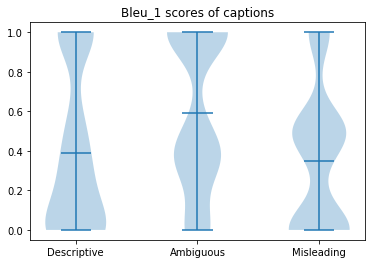

(-0.07368615581402176, 0.04365841254158574)


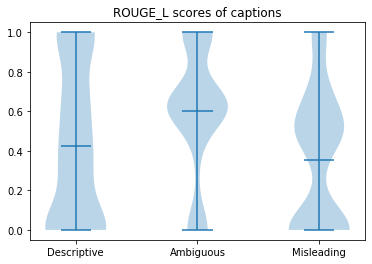

(-0.15630059261322005, 1.7096638561066278e-05)


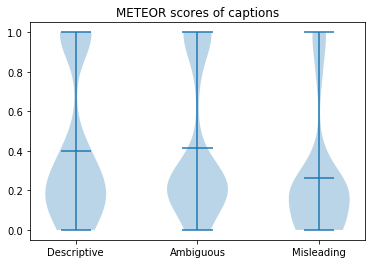

(-0.07967331263901486, 0.029126263030669428)


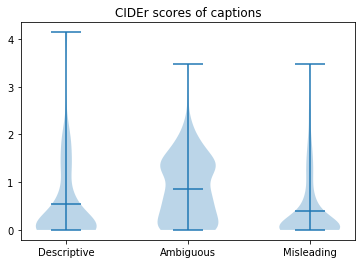

In [424]:
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr']
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics, bad_unflipped_metrics, ugly_unflipped_metrics], metric)

In [16]:
# I'm curious about how well the literal listener performs on this data, so I'm going to add it in:
# first, necesessary imports:
import color_featurizers
from models import LiteralListener, CaptionEncoder
from experiment import FeatureHandler

caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)
color_phi = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "rgb", normalized=True) # NOTE: RGB

feature_handler_dev = FeatureHandler(train_data, dev_data, caption_phi, color_phi, randomized_colors=True)

In [17]:
model = LiteralListener(CaptionEncoder)
model.init_model(
            embed_dim=100,
            hidden_dim=100,
            vocab_size=feature_handler_dev.caption_featurizer.caption_indexer.size,
            color_dim=54)

In [18]:
model.load_model("../model/literal_listener_5epoch_endings_tkn.params")

In [19]:
good_features_unflipped_X = feature_handler_dev.test_features()
good_targets_unflipped_y = feature_handler_dev.test_targets()

In [245]:
good_unflipped_preds = model.predict(good_features_unflipped_X)

In [246]:
good_unflipped_preds = good_unflipped_preds[:50]

In [247]:
good_unflipped_listener_score = good_unflipped_preds[np.arange(50), good_targets_unflipped_y[:50]]

In [160]:
# ok, now let's do the same for the bad and ugly

In [248]:
feature_handler_bad_unflipped = FeatureHandler(train_data, contexts_bad_unflipped,
                                               caption_phi, color_phi, randomized_colors=True)
bad_features_unflipped_X = feature_handler_bad_unflipped.test_features()
bad_targets_unflipped_y = feature_handler_bad_unflipped.test_targets()

bad_unflipped_preds = model.predict(bad_features_unflipped_X)
bad_unflipped_listener_score = bad_unflipped_preds[np.arange(len(bad_unflipped_preds)), bad_targets_unflipped_y]

In [20]:
import copy

In [249]:
# have to swap the colors for the case where the targets are different! (when evaluating the "misleading" caption)
contexts_ugly_unflipped = copy.deepcopy(contexts_good_flipped)
for i, context in enumerate(contexts_good_unflipped):
    contexts_ugly_unflipped[i].colors = context.colors

In [256]:
feature_handler_ugly_unflipped = FeatureHandler(train_data, contexts_ugly_unflipped,
                                               caption_phi, color_phi, randomized_colors=True)
ugly_features_unflipped_X = feature_handler_ugly_unflipped.test_features()
ugly_targets_unflipped_y = feature_handler_ugly_unflipped.test_targets()

ugly_unflipped_preds = model.predict(ugly_features_unflipped_X)
ugly_unflipped_listener_score = ugly_unflipped_preds[np.arange(len(ugly_unflipped_preds)), ugly_targets_unflipped_y]

In [287]:
# add to metrics
good_unflipped_metrics['Listener'] = (
    np.mean(np.exp(good_unflipped_listener_score)), np.exp(good_unflipped_listener_score)
)

bad_unflipped_metrics['Listener'] = (
    np.mean(np.exp(bad_unflipped_listener_score)), np.exp(bad_unflipped_listener_score)
)

ugly_unflipped_metrics['Listener'] = (
    np.mean(np.exp(ugly_unflipped_listener_score)), np.exp(ugly_unflipped_listener_score)
)

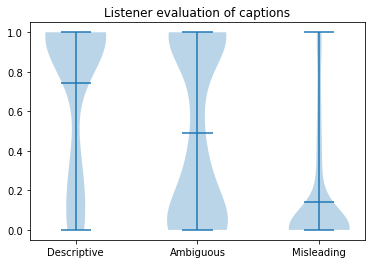

In [288]:
plot_score_dists([good_unflipped_metrics, bad_unflipped_metrics, ugly_unflipped_metrics], "Listener")

In [259]:
feature_handler_reference_unflipped = FeatureHandler(train_data, contexts_good_unflipped,
                                               caption_phi, color_phi, randomized_colors=True)
reference_features_unflipped_X = feature_handler_reference_unflipped.test_features()
reference_targets_unflipped_y = feature_handler_reference_unflipped.test_targets()

reference_unflipped_preds = model.predict(reference_features_unflipped_X)
reference_unflipped_listener_score = reference_unflipped_preds[np.arange(len(reference_unflipped_preds)), reference_targets_unflipped_y]

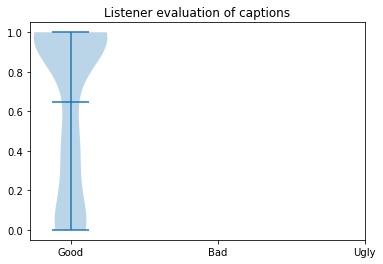

In [260]:
# This seems to inidcate that the model is able to perform well using the reference sentences, even though word
# overlaps screw up
plot_score_dists([{"Listener": (0,np.exp(reference_unflipped_listener_score))}], "Listener")

In [317]:
len(ref_captions_unflipped_comb)

450

In [318]:
len(good_captions_unflipped_comb)

90

In [320]:
# ok, now let's try things with the combined data
num_reps=5

In [328]:
good_captions_unflipped_comb, contexts_dev_comb = get_good_candidates(0, len(mturk_data_combined) // (2 * 2 * num_reps))
good_captions_unflipped_comb = np.repeat(good_captions_unflipped_comb, num_reps).tolist()

In [323]:
good_unflipped_metrics_comb = get_overlap_scores(ref_captions_unflipped_comb, good_captions_unflipped_comb)
bad_unflipped_metrics_comb = get_overlap_scores(ref_captions_unflipped_comb, bad_captions_unflipped_comb)
ugly_unflipped_metrics_comb = get_overlap_scores(ref_captions_unflipped_comb, ugly_captions_unflipped_comb)

In [ ]:
# now let's use the literal listener

In [21]:
def listener_assessment(eval_contexts):
    # assumes everything else is loaded up and ready...
    feature_handler = FeatureHandler(train_data, eval_contexts,
                                     caption_phi, color_phi, randomized_colors=True)
    X_assess = feature_handler.test_features()
    y_assess = feature_handler.test_targets()

    preds = model.predict(X_assess)
    scores = preds[np.arange(len(preds)), y_assess]
    return scores

In [331]:
good_unflipped_scores_comb = listener_assessment(contexts_dev_comb)
bad_unflipped_scores_comb = listener_assessment(ctx_bad_unflipped_comb)

# switch the colors in the ugly context
ctx_ugly_unflipped_comb = copy.deepcopy(ctx_good_flipped_comb)
for i, context in enumerate(ctx_good_unflipped_comb):
    ctx_ugly_unflipped_comb[i].colors = context.colors
    
ugly_unflipped_scores_comb = listener_assessment(ctx_ugly_unflipped_comb)

In [22]:
# add to metrics
def add_score_to_metric(scores, metric_dict, name="Listener"):
    metric_dict[name] = (np.mean(np.exp(scores)), np.exp(scores))
    
add_score_to_metric(good_unflipped_scores_comb, good_unflipped_metrics_comb)
add_score_to_metric(bad_unflipped_scores_comb, bad_unflipped_metrics_comb)
add_score_to_metric(ugly_unflipped_scores_comb, ugly_unflipped_metrics_comb)
# good_unflipped_metrics['Listener'] = (
#     np.mean(np.exp(good_unflipped_listener_score)), np.exp(good_unflipped_listener_score)
# )

# bad_unflipped_metrics['Listener'] = (
#     np.mean(np.exp(bad_unflipped_listener_score)), np.exp(bad_unflipped_listener_score)
# )

# ugly_unflipped_metrics['Listener'] = (
#     np.mean(np.exp(ugly_unflipped_listener_score)), np.exp(ugly_unflipped_listener_score)
# )

NameError: name 'good_unflipped_scores_comb' is not defined

In [ ]:
np.empty(len(good_unflipped_metrics_comb['Bleu_1'], 4))
good_unflipped_metrics_comb['Bleu_1']
good_unflipped_metrics_comb['Bleu_2']
good_unflipped_metrics_comb['Bleu_3']
good_unflipped_metrics_comb['Bleu_4']

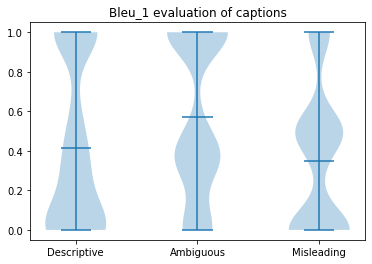

In [342]:
plot_score_dists([good_unflipped_metrics_comb, bad_unflipped_metrics_comb, ugly_unflipped_metrics_comb], 'Bleu_1')

In [414]:
good_unflipped_metrics_comb['Listener'] = (good_unflipped_metrics_comb['Listener'][0], good_unflipped_metrics_comb['Listener'][1].tolist())
bad_unflipped_metrics_comb['Listener'] = (bad_unflipped_metrics_comb['Listener'][0], bad_unflipped_metrics_comb['Listener'][1].tolist())
ugly_unflipped_metrics_comb['Listener'] = (ugly_unflipped_metrics_comb['Listener'][0], ugly_unflipped_metrics_comb['Listener'][1].tolist())

In [419]:
ugly_unflipped_metrics_comb['Listener']

(0.18108347,
 [0.0004831633996218443,
  6.939083618817676e-08,
  0.04181339219212532,
  0.2202264964580536,
  0.0003138066967949271,
  0.5080233216285706,
  0.7525447010993958,
  0.5147684216499329,
  0.35918381810188293,
  0.5147684216499329,
  2.4327834179582034e-19,
  3.843185152155201e-16,
  0.7913737297058105,
  3.490407470962964e-05,
  3.843185152155201e-16,
  1.6558431070734514e-08,
  0.0010425903601571918,
  0.05462759733200073,
  0.6460544466972351,
  3.0581832106690854e-05,
  0.059317804872989655,
  4.04439879275742e-06,
  0.059317804872989655,
  0.0018607181264087558,
  4.04439879275742e-06,
  3.907748846732062e-10,
  0.9996979832649231,
  0.00021958128490950912,
  4.776110813509149e-07,
  1.5869618437136523e-06,
  0.14019376039505005,
  0.14019376039505005,
  0.14019376039505005,
  0.00025958241894841194,
  0.14019376039505005,
  0.06109759211540222,
  0.03292364254593849,
  0.03292364254593849,
  0.17318712174892426,
  0.009089356288313866,
  5.041211989009753e-05,
  1.314

In [417]:
good_unflipped_metrics_comb['Bleu_1']

(0.22259136212609795,
 [4.999999995000003e-16,
  4.999999995000003e-16,
  4.999999995000003e-16,
  4.999999995000003e-16,
  4.999999995000003e-16,
  1.2499999998437502e-16,
  1.2499999998437502e-16,
  1.2499999998437502e-16,
  1.2499999998437502e-16,
  1.2499999998437502e-16,
  0.49999999950000074,
  0.49999999950000074,
  0.49999999950000074,
  0.49999999950000074,
  0.49999999950000074,
  0.2857142856734695,
  0.2857142856734695,
  0.2857142856734695,
  0.2857142856734695,
  0.2857142856734695,
  0.49999999950000074,
  0.49999999950000074,
  0.49999999950000074,
  0.49999999950000074,
  0.49999999950000074,
  0.999999998000002,
  0.999999998000002,
  0.999999998000002,
  0.999999998000002,
  0.999999998000002,
  4.347826086767486e-17,
  4.347826086767486e-17,
  4.347826086767486e-17,
  4.347826086767486e-17,
  4.347826086767486e-17,
  0.49999999950000074,
  0.49999999950000074,
  0.49999999950000074,
  0.49999999950000074,
  0.49999999950000074,
  0.9999999990000008,
  0.999999999000

(-0.06969709533978122, 0.010419781230708781)


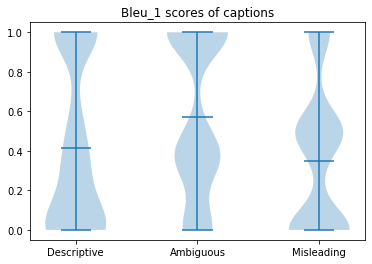

(-0.10648952284999111, 8.847478492915427e-05)


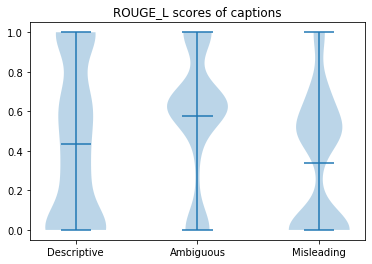

(-0.1853304496575312, 6.757015492180277e-12)


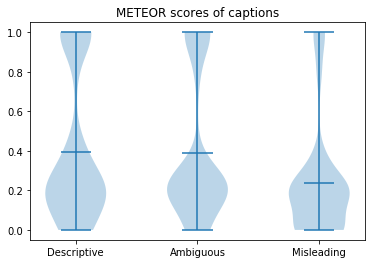

(-0.11097441143888881, 4.382870903358896e-05)


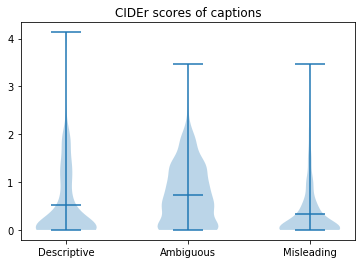

(-0.4485642923206539, 3.569741871416511e-50)


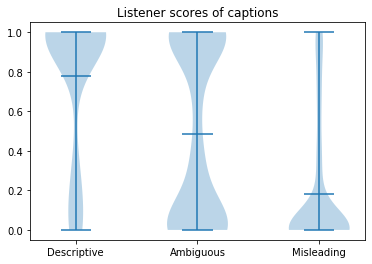

In [426]:
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener']
#all_metrics = ['Listener']
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics_comb, bad_unflipped_metrics_comb, ugly_unflipped_metrics_comb], metric)

I wonder what these look like for the conditions separately? (Split, close, far). 

I also need to take a look at the lengths of each of these.

Finally, it might be worthwhile to filter the ambiguous ones to not include exact matches to the references, because I'm sure that's one of the things that's messing up.

(Basically take a closer look at the data).

In [ ]:
# I have a few minutes now after republishing 2 HITs, so I'm going to take a look at this

In [23]:
# lengths first:
import nltk
import seaborn as sns

In [348]:
good_caption_unflipped_comb_lens = [len(nltk.word_tokenize(cap)) for cap in good_captions_unflipped_comb]
bad_caption_unflipped_comb_lens = [len(nltk.word_tokenize(cap)) for cap in bad_captions_unflipped_comb]
ugly_caption_unflipped_comb_lens = [len(nltk.word_tokenize(cap)) for cap in ugly_captions_unflipped_comb]

In [352]:
ugly_caption_unflipped_comb_lens[:10]

[2, 1, 2, 1, 2, 2, 1, 2, 2, 2]

3.577777777777778


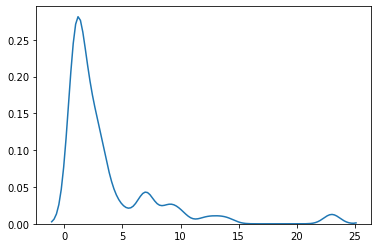

In [362]:
print(np.mean(good_caption_unflipped_comb_lens))
sns.kdeplot(good_caption_unflipped_comb_lens) # seems like there's a bit of a difference in length distributions

1.7


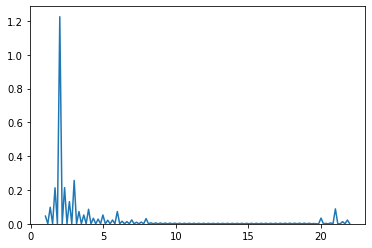

In [363]:
print(np.mean(bad_caption_unflipped_comb_lens))
sns.kdeplot(bad_caption_unflipped_comb_lens)

1.82


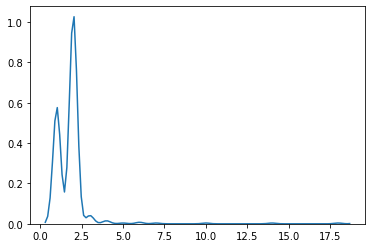

In [364]:
print(np.mean(ugly_caption_unflipped_comb_lens))
sns.kdeplot(ugly_caption_unflipped_comb_lens)

In [369]:
# how about references?
refs_caption_unflipped_comb_lens = [len(nltk.word_tokenize(cap)) for cap in np.array(ref_captions_unflipped_comb[::5]).flatten()]

1.8888888888888888


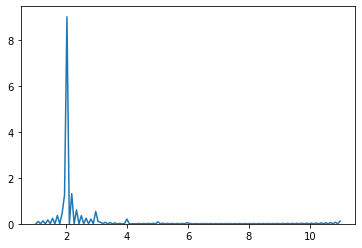

In [370]:
print(np.mean(refs_caption_unflipped_comb_lens))
sns.kdeplot(refs_caption_unflipped_comb_lens)

In [ ]:
# this might be a factor, but I'm not totally sure. It definitely is clear that on average, the reference,
# ambiguous and misleading utterances have fewer words. This is an argument for using the collected data to 
# augment the Monroe data when necessary. I don't think just using the collected mturk data is the best either,
# I think that the references will be pretty similar, but this also something to try.



In [376]:
ref_good_captions_unflipped_comb = []
ref_4_captions_unflipped_comb = []
for i, ref_set in enumerate(ref_captions_unflipped_comb):
    cand_ind = i % 5
    ref_good_captions_unflipped_comb.append(ref_set[cand_ind])
    ref_4_captions_unflipped_comb.append(ref_set[:cand_ind] + ref_set[cand_ind + 1:])

In [387]:
good_4_refs_unflipped_metrics_comb = get_overlap_scores(ref_4_captions_unflipped_comb, ref_good_captions_unflipped_comb)
bad_4_refs_unflipped_metrics_comb = get_overlap_scores(ref_4_captions_unflipped_comb, bad_captions_unflipped_comb)
ugly_4_refs_unflipped_metrics_comb = get_overlap_scores(ref_4_captions_unflipped_comb, ugly_captions_unflipped_comb)

In [393]:
# let's evaluate the new "good" captions with the listener model
ref_good_unflipped_scores_comb = listener_assessment(ctx_good_unflipped_comb)

In [394]:
add_score_to_metric(ref_good_unflipped_scores_comb, good_4_refs_unflipped_metrics_comb)
add_score_to_metric(bad_unflipped_scores_comb, bad_4_refs_unflipped_metrics_comb) # these scores don't change
add_score_to_metric(ugly_unflipped_scores_comb, ugly_4_refs_unflipped_metrics_comb) # these scores don't change

(-0.2716892375201359, 2.839624469319845e-24)


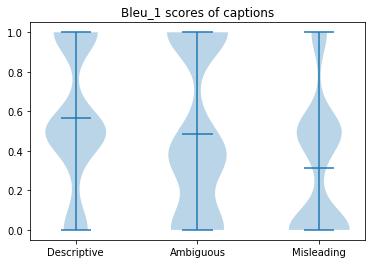

(-0.30485975720720293, 1.980042768310591e-30)


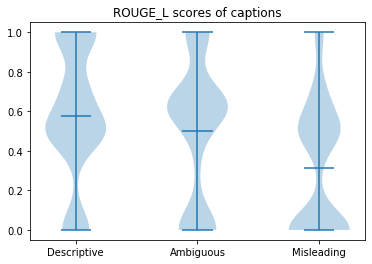

(-0.2824689208807046, 3.4884238018664667e-26)


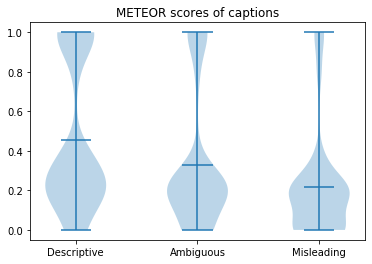

(-0.26867690033371316, 9.375655208845615e-24)


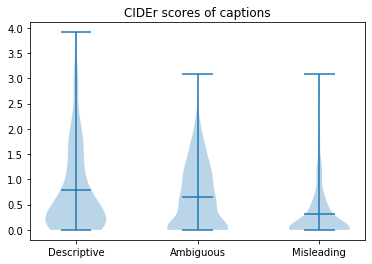

(-0.4363196990135382, 7.572705697751271e-64)


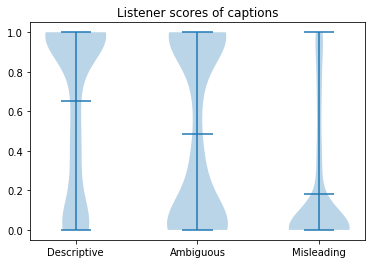

In [401]:
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener']
for metric in all_metrics:
    plot_score_dists([good_4_refs_unflipped_metrics_comb, bad_4_refs_unflipped_metrics_comb,
                      ugly_4_refs_unflipped_metrics_comb], metric)

(-0.34432434175670157, 1.8897709622765342e-26)


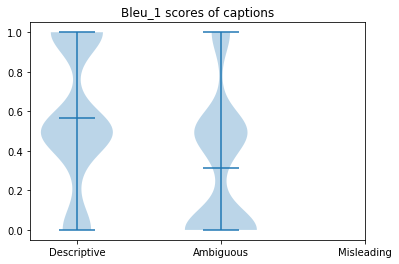

(-0.37371332973186666, 3.282660711306522e-31)


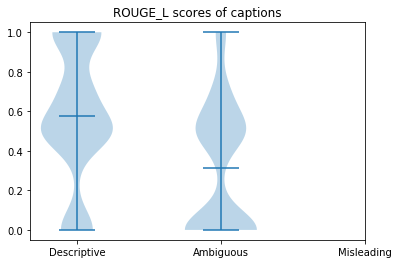

(-0.3458762555223637, 1.0898936869323155e-26)


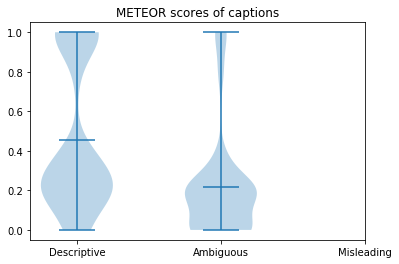

(-0.31177674063082583, 9.69501798327416e-22)


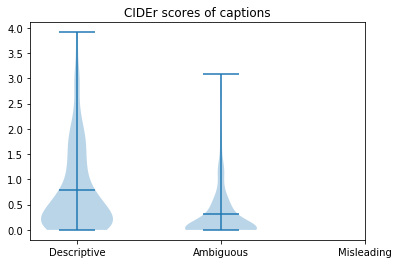

(-0.5398184558670862, 3.317354695711402e-69)


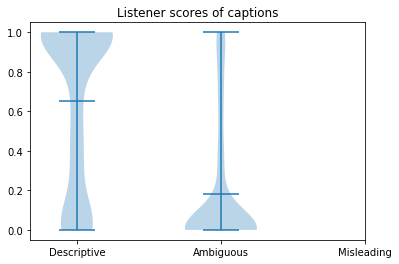

In [402]:
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener']
for metric in all_metrics:
    plot_score_dists([good_4_refs_unflipped_metrics_comb,
                      ugly_4_refs_unflipped_metrics_comb], metric)

In [ ]:
# ok let's see how we can create plots from all the data from yesterday.

In [427]:
mturk_data_combined_123 = MonroeData("../data/csv/mturk_augmented_data_exp123.csv", single_speaker=False)

In [428]:
for i in mturk_data_combined_123.read_data(): pass

In [429]:
ctx_good_unflipped_comb123, ctx_bad_unflipped_comb123, ctx_good_flipped_comb123, ctx_bad_flipped_comb123 = (
    extract_context_lists(mturk_data_combined_123)
)

In [430]:
# get the reference, ambiguous and misleading captions from our mturk data.
ref_captions_unflipped_comb123 = extract_as_reference_captions(ctx_good_unflipped_comb123)
bad_captions_unflipped_comb123 = extract_captions(ctx_bad_unflipped_comb123)
ugly_captions_unflipped_comb123 = extract_captions(ctx_good_flipped_comb123)

In [439]:
# get potential "good" captions from the monroe et al. dev data
good_captions_unflipped_comb123, contexts_dev_comb123 = get_good_candidates(0, len(mturk_data_combined_123) // (2 * 2 * num_reps))
good_captions_unflipped_comb123 = np.repeat(good_captions_unflipped_comb123, num_reps).tolist()


In [440]:
# get word overlap scores
good_unflipped_metrics_comb123 = get_overlap_scores(ref_captions_unflipped_comb123, good_captions_unflipped_comb123)
bad_unflipped_metrics_comb123 = get_overlap_scores(ref_captions_unflipped_comb123, bad_captions_unflipped_comb123)
ugly_unflipped_metrics_comb123 = get_overlap_scores(ref_captions_unflipped_comb123, ugly_captions_unflipped_comb123)

In [442]:
# get listener scores
good_unflipped_scores_comb123 = listener_assessment(contexts_dev_comb123)
bad_unflipped_scores_comb123 = listener_assessment(ctx_bad_unflipped_comb123)

# switch the colors in the ugly context
ctx_ugly_unflipped_comb123 = copy.deepcopy(ctx_good_flipped_comb123)
for i, context in enumerate(ctx_good_unflipped_comb123):
    ctx_ugly_unflipped_comb123[i].colors = context.colors
    
ugly_unflipped_scores_comb123 = listener_assessment(ctx_ugly_unflipped_comb123)

In [443]:
add_score_to_metric(good_unflipped_scores_comb123, good_unflipped_metrics_comb123)
add_score_to_metric(bad_unflipped_scores_comb123, bad_unflipped_metrics_comb123)
add_score_to_metric(ugly_unflipped_scores_comb123, ugly_unflipped_metrics_comb123)

(-0.04023091176127163, 0.139566585990288)


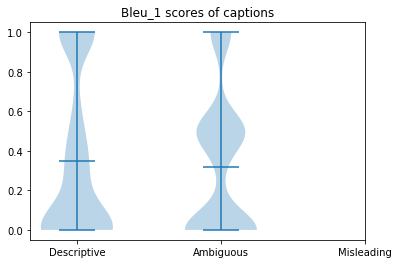

(-0.07195900309302072, 0.008170956231450916)


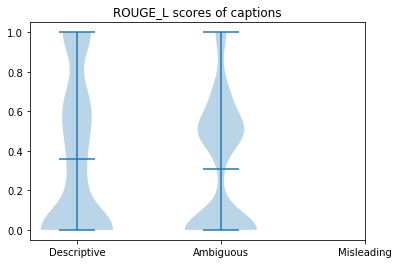

(-0.15933846968701842, 3.939999179243208e-09)


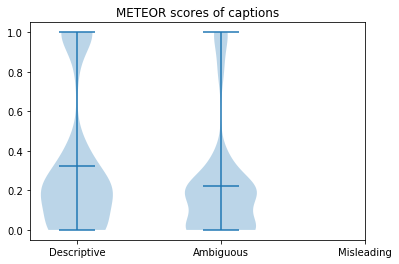

(-0.0938026635551907, 0.0005586200328378777)


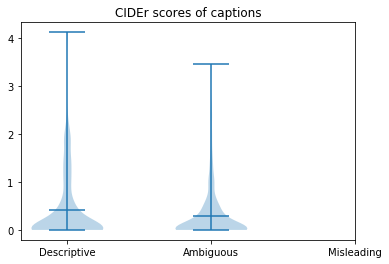

(-0.5222704142356853, 6.99939204273628e-58)


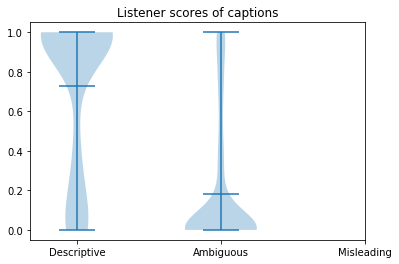

In [445]:
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener']
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics_comb123,
                      ugly_unflipped_metrics_comb123], metric)

(-0.0309359101377273, 0.16404675954908252)


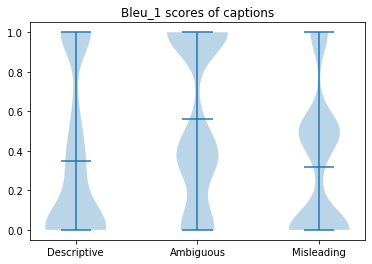

(-0.056740545768203074, 0.01065527615859289)


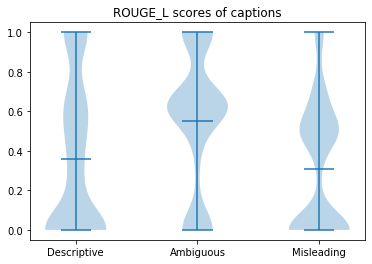

(-0.1224408192749746, 3.2530279288804606e-08)


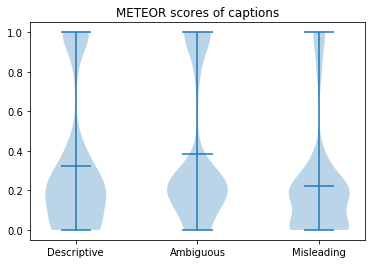

(-0.07316156331411355, 0.0009854316274680464)


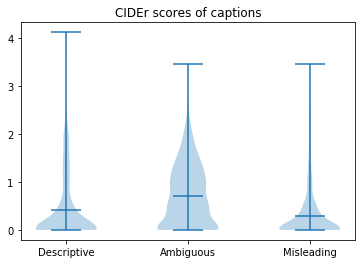

(-0.4364860692501547, 4.072836802011672e-70)


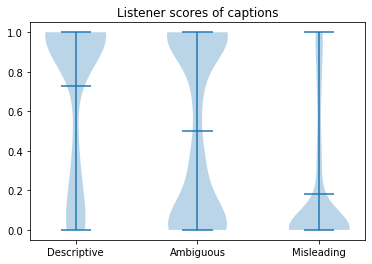

In [446]:
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener']
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics_comb123, bad_unflipped_metrics_comb123,
                      ugly_unflipped_metrics_comb123], metric)

In [560]:
len(good_unflipped_ scores_comb123)

135

In [567]:
good_captions_unflipped_comb123[::5]

['brightest color',
 'grey. looks less purple than the other one.',
 'the green',
 'The purple that has the most grey',
 'lime green',
 'brown',
 'weve done pretty good I think ~ this isnt too easy ~ this one is hard ~ maybe the lightest of the colors',
 'purple again!',
 'light blue',
 'the blueish one',
 'the bright green one',
 'purple ~ h',
 'Brightest shade of blue',
 'blue',
 'gray',
 'The brightest green',
 'purple',
 'closest to magenta',
 'Neon purple-pinkish, not the shaded ones',
 'dull green',
 'royal ~ blue',
 'Definitely not the dark green ~ Definitely not watermelon',
 'the brightest one of the 2 the same color',
 'green',
 'Darkest blue. ~ Yes.',
 "neon green '",
 'blue/purple',
 'Olive',
 'fresh mown dark grass',
 'red',
 'drab',
 'bright blue green ~ the lighter one',
 'the pink',
 'LOL ~ Not the bluish ~ The one with the tint of Brown',
 'grey',
 'flower',
 'pink',
 'not purply or greying',
 'Royal',
 'neon green',
 'pink bright',
 'green',
 'lightest purple',
 'gree

In [561]:
len(bad_unflipped_scores_comb123)

675

In [564]:
len(mturk_data_combined_123)/20

135.0

In [ ]:
# I'm also curious about a literal speaker scorer... Maybe I'll implement that real quick

In [25]:
# I'm curious about how well the literal listener performs on this data, so I'm going to add it in:
# first, necesessary imports:
import color_featurizers
from models import LiteralSpeakerScorer, CaptionGenerator
from experiment import FeatureHandler

caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)
color_phi_speaker = color_featurizers.ColorFeaturizer(color_featurizers.color_phi_fourier, "hsv", normalized=True) # NOTE: RGB

def speaker_target(data_entry):
    _, caption_ids = caption_phi.to_string_features(data_entry.caption) # this probably works...
    target = caption_ids[1:]
    return target

feature_handler_dev_speaker = FeatureHandler(train_data, dev_data, caption_phi, color_phi_speaker,
                                             target_fn=speaker_target, randomized_colors=False)

In [26]:
model_lss = LiteralSpeakerScorer(CaptionGenerator)
model_lss.init_model(
            color_in_dim=54, color_dim=100,
                              vocab_size=caption_phi.caption_indexer.size, embed_dim=100,
                             speaker_hidden_dim=100)
model_lss.load_model("../model/literal_speaker_30epochGLOVE.params")

In [498]:
X_assess_speaker = feature_handler_dev_speaker.test_features()
y_assess_speaker = feature_handler_dev_speaker.test_targets()

In [499]:
speaker_dev_preds = model_lss.predict(X_assess_speaker)

In [454]:
speaker_dev_preds[:10]

[[tensor([[-26.2687,  -4.3141,  -3.7172,  ..., -26.1553, -26.5114, -26.4856],
          [-23.6310, -17.4850, -16.9528,  ..., -23.5490, -24.0957, -24.0779],
          [-28.6200,  -8.8902,  -7.0084,  ..., -28.5517, -28.9600, -28.9609],
          [-30.0284,  -6.4121,  -9.8931,  ..., -29.9646, -30.9081, -30.8914]]),
  tensor([[-27.9916,  -3.4469,  -2.9870,  ..., -27.9826, -28.3168, -28.3482],
          [-24.3200, -18.2379, -17.3373,  ..., -24.3231, -24.8248, -24.8587],
          [-29.5042,  -9.8011,  -7.5719,  ..., -29.5215, -29.8860, -29.9378],
          [-30.0284,  -6.4121,  -9.8930,  ..., -29.9646, -30.9081, -30.8914]]),
  tensor([[-26.4389,  -3.5581,  -2.8349,  ..., -26.4119, -26.7206, -26.7456],
          [-24.3237, -18.1654, -17.3112,  ..., -24.3274, -24.8317, -24.8636],
          [-29.4874,  -9.6730,  -7.5179,  ..., -29.5059, -29.8745, -29.9231],
          [-30.0284,  -6.4121,  -9.8930,  ..., -29.9646, -30.9081, -30.8914]])],
 [tensor([[-28.3346,  -2.7086,  -2.4587,  ..., -28.3455, 

In [27]:
def speaker_predictions_to_scores(results, targets):
    all_scores = []
    target_lens = np.array([len(target) for target in targets])
    for i, predictions in enumerate(results):
#         print(i)
#         print(np.arange(target_lens[i]))
#         print(targets[i])
#         print(predictions[i])
        scores = [0, 0, 0]
        for j, prediction in enumerate(predictions):
            #try:
            scores[j] = np.sum(prediction[np.arange(target_lens[i]), targets[i]].numpy()) # end tokens are already cut off
#             except e:
#                 #print(prediction)
#                 print(i)
#                 #print(target_lens[i])
#                 #print(targets[i].numpy())
#                 raise IndexError
        all_scores.append(scores)
    
    # now we can softmax these probabilities in log space
    all_scores = np.array(all_scores)
    all_scores_dist = (all_scores.T - logsumexp(all_scores, axis=1)).T
    # the target is at index 0
    return all_scores_dist[:, 0]
    
#     target_log_prob = np.array(all_scores)[:, 0].tolist() # log probability of the target
#     target_log_prob = target_log_prob / target_lens # normalize for sentence length
#     return np.array(all_scores)#target_log_prob

In [508]:
speaker_dev_scores = speaker_predictions_to_scores(speaker_dev_preds, y_assess_speaker)

In [509]:
speaker_dev_scores[:10] # log probability of target (0th element)

array([-7.1358109e-01, -7.1025848e-02, -2.0081043e-02, -2.4380512e+00,
       -3.2384205e-01, -1.6260982e-02, -1.6936737e+01, -1.7026987e+00,
       -2.3979425e-01, -1.3241386e-01], dtype=float32)

{'bodies': [<matplotlib.collections.PolyCollection at 0x1c482c2710>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1c482c2668>,
 'cmins': <matplotlib.collections.LineCollection at 0x1c482c2b38>,
 'cbars': <matplotlib.collections.LineCollection at 0x1c482c2ba8>}

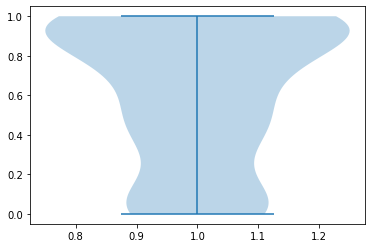

In [510]:
plt.violinplot(np.exp(speaker_dev_scores))

In [28]:
def speaker_assessment(eval_contexts):
    # assumes everything else is loaded up and ready...
    feature_handler = FeatureHandler(train_data, eval_contexts,
                                     caption_phi, color_phi_speaker,
                                     randomized_colors=False, target_fn=speaker_target)
    X_assess = feature_handler.test_features()
    y_assess = feature_handler.test_targets()

    preds = model_lss.predict(X_assess)
    # print(preds[0])
    scores = speaker_predictions_to_scores(preds, y_assess)
    return scores

In [549]:
# get speaker scores
good_unflipped_scores_comb123_speaker = speaker_assessment(contexts_dev_comb123)
bad_unflipped_scores_comb123_speaker = speaker_assessment(ctx_bad_unflipped_comb123)
ugly_unflipped_scores_comb123_speaker = speaker_assessment(ctx_ugly_unflipped_comb123)

[tensor([[-31.2341,  -3.3407,  -3.2978,  ..., -31.2418, -31.6897, -31.6806],
        [-29.3859, -20.7475, -17.6978,  ..., -29.3458, -30.0463, -30.0171],
        [-31.6557,  -9.7734,  -7.7816,  ..., -31.6788, -32.1401, -32.1396],
        [-30.9565,  -6.4907,  -9.2586,  ..., -30.9248, -31.9010, -31.8889]]), tensor([[-28.5678,  -3.3862,  -2.7992,  ..., -28.5016, -28.9155, -28.8898],
        [-24.7170, -18.1350, -16.6944,  ..., -24.6574, -25.2404, -25.2182],
        [-30.1336,  -9.8196,  -7.2872,  ..., -30.0944, -30.5337, -30.5310],
        [-30.3994,  -6.4879,  -9.1489,  ..., -30.3611, -31.3264, -31.3129]]), tensor([[-29.0253,  -2.9478,  -2.5669,  ..., -29.0112, -29.4229, -29.4094],
        [-26.3611, -20.0073, -16.5322,  ..., -26.2934, -26.9488, -26.9136],
        [-30.8279,  -9.5518,  -7.4175,  ..., -30.8438, -31.2926, -31.2920],
        [-30.3999,  -6.4884,  -9.1450,  ..., -30.3617, -31.3271, -31.3136]])]
[tensor([[-31.2341,  -3.3407,  -3.2978,  ..., -31.2418, -31.6897, -31.6806],
    

In [550]:
add_score_to_metric(good_unflipped_scores_comb123_speaker, good_unflipped_metrics_comb123, name="Speaker")
add_score_to_metric(bad_unflipped_scores_comb123_speaker, bad_unflipped_metrics_comb123, name="Speaker")
add_score_to_metric(ugly_unflipped_scores_comb123_speaker, ugly_unflipped_metrics_comb123, name="Speaker")

(-0.4364860692501547, 4.072836802011672e-70)


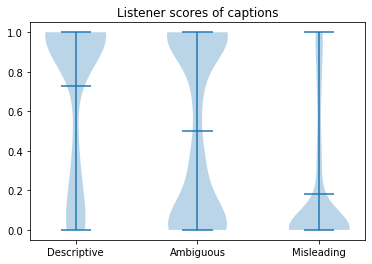

(-0.3981404367545617, 1.3686802801516287e-57)


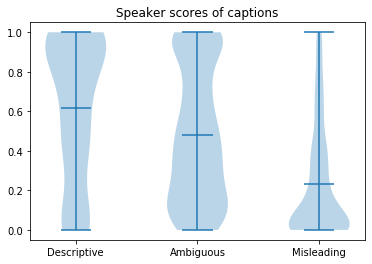

In [557]:
#all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener']
all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics_comb123, bad_unflipped_metrics_comb123,
                      ugly_unflipped_metrics_comb123], metric)

In [553]:
ref_captions_unflipped_comb123_speaker = speaker_assessment(ctx_good_unflipped_comb123)


[tensor([[-31.2341,  -3.3407,  -3.2978,  ..., -31.2418, -31.6897, -31.6806],
        [-29.3859, -20.7475, -17.6978,  ..., -29.3458, -30.0463, -30.0171],
        [-34.0759,  -8.5393,  -7.8144,  ..., -34.0652, -34.7066, -34.7557]]), tensor([[-28.5678,  -3.3862,  -2.7992,  ..., -28.5016, -28.9155, -28.8898],
        [-24.7170, -18.1350, -16.6944,  ..., -24.6574, -25.2404, -25.2182],
        [-31.5349,  -8.3618,  -7.1950,  ..., -31.4956, -32.0903, -32.1334]]), tensor([[-29.0253,  -2.9478,  -2.5669,  ..., -29.0112, -29.4229, -29.4094],
        [-26.3611, -20.0073, -16.5322,  ..., -26.2934, -26.9488, -26.9136],
        [-31.5309,  -8.3616,  -7.1942,  ..., -31.4916, -32.0861, -32.1293]])]


{'bodies': [<matplotlib.collections.PolyCollection at 0x1c481bd518>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x1c48357898>,
 'cmins': <matplotlib.collections.LineCollection at 0x1c481bd7f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1c481bd630>}

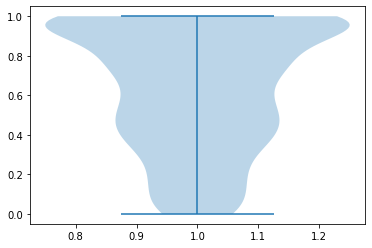

In [555]:
plt.violinplot(np.exp(ref_captions_unflipped_comb123_speaker))

In [45]:
from scipy.special import logsumexp

In [483]:
logsumexp(speaker_dev_scores, axis=1)[:10]

array([ -10.978319 ,  -52.245777 ,   -4.946549 ,  -26.760105 ,
         -3.659298 ,   -3.6791437, -199.6276   ,  -18.327915 ,
         -8.839386 ,  -11.942976 ], dtype=float32)

In [503]:
sum(np.argmax(speaker_dev_scores, axis=1) == 0)

93

In [504]:
np.exp((speaker_dev_scores[:10].T - logsumexp(speaker_dev_scores, axis=1)[:10]).T[:, 0])

array([4.8988673e-01, 9.3143779e-01, 9.8011923e-01, 8.7330878e-02,
       7.2336447e-01, 9.8387051e-01, 4.4103043e-08, 1.8219118e-01,
       7.8678972e-01, 8.7597841e-01], dtype=float32)

In [475]:
len(speaker_dev_scores)

135

In [476]:
np.exp(speaker_dev_scores)[:10]

array([4.50509897e-02, 1.02491775e-02, 1.82000905e-01, 3.25789018e-02,
       2.83052797e-01, 7.10986952e-02, 2.20110018e-04, 9.39647308e-03,
       1.62946481e-02, 6.77060043e-02])

Gray


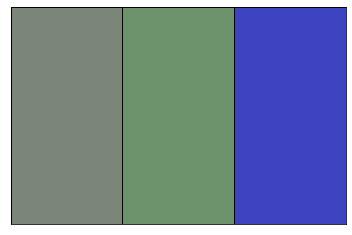

Gray with green


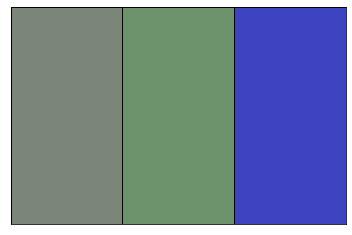

grey green


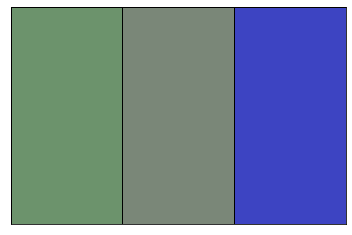

In [255]:
i = -1
dev_data.display_custom_game(contexts_good_flipped[i].colors, contexts_good_flipped[i].caption)
dev_data.display_custom_game(contexts_bad_flipped[i].colors, contexts_bad_flipped[i].caption)
dev_data.display_custom_game(contexts_good_unflipped[i].colors, contexts_good_unflipped[i].caption)

In [29]:
# Now with ALL the data
mturk_data_combined_1234 = MonroeData("../data/csv/mturk_augmented_data_exp1234.csv", single_speaker=False)

In [30]:
for i in mturk_data_combined_1234.read_data(): pass

In [31]:
ctx_good_unflipped_comb1234, ctx_bad_unflipped_comb1234, ctx_good_flipped_comb1234, ctx_bad_flipped_comb1234 = (
    extract_context_lists(mturk_data_combined_1234)
)

In [32]:
# get the reference, ambiguous and misleading captions from our mturk data.
ref_captions_unflipped_comb1234 = extract_as_reference_captions(ctx_good_unflipped_comb1234)
bad_captions_unflipped_comb1234 = extract_captions(ctx_bad_unflipped_comb1234)
ugly_captions_unflipped_comb1234 = extract_captions(ctx_good_flipped_comb1234)


ref_captions_flipped_comb1234 = extract_as_reference_captions(ctx_good_flipped_comb1234)
bad_captions_flipped_comb1234 = extract_captions(ctx_bad_flipped_comb1234)
ugly_captions_flipped_comb1234 = extract_captions(ctx_good_unflipped_comb1234)

In [37]:
# get potential "good" captions from the monroe et al. dev data
num_reps=5
good_captions_unflipped_comb1234, contexts_dev_comb1234 = get_good_candidates(0, len(mturk_data_combined_1234) // (2 * 2 * num_reps))
good_captions_unflipped_comb1234 = np.repeat(good_captions_unflipped_comb1234, num_reps).tolist()



In [41]:
# get word overlap scores
good_unflipped_metrics_comb1234 = get_overlap_scores(ref_captions_unflipped_comb1234, good_captions_unflipped_comb1234)
bad_unflipped_metrics_comb1234 = get_overlap_scores(ref_captions_unflipped_comb1234, bad_captions_unflipped_comb1234)
ugly_unflipped_metrics_comb1234 = get_overlap_scores(ref_captions_unflipped_comb1234, ugly_captions_unflipped_comb1234)

In [42]:
# get listener scores
good_unflipped_scores_comb1234 = listener_assessment(contexts_dev_comb1234)
bad_unflipped_scores_comb1234 = listener_assessment(ctx_bad_unflipped_comb1234)

# switch the colors in the ugly context
ctx_ugly_unflipped_comb1234 = copy.deepcopy(ctx_good_flipped_comb1234)
for i, context in enumerate(ctx_good_unflipped_comb1234):
    ctx_ugly_unflipped_comb1234[i].colors = context.colors
    
ugly_unflipped_scores_comb1234 = listener_assessment(ctx_ugly_unflipped_comb1234)

In [43]:
add_score_to_metric(good_unflipped_scores_comb1234, good_unflipped_metrics_comb1234)
add_score_to_metric(bad_unflipped_scores_comb1234, bad_unflipped_metrics_comb1234)
add_score_to_metric(ugly_unflipped_scores_comb1234, ugly_unflipped_metrics_comb1234)

In [46]:
# get speaker scores
good_unflipped_scores_comb1234_speaker = speaker_assessment(contexts_dev_comb1234)
bad_unflipped_scores_comb1234_speaker = speaker_assessment(ctx_bad_unflipped_comb1234)
ugly_unflipped_scores_comb1234_speaker = speaker_assessment(ctx_ugly_unflipped_comb1234)

In [47]:
add_score_to_metric(good_unflipped_scores_comb1234_speaker, good_unflipped_metrics_comb1234, name="Speaker")
add_score_to_metric(bad_unflipped_scores_comb1234_speaker, bad_unflipped_metrics_comb1234, name="Speaker")
add_score_to_metric(ugly_unflipped_scores_comb1234_speaker, ugly_unflipped_metrics_comb1234, name="Speaker")

(-0.002620205603123706, 0.8917524532425052)
SpearmanrResult(correlation=0.08753061916229563, pvalue=5.241985012661422e-06)
KendalltauResult(correlation=0.06916944086601469, pvalue=9.857218396244046e-06)


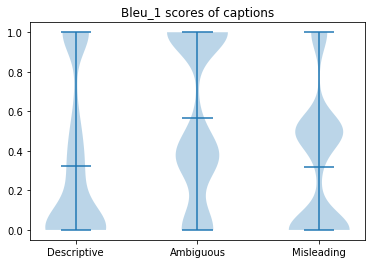

(-0.023863403486020316, 0.21513035997676117)
SpearmanrResult(correlation=-0.03145999854531247, pvalue=0.1021839056190259)
KendalltauResult(correlation=-0.03466619503113118, pvalue=0.03267966697074142)


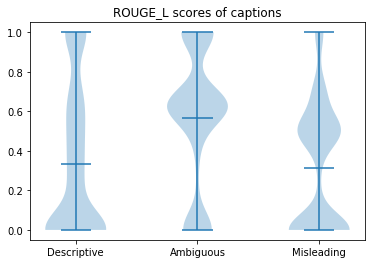

(-0.11133851441195622, 6.604549266244759e-09)
SpearmanrResult(correlation=-0.11506025983252126, pvalue=2.024109085279245e-09)
KendalltauResult(correlation=-0.10083278002517355, pvalue=1.6127558476492084e-10)


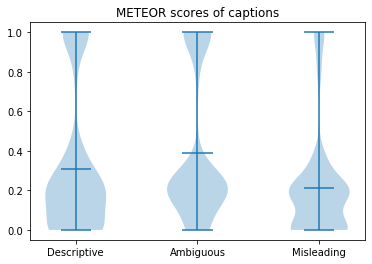

(-0.048482583858906414, 0.01175069379323187)
SpearmanrResult(correlation=-0.020368914786631536, pvalue=0.290046546602111)
KendalltauResult(correlation=-0.021254724494313777, pvalue=0.17262806908653094)


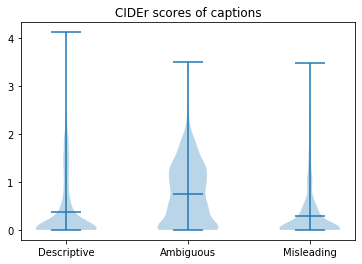

(-0.43211295610181777, 6.979548104462723e-91)
SpearmanrResult(correlation=-0.4809435944391934, pvalue=3.808384081849487e-115)
KendalltauResult(correlation=-0.3827147259003171, pvalue=9.379029986339638e-103)


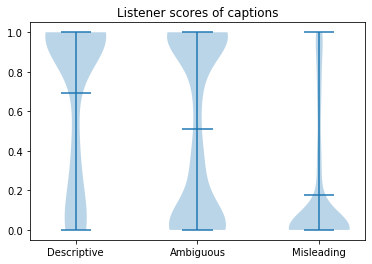

(-0.378360877644152, 2.0602752749093134e-68)
SpearmanrResult(correlation=-0.38942148411847266, pvalue=1.0551924369762835e-72)
KendalltauResult(correlation=-0.31293057254598766, pvalue=1.6605224979937396e-69)


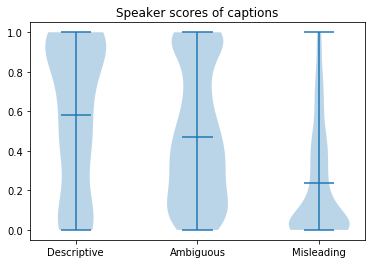

In [48]:
# Copy notebook
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener', 'Speaker']
# all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics_comb1234, bad_unflipped_metrics_comb1234,
                      ugly_unflipped_metrics_comb1234], metric)

(-0.002620205603123706, 0.8917524532425052)


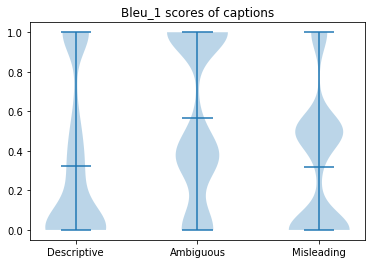

(-0.023863403486020316, 0.21513035997676117)


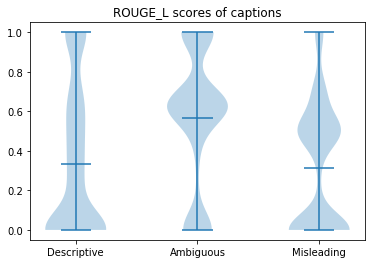

(-0.11133851441195622, 6.604549266244759e-09)


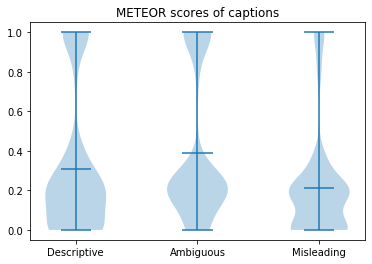

(-0.048482583858906414, 0.01175069379323187)


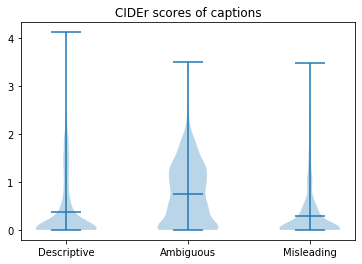

(-0.43211295618625256, 6.979547483760669e-91)


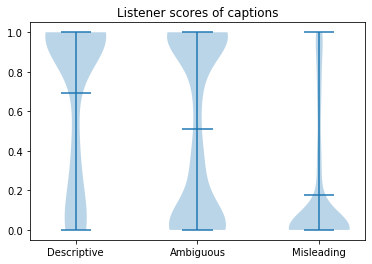

(-0.378360877644152, 2.0602752749093134e-68)


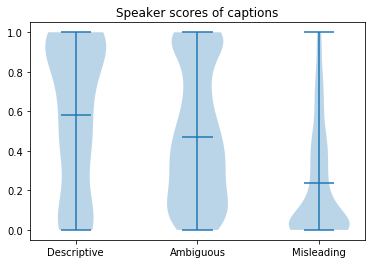

In [707]:
# DO NOT RUN - Original notebook
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener', 'Speaker']
# all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics_comb1234, bad_unflipped_metrics_comb1234,
                      ugly_unflipped_metrics_comb1234], metric)

ok, I want to try some filtering stuff to make sure that the data is good. There shouldn't be any ambiguous utterances that are the same as their reference utterances, so I'm going to get rid of those.

I also am going to add in the 

Also, to note, I'm going to first be working on just using data that I collected. Then I'll work on integrating the data that Will and Robert collected.



In [49]:
# Filtering - first bad indices - we filter contexts too for listener/speaker eval models that need them
# filter_indices_bad = []
ctx_bad_unflipped_comb1234_filtered = []
bad_captions_unflipped_comb1234_filtered = []
ref_captions_unflipped_comb1234_bad_filtered = []

for i in range(len(bad_captions_unflipped_comb1234)):
    if not bad_captions_unflipped_comb1234[i] in ref_captions_unflipped_comb1234[i]:
        bad_captions_unflipped_comb1234_filtered.append(bad_captions_unflipped_comb1234[i])
        ctx_bad_unflipped_comb1234_filtered.append(ctx_bad_unflipped_comb1234[i])
        ref_captions_unflipped_comb1234_bad_filtered.append(ref_captions_unflipped_comb1234[i])
        #filter_indices_bad.append(i)

In [50]:
# now good indices - this seem ok
# filter_indices_ugly = []

ctx_ugly_unflipped_comb1234_filtered = []
ugly_captions_unflipped_comb1234_filtered = []
ref_captions_unflipped_comb1234_ugly_filtered = []

for i in range(len(ugly_captions_unflipped_comb1234)):
    if not (ugly_captions_unflipped_comb1234[i] in ref_captions_unflipped_comb1234[i] and
       ctx_good_unflipped_comb1234[i].condition == "far"):
        ugly_captions_unflipped_comb1234_filtered.append(ugly_captions_unflipped_comb1234[i])
        ctx_ugly_unflipped_comb1234_filtered.append(ctx_ugly_unflipped_comb1234[i])
        ref_captions_unflipped_comb1234_ugly_filtered.append(ref_captions_unflipped_comb1234[i])
        #filter_indices_ugly.append(i)

In [51]:
# let's also do this for the flipped ones
ctx_bad_flipped_comb1234_filtered = []
bad_captions_flipped_comb1234_filtered = []
ref_captions_flipped_comb1234_bad_filtered = []

for i in range(len(bad_captions_flipped_comb1234)):
    if not bad_captions_flipped_comb1234[i] in ref_captions_flipped_comb1234[i]:
        bad_captions_flipped_comb1234_filtered.append(bad_captions_flipped_comb1234[i])
        ctx_bad_flipped_comb1234_filtered.append(ctx_bad_flipped_comb1234[i])
        ref_captions_flipped_comb1234_bad_filtered.append(ref_captions_flipped_comb1234[i])

# create the misleading (i.e. ugly) flipped target data before filtering it
ctx_ugly_flipped_comb1234 = copy.deepcopy(ctx_good_unflipped_comb1234)
for i, context in enumerate(ctx_good_flipped_comb1234):
    ctx_ugly_flipped_comb1234[i].colors = context.colors
    
ugly_unflipped_scores_comb1234 = listener_assessment(ctx_ugly_unflipped_comb1234)
ctx_ugly_flipped_comb1234_filtered = []        
ugly_captions_flipped_comb1234_filtered = []
ref_captions_flipped_comb1234_ugly_filtered = []

for i in range(len(ugly_captions_flipped_comb1234)):
    if not (ugly_captions_flipped_comb1234[i] in ref_captions_flipped_comb1234[i] and
       ctx_good_flipped_comb1234[i].condition == "far"):
        ugly_captions_flipped_comb1234_filtered.append(ugly_captions_flipped_comb1234[i])
        ctx_ugly_flipped_comb1234_filtered.append(ctx_ugly_flipped_comb1234[i])
        ref_captions_flipped_comb1234_ugly_filtered.append(ref_captions_flipped_comb1234[i])


In [52]:
len(ugly_captions_flipped_comb1234_filtered)

882

In [53]:
# ok, to involve the captions in the flipped target contexts, we need to create "good" flipped captions,
# which we can do by choosing one of the reference captions and evaluating it against the others.

# the contexts are not filtered so, they are the same as the unfiltered ones
ctx_good_flipped_comb1234_filtered = [] # ctx_good_flipped_comb1234
good_captions_flipped_comb1234_filtered = []
ref_captions_flipped_comb1234_good_filtered = []

for rid, references in enumerate(ref_captions_flipped_comb1234[::5]):
    # get rid of duplicates, and obtain their indices for adding the contexts (this is needed for listener eval)
    ref_dict = dict(zip(references, range(len(references))))
    references = list(ref_dict.keys())
    refids = list(ref_dict.values())
    if len(references) <= 1: continue # can't have a single good utterance bc then it has no reference
        
    for i in range(len(references)):
        good_captions_flipped_comb1234_filtered.append(references[i])
        ref_captions_flipped_comb1234_good_filtered.append(references[:i] + references[i+1:])
        ctx_good_flipped_comb1234_filtered.append(ctx_good_flipped_comb1234[5*rid + refids[i]])


In [54]:
# additionally, because I'm focusing on using only the data I collected right now, I'm going to do the
# same with the unflipped condition:

ctx_good_unflipped_comb1234_filtered = [] # ctx_good_unflipped_comb1234
good_captions_unflipped_comb1234_filtered = []
ref_captions_unflipped_comb1234_good_filtered = []

for rid, references in enumerate(ref_captions_unflipped_comb1234[::5]):
    # get rid of duplicates, and obtain their indices for adding the contexts (this is needed for listener eval)
    ref_dict = dict(zip(references, range(len(references))))
    references = list(ref_dict.keys())
    refids = list(ref_dict.values())
    if len(references) <= 1: continue
        
    for i in range(len(references)):
        good_captions_unflipped_comb1234_filtered.append(references[i])
        ref_captions_unflipped_comb1234_good_filtered.append(references[:i] + references[i+1:])
        ctx_good_unflipped_comb1234_filtered.append(ctx_good_unflipped_comb1234[5*rid + refids[i]])




In [55]:
# ok, now let's recalculate all the scores. I'm curious about the flippped captions bc I haven't 
# looked at any of them yet, so I'm going to look at them alone first

# get word overlap scores
good_flipped_metrics_comb1234_filtered = get_overlap_scores(ref_captions_flipped_comb1234_good_filtered, good_captions_flipped_comb1234_filtered)
bad_flipped_metrics_comb1234_filtered = get_overlap_scores(ref_captions_flipped_comb1234_bad_filtered, bad_captions_flipped_comb1234_filtered)
ugly_flipped_metrics_comb1234_filtered = get_overlap_scores(ref_captions_flipped_comb1234_ugly_filtered, ugly_captions_flipped_comb1234_filtered)


In [56]:
# listener and speaker scores
# get listener scores
good_flipped_scores_comb1234_filtered = listener_assessment(ctx_good_flipped_comb1234_filtered)
bad_flipped_scores_comb1234_filtered = listener_assessment(ctx_bad_flipped_comb1234_filtered)
ugly_flipped_scores_comb1234_filtered = listener_assessment(ctx_ugly_flipped_comb1234_filtered)

# get speaker scores
good_flipped_scores_comb1234_speaker_filtered = speaker_assessment(ctx_good_flipped_comb1234_filtered)
bad_flipped_scores_comb1234_speaker_filtered = speaker_assessment(ctx_bad_flipped_comb1234_filtered)
ugly_flipped_scores_comb1234_speaker_filtered = speaker_assessment(ctx_ugly_flipped_comb1234_filtered)


In [57]:
add_score_to_metric(good_flipped_scores_comb1234_filtered, good_flipped_metrics_comb1234_filtered, name="Literal Listener")
add_score_to_metric(bad_flipped_scores_comb1234_filtered, bad_flipped_metrics_comb1234_filtered, name="Literal Listener")
add_score_to_metric(ugly_flipped_scores_comb1234_filtered, ugly_flipped_metrics_comb1234_filtered, name="Literal Listener")

add_score_to_metric(good_flipped_scores_comb1234_speaker_filtered, good_flipped_metrics_comb1234_filtered, name="Pragmatic Listener")
add_score_to_metric(bad_flipped_scores_comb1234_speaker_filtered, bad_flipped_metrics_comb1234_filtered, name="Pragmatic Listener")
add_score_to_metric(ugly_flipped_scores_comb1234_speaker_filtered, ugly_flipped_metrics_comb1234_filtered, name="Pragmatic Listener")

(-0.15685474588255355, 6.673302615088493e-14)
SpearmanrResult(correlation=-0.17568724145200015, pvalue=4.192746278763324e-17)
KendalltauResult(correlation=-0.14868415751185643, pvalue=1.9486017499850655e-17)


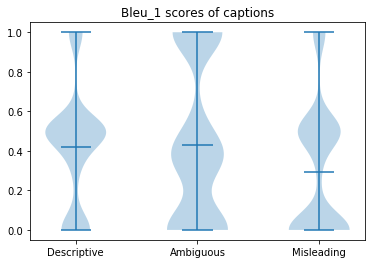

(-0.21615030205014288, 2.866322092389933e-25)
SpearmanrResult(correlation=-0.2408123009425376, pvalue=3.8713839840256487e-31)
KendalltauResult(correlation=-0.20759528355557072, pvalue=7.959894610363534e-31)


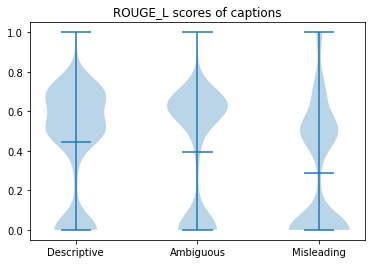

(-0.12282816135040305, 4.791562247705626e-09)
SpearmanrResult(correlation=-0.2381570578921294, pvalue=1.7916338421721385e-30)
KendalltauResult(correlation=-0.200215677358943, pvalue=1.0162871883311156e-30)


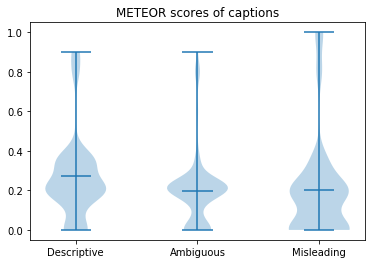

(-0.16564324976599218, 2.379486645735227e-15)
SpearmanrResult(correlation=-0.24187594270625334, pvalue=2.084647980614983e-31)
KendalltauResult(correlation=-0.18976759831824033, pvalue=8.478194685069539e-29)


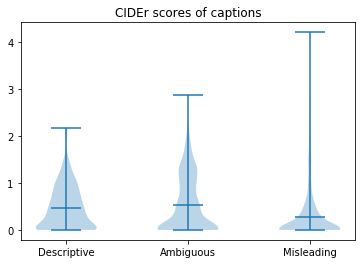

(-0.47840645038907104, 1.903308319955175e-129)
SpearmanrResult(correlation=-0.5095965366635195, pvalue=1.915592886392874e-149)
KendalltauResult(correlation=-0.3992228752918324, pvalue=3.423521602707336e-133)


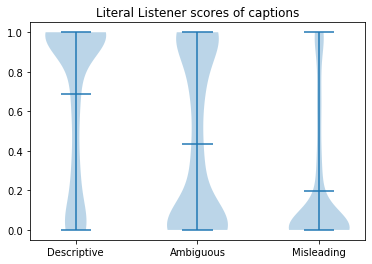

(-0.4531126310769712, 1.0981985488334393e-114)
SpearmanrResult(correlation=-0.46018659722012273, pvalue=1.088491773328596e-118)
KendalltauResult(correlation=-0.36434309847066726, pvalue=1.3703339740638682e-111)


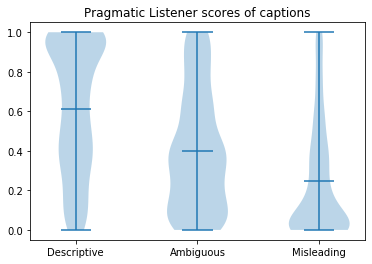

In [59]:
# Notebook Copy
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Literal Listener', 'Pragmatic Listener']
# all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_flipped_metrics_comb1234_filtered, bad_flipped_metrics_comb1234_filtered,
                      ugly_flipped_metrics_comb1234_filtered], metric)

(-0.15685474588255355, 6.673302615088493e-14)
SpearmanrResult(correlation=-0.17568724145200015, pvalue=4.192746278763324e-17)
KendalltauResult(correlation=-0.14868415751185643, pvalue=1.9486017499850655e-17)


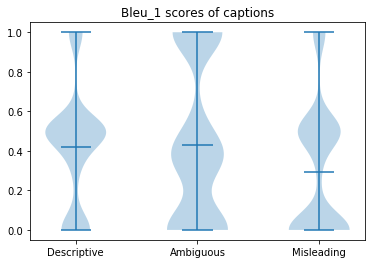

(-0.21615030205014288, 2.866322092389933e-25)
SpearmanrResult(correlation=-0.2408123009425376, pvalue=3.8713839840256487e-31)
KendalltauResult(correlation=-0.20759528355557072, pvalue=7.959894610363534e-31)


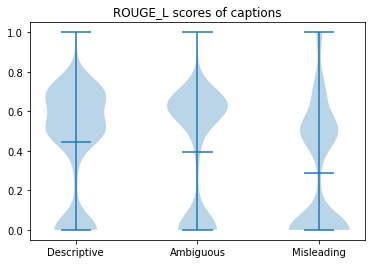

(-0.12282816135040305, 4.791562247705626e-09)
SpearmanrResult(correlation=-0.2381570578921294, pvalue=1.7916338421721385e-30)
KendalltauResult(correlation=-0.200215677358943, pvalue=1.0162871883311156e-30)


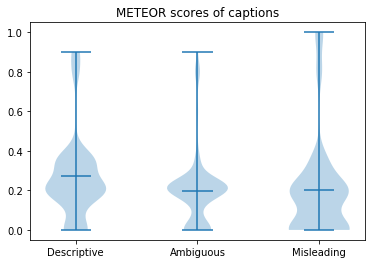

(-0.16564324976599218, 2.379486645735227e-15)
SpearmanrResult(correlation=-0.24187594270625334, pvalue=2.084647980614983e-31)
KendalltauResult(correlation=-0.18976759831824033, pvalue=8.478194685069539e-29)


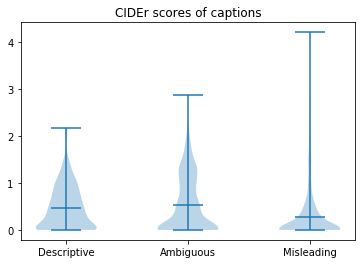

(-0.4784064501017934, 1.9033090860361832e-129)
SpearmanrResult(correlation=-0.5095956133800709, pvalue=1.9183436587728218e-149)
KendalltauResult(correlation=-0.3992216713595467, pvalue=3.4285429501819597e-133)


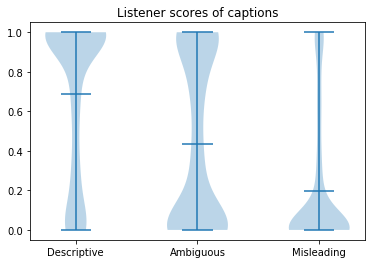

(-0.4531126310769712, 1.0981985488334393e-114)
SpearmanrResult(correlation=-0.46018659722012273, pvalue=1.088491773328596e-118)
KendalltauResult(correlation=-0.36434309847066726, pvalue=1.3703339740638682e-111)


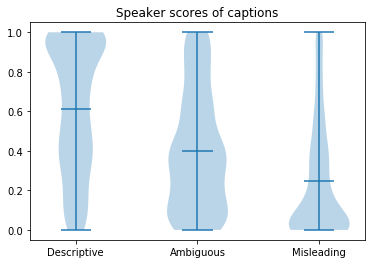

In [1075]:
# DO NOT RUN - Original Notebook Results
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener', 'Speaker']
# all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_flipped_metrics_comb1234_filtered, bad_flipped_metrics_comb1234_filtered,
                      ugly_flipped_metrics_comb1234_filtered], metric)

(-0.3309203101973572, 6.951736533919727e-63)


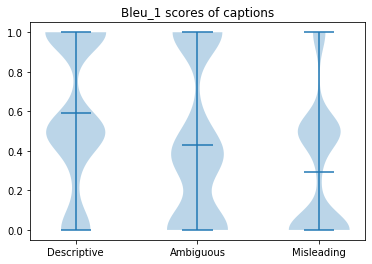

(-0.39089840901067446, 4.200943216884456e-89)


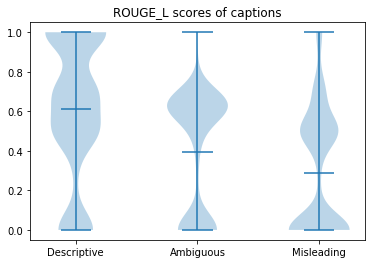

(-0.3868147887954103, 3.8982827479685736e-87)


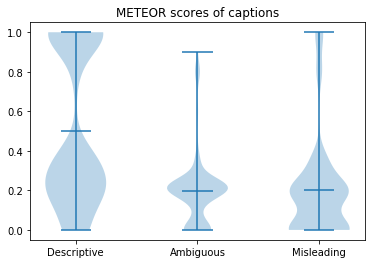

(-0.3649181185344329, 4.721350823598414e-77)


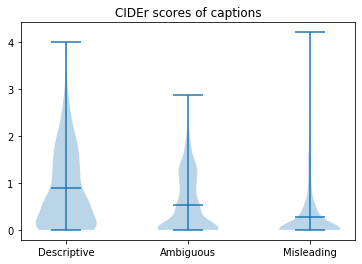

(-0.49581137232033623, 3.148412041131279e-150)


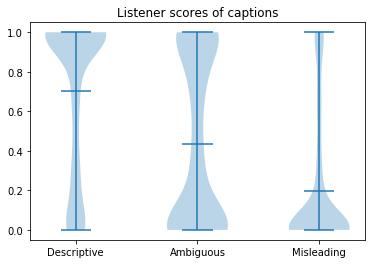

(-0.4854936410147345, 3.1880678372015494e-143)


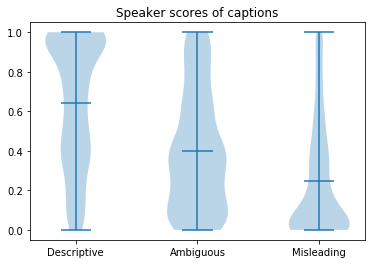

In [736]:
# DO NOT RUN - Original Notebook Results
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener', 'Speaker']
# all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_flipped_metrics_comb1234_filtered, bad_flipped_metrics_comb1234_filtered,
                      ugly_flipped_metrics_comb1234_filtered], metric)

In [61]:
# ok, now let's make the same plots but with the filtered unflipped data:
# get word overlap scores
good_unflipped_metrics_comb1234_filtered = get_overlap_scores(ref_captions_unflipped_comb1234_good_filtered, good_captions_unflipped_comb1234_filtered)
bad_unflipped_metrics_comb1234_filtered = get_overlap_scores(ref_captions_unflipped_comb1234_bad_filtered, bad_captions_unflipped_comb1234_filtered)
ugly_unflipped_metrics_comb1234_filtered = get_overlap_scores(ref_captions_unflipped_comb1234_ugly_filtered, ugly_captions_unflipped_comb1234_filtered)


In [62]:
# listener and speaker scores
# get listener scores
good_unflipped_scores_comb1234_filtered = listener_assessment(ctx_good_unflipped_comb1234_filtered)
bad_unflipped_scores_comb1234_filtered = listener_assessment(ctx_bad_unflipped_comb1234_filtered)
ugly_unflipped_scores_comb1234_filtered = listener_assessment(ctx_ugly_unflipped_comb1234_filtered)

# get speaker scores
good_unflipped_scores_comb1234_speaker_filtered = speaker_assessment(ctx_good_unflipped_comb1234_filtered)
bad_unflipped_scores_comb1234_speaker_filtered = speaker_assessment(ctx_bad_unflipped_comb1234_filtered)
ugly_unflipped_scores_comb1234_speaker_filtered = speaker_assessment(ctx_ugly_unflipped_comb1234_filtered)



In [63]:
add_score_to_metric(good_unflipped_scores_comb1234_filtered, good_unflipped_metrics_comb1234_filtered, name='Literal Listener')
add_score_to_metric(bad_unflipped_scores_comb1234_filtered, bad_unflipped_metrics_comb1234_filtered, name='Literal Listener')
add_score_to_metric(ugly_unflipped_scores_comb1234_filtered, ugly_unflipped_metrics_comb1234_filtered, name='Literal Listener')

add_score_to_metric(good_unflipped_scores_comb1234_speaker_filtered, good_unflipped_metrics_comb1234_filtered, name="Pragmatic Listener")
add_score_to_metric(bad_unflipped_scores_comb1234_speaker_filtered, bad_unflipped_metrics_comb1234_filtered, name="Pragmatic Listener")
add_score_to_metric(ugly_unflipped_scores_comb1234_speaker_filtered, ugly_unflipped_metrics_comb1234_filtered, name="Pragmatic Listener")

(-0.1392800654691834, 1.4255227249159803e-11)
SpearmanrResult(correlation=-0.1497268479336702, pvalue=3.6605824706714905e-13)
KendalltauResult(correlation=-0.1295000411054949, pvalue=5.3106240566160577e-14)


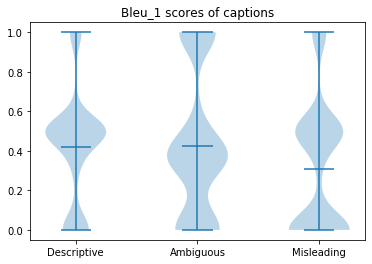

(-0.19490494666999722, 2.1335392717512677e-21)
SpearmanrResult(correlation=-0.21012572224330336, pvalue=1.107526574904657e-24)
KendalltauResult(correlation=-0.17854803696887012, pvalue=5.723584256462242e-24)


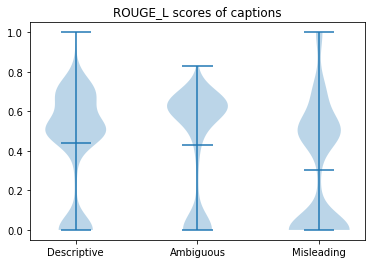

(-0.11729959795556634, 1.3385139136121455e-08)
SpearmanrResult(correlation=-0.2397406599072085, pvalue=7.697711284736952e-32)
KendalltauResult(correlation=-0.20207442460781752, pvalue=2.9156725759698117e-32)


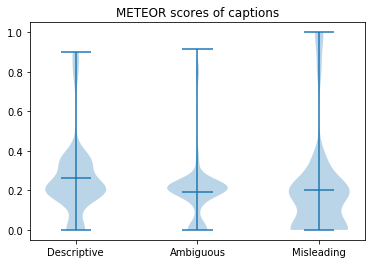

(-0.1274748220487936, 6.501057120515883e-10)
SpearmanrResult(correlation=-0.20731214938252862, pvalue=4.692494762441354e-24)
KendalltauResult(correlation=-0.16039675425598976, pvalue=5.364609851878029e-22)


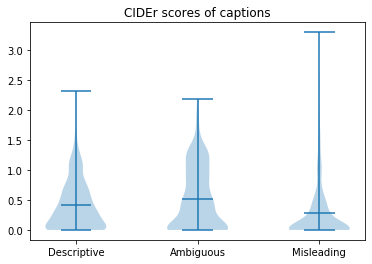

(-0.47139085747505527, 2.5075965111792844e-129)
SpearmanrResult(correlation=-0.5103978844924169, pvalue=6.586457387953135e-155)
KendalltauResult(correlation=-0.39821155736085195, pvalue=5.484251652226929e-137)


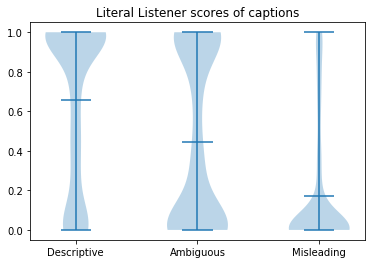

(-0.4668640146379977, 1.4414741114284072e-126)
SpearmanrResult(correlation=-0.47383678091082154, pvalue=7.777712613727062e-131)
KendalltauResult(correlation=-0.3737781546548331, pvalue=2.95151696008918e-121)


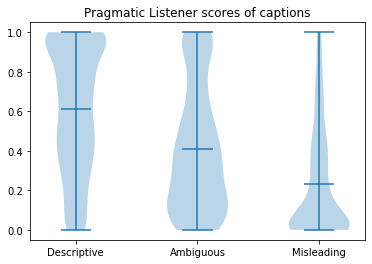

In [64]:
# Notebook Copy
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Literal Listener', 'Pragmatic Listener']
# all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics_comb1234_filtered, bad_unflipped_metrics_comb1234_filtered,
                      ugly_unflipped_metrics_comb1234_filtered], metric)

(-0.1392800654691834, 1.4255227249159803e-11)
SpearmanrResult(correlation=-0.1497268479336702, pvalue=3.6605824706714905e-13)
KendalltauResult(correlation=-0.1295000411054949, pvalue=5.3106240566160577e-14)


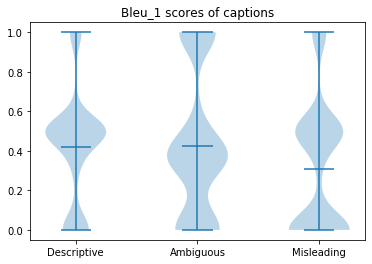

(-0.19490494666999722, 2.1335392717512677e-21)
SpearmanrResult(correlation=-0.21012572224330336, pvalue=1.107526574904657e-24)
KendalltauResult(correlation=-0.17854803696887012, pvalue=5.723584256462242e-24)


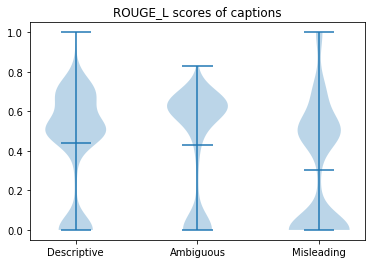

(-0.11729959795556634, 1.3385139136121455e-08)
SpearmanrResult(correlation=-0.2397406599072085, pvalue=7.697711284736952e-32)
KendalltauResult(correlation=-0.20207442460781752, pvalue=2.9156725759698117e-32)


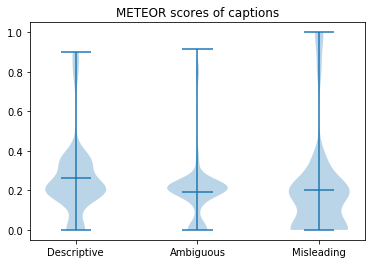

(-0.1274748220487936, 6.501057120515883e-10)
SpearmanrResult(correlation=-0.20731214938252862, pvalue=4.692494762441354e-24)
KendalltauResult(correlation=-0.16039675425598976, pvalue=5.364609851878029e-22)


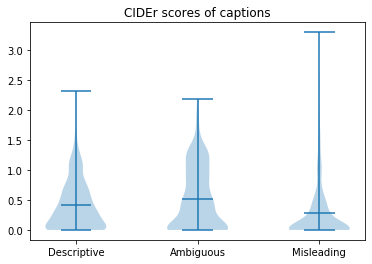

(-0.471390865505846, 2.507568031354975e-129)
SpearmanrResult(correlation=-0.5103970708331365, pvalue=6.5950918559097905e-155)
KendalltauResult(correlation=-0.39821214531205185, pvalue=5.484221017222727e-137)


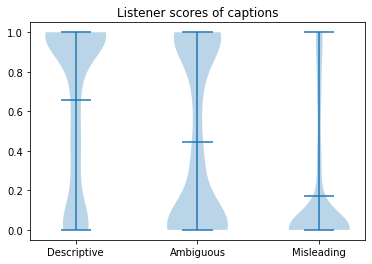

(-0.4668640146379977, 1.4414741114284072e-126)
SpearmanrResult(correlation=-0.47383678091082154, pvalue=7.777712613727062e-131)
KendalltauResult(correlation=-0.3737781546548331, pvalue=2.95151696008918e-121)


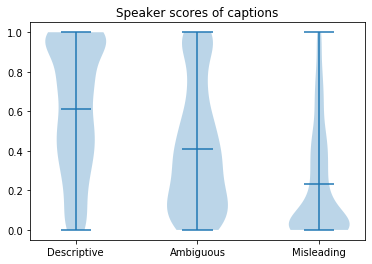

In [1117]:
# DO NOT RUN - Original Notebook Results
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener', 'Speaker']
# all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics_comb1234_filtered, bad_unflipped_metrics_comb1234_filtered,
                      ugly_unflipped_metrics_comb1234_filtered], metric)

In [1137]:
print(good_unflipped_metrics_comb1234_filtered.keys())

dict_keys(['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4', 'METEOR', 'ROUGE_L', 'CIDEr', 'Listener', 'Speaker', 'Literal Listener', 'Pragmatic Listener'])


In [65]:
# now let's combine the two:
good_metrics_comb1234_filtered = {}
bad_metrics_comb1234_filtered = {}
ugly_metrics_comb1234_filtered = {}

for metric in all_metrics:
    good_metrics_comb1234_filtered[metric] = (np.mean([good_unflipped_metrics_comb1234_filtered[metric][0], 
                                                       good_flipped_metrics_comb1234_filtered[metric][0]]),
            np.concatenate((good_unflipped_metrics_comb1234_filtered[metric][1], good_flipped_metrics_comb1234_filtered[metric][1])))
    bad_metrics_comb1234_filtered[metric] = (np.mean([bad_unflipped_metrics_comb1234_filtered[metric][0], 
                                                       bad_flipped_metrics_comb1234_filtered[metric][0]]),
            np.concatenate((bad_unflipped_metrics_comb1234_filtered[metric][1], bad_flipped_metrics_comb1234_filtered[metric][1])))
    ugly_metrics_comb1234_filtered[metric] = (np.mean([ugly_unflipped_metrics_comb1234_filtered[metric][0], 
                                                       ugly_flipped_metrics_comb1234_filtered[metric][0]]),
            np.concatenate((ugly_unflipped_metrics_comb1234_filtered[metric][1], ugly_flipped_metrics_comb1234_filtered[metric][1])))
                                              

(-0.14816026781519528, 6.136131021277062e-24)
SpearmanrResult(correlation=-0.16236261505180238, pvalue=1.767381364107753e-28)
KendalltauResult(correlation=-0.13879466957032852, pvalue=1.104342684489571e-29)


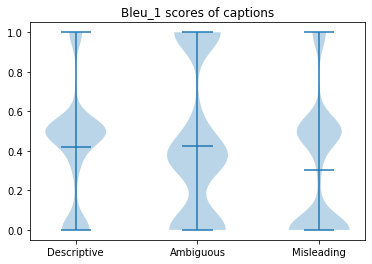

(-0.20563831909372568, 5.237901836935926e-45)
SpearmanrResult(correlation=-0.22609275506419538, pvalue=2.8274513563250236e-54)
KendalltauResult(correlation=-0.19365411202565805, pvalue=2.869135278904024e-53)


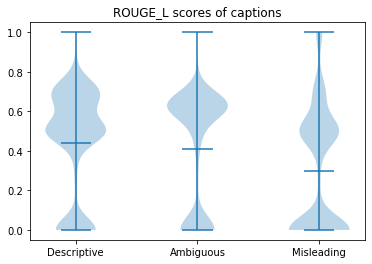

(-0.120003722438814, 3.446245762592903e-16)
SpearmanrResult(correlation=-0.23894762176983267, pvalue=1.3567419316033444e-60)
KendalltauResult(correlation=-0.2011266503802974, pvalue=2.979019478923855e-61)


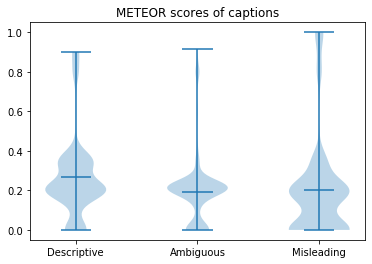

(-0.1468812282088798, 1.4991018010978947e-23)
SpearmanrResult(correlation=-0.22536235473712368, pvalue=6.293093274256711e-54)
KendalltauResult(correlation=-0.17587525493746334, pvalue=2.0368331950656978e-49)


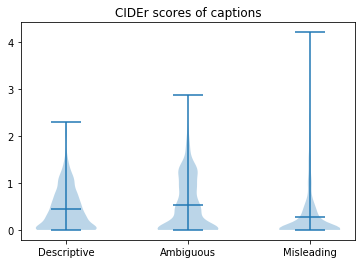

(-0.4746870944260331, 1.2202200962132881e-256)
SpearmanrResult(correlation=-0.5097442142214187, pvalue=4.6019798102760625e-302)
KendalltauResult(correlation=-0.3985921268369274, pvalue=4.107020571581948e-268)


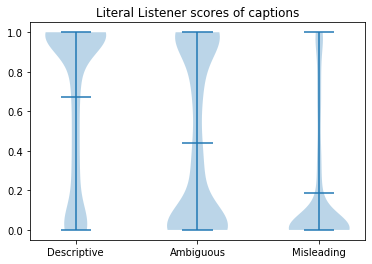

(-0.46005200209851826, 3.4348522786771536e-239)
SpearmanrResult(correlation=-0.46701104302489876, pvalue=2.211398736384685e-247)
KendalltauResult(correlation=-0.3689345053276601, pvalue=1.167595551984055e-230)


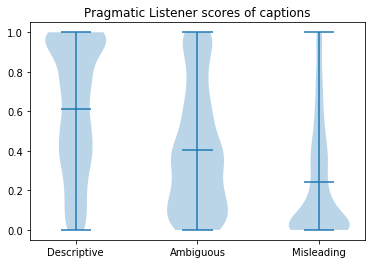

In [66]:
# Notebook Copy - NOT SAME AS ABOVE
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Literal Listener', 'Pragmatic Listener']
# all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_metrics_comb1234_filtered, bad_metrics_comb1234_filtered,
                      ugly_metrics_comb1234_filtered], metric)

(-0.3107922337687109, 7.537358667738756e-110)
SpearmanrResult(correlation=-0.30342380549751735, pvalue=1.5317462012513488e-104)
KendalltauResult(correlation=-0.2569498934326451, pvalue=1.6508152606818168e-104)


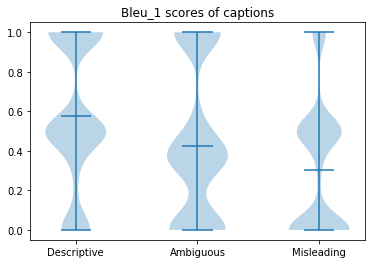

(-0.36877445587717034, 3.3648593208646187e-157)
SpearmanrResult(correlation=-0.37172977870649015, pvalue=6.838440553492899e-160)
KendalltauResult(correlation=-0.323674507383133, pvalue=3.861766090720254e-158)


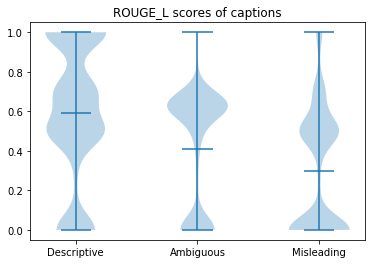

(-0.36784592216577167, 2.327817097994524e-156)
SpearmanrResult(correlation=-0.3831374463214339, pvalue=1.4994944690506423e-170)
KendalltauResult(correlation=-0.3245478406751614, pvalue=4.328060980015291e-168)


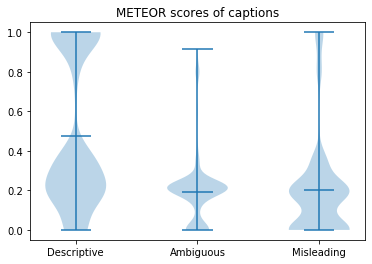

(-0.33922943980207376, 8.378997238957957e-132)
SpearmanrResult(correlation=-0.35408204521266307, pvalue=3.1348741546701195e-144)
KendalltauResult(correlation=-0.2855621866807747, pvalue=1.0188760141116511e-136)


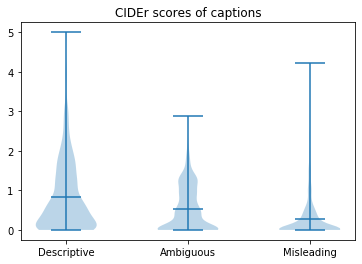

(-0.4880211180046037, 9.816235677179433e-291)
SpearmanrResult(correlation=-0.5265218108109966, pvalue=0.0)
KendalltauResult(correlation=-0.41268528877171917, pvalue=4.891667844161399e-305)


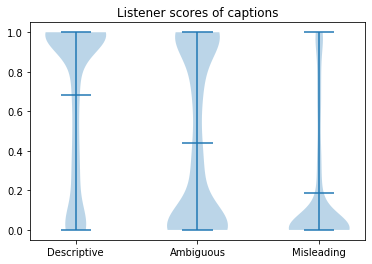

(-0.4877773556491923, 2.1042730568396158e-290)
SpearmanrResult(correlation=-0.4946073625182945, pvalue=8.748808986510839e-300)
KendalltauResult(correlation=-0.3912271435004961, pvalue=1.9739492202494632e-275)


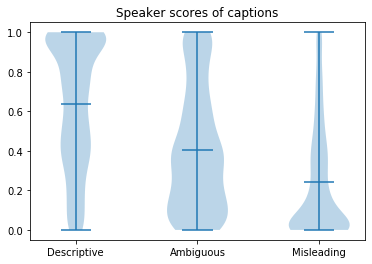

In [751]:
# DO NOT RUN - Original Notebook Results
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Listener', 'Speaker']
# all_metrics = ['Listener', 'Speaker']
for metric in all_metrics:
    plot_score_dists([good_metrics_comb1234_filtered, bad_metrics_comb1234_filtered,
                      ugly_metrics_comb1234_filtered], metric)

In [ ]:
# ok, that filtering actually seemed to help somewhat. There might be more to do, but for now I'm going to 
# keep it the way it is.

# For now, I'm going to say that these are done. This concludes the section with just the data we collected, and now
# I'm going to go on to augment our data with as much other dev-set data as I can.

# A note: I can really only augment the data for the misleading and descriptive sections because everyone was 
# trying to be informative in that scenario. Because of that, the ambiguous (bad) descriptions aren't going to change
# at all. Maybe it would be better to leave them out?

# Also, I will be building on top of the FILTERED data, so any changes that are made to that will have to be propogated
# to here as well.



In [67]:
from collections import defaultdict
import pickle as pkl

with open("../data/metric_comparison_indices/dev_evaluation_indices.pkl", "rb") as pfile:
     dev_eval_indices = pkl.load(pfile)
        
dev_eval_triples = np.array(dev_eval_indices) - 15665

ctx_good_unflipped_monroe = defaultdict(set) # to use our listener/speaker metrics, we just have to put the values into a list
ctx_good_flipped_monroe = defaultdict(set)

for triple in dev_eval_triples:
    # triple = [ref, bad, good]
    ref_id, bad_id, good_id = triple
    if ref_id in dev_data_indices: # we gave the reference to turkers for augmentation
        ctx_good_unflipped_monroe[ref_id].add(ref_id)
        ctx_good_unflipped_monroe[ref_id].add(good_id)
        ctx_good_flipped_monroe[ref_id].add(bad_id)

In [68]:
with open("../data/metric_comparison_indices/dev_evaluation_indices.pkl", "rb") as pfile:
     dev_eval_indices = pkl.load(pfile)

In [69]:
dev_eval_triples = np.array(dev_eval_indices) - len(train_data)

In [70]:
from collections import defaultdict

In [71]:
ctx_good_unflipped_monroe = defaultdict(set) # to use our listener/speaker metrics, we just have to put the values into a list
ctx_good_flipped_monroe = defaultdict(set)

for triple in dev_eval_triples:
    # triple = [ref, bad, good]
    ref_id, bad_id, good_id = triple
    if ref_id in dev_data_indices: # we gave the reference to turkers for augmentation
        ctx_good_unflipped_monroe[ref_id].add(ref_id)
        ctx_good_unflipped_monroe[ref_id].add(good_id)
        ctx_good_flipped_monroe[ref_id].add(bad_id)

In [72]:
len(ctx_good_unflipped_comb1234_filtered)

766

In [73]:
ctx_good_unflipped_comb1234_filtered[:5] # no duplicates in filtered...

[Bright pink, MEDIUM VIOLET RED, Light pink, bright purple, Dark grey]

In [74]:
ctx_good_unflipped_comb1234[:5]

[bright pink, MEDIUM VIOLET RED, Light pink, Bright pink, bright purple]

In [75]:
# for word overlap metrics, we have to update the reference captions and add more good / ugly captions
ref_captions_unflipped_1234monroe = []
ctx_good_unflipped_1234monroe_2 = []


for i, dev_idx in enumerate(dev_data_indices[:len(mturk_data_combined_1234)//20]): # explaination of 20 above
    # access i's references in the newly collected data, don't worry about filtering because all of the good
    # samples are there. We can just append to reference captions and then do the filtering again I guess
    
    # at the beginning, before filtering, ref captions has 5 repeated captions
    len([normalize(dev_data[ci].caption) for ci in ctx_good_unflipped_monroe[dev_idx]])
    reference = ref_captions_unflipped_comb1234[5*i] + [normalize(dev_data[ci].caption) for ci in ctx_good_unflipped_monroe[dev_idx]]
    ref_captions_unflipped_1234monroe.append(reference)
    
    reference_ctxs = copy.deepcopy(ctx_good_unflipped_comb1234[5*i: 5*i + 5]) + [copy.deepcopy(dev_data[ci]) for ci in ctx_good_unflipped_monroe[dev_idx]]
    ctx_good_unflipped_1234monroe_2.extend(reference_ctxs)
    


In [76]:
len(ref_captions_unflipped_1234monroe)

180

In [77]:
len(ctx_good_unflipped_1234monroe_2)

1144

In [78]:
ctx_good_unflipped_1234monroe_2[:10]

[bright pink,
 MEDIUM VIOLET RED,
 Light pink,
 Bright pink,
 bright purple,
 brightest color,
 Lightest shade,
 dark grey,
 DIM GRAY,
 Dark grey]

In [79]:
len(ctx_good_unflipped_1234monroe)

NameError: name 'ctx_good_unflipped_1234monroe' is not defined

In [80]:
# get the good (descriptive) captions
ref_captions_unflipped_good_1234monroe = []
good_captions_unflipped_1234monroe = []


for references in ref_captions_unflipped_1234monroe:
    for i in range(len(references)):
        good_captions_unflipped_1234monroe.append(references[i])
        ref_captions_unflipped_good_1234monroe.append(references[:i] + references[i+1:])

    

In [81]:
max([len(c) for i, c in enumerate(ref_captions_unflipped_good_1234monroe)])

11

In [82]:
len(good_captions_unflipped_1234monroe)

1144

In [83]:
# now we can get the ugly ones. This is going to involve filtering:
ref_captions_unflipped_ugly_1234monroe = []
ugly_captions_unflipped_1234monroe = []
ctx_ugly_unflipped_1234monroe_2 = []

def filter_ugly_captions(i, captions, reference, ctxs):
    """remove captions in reference set (in far condition)"""
    new_captions = []

    for j in range(len(captions)):
        if not (captions[j] in reference and ctxs[5*i].condition == "far"):
            new_captions.append(captions[j])

    return new_captions

# we have 5 from the augmented data and ctx_good_flipped_monroe[dev_idx] from the original data
for i, dev_idx in enumerate(dev_data_indices[:len(mturk_data_combined_1234)//20]): # explaination of 20 above (5 replicates * 2 good/bad * 2 flipped/unflipped)
    
    reference = ref_captions_unflipped_1234monroe[i]
    
    # 5 replicates from our augmentation
    #references = [reference for _ in range(5)]
    ugly_captions = (ugly_captions_unflipped_comb1234[5*i: 5*(i+1)] + # our data (not filtered)
                     [normalize(dev_data[ci].caption) for ci in ctx_good_flipped_monroe[dev_idx]] )# monroe data
    
    
    # filter: remove duplicates and remove captions in reference captions if in far condition (these are mistakes)
    ugly_captions = filter_ugly_captions(i, ugly_captions, reference, ctx_ugly_unflipped_comb1234)
    #print(len(ugly_captions))
    # replicates from original Monroe Data
    references = [reference for _ in range(len(ugly_captions))]
    ugly_captions_unflipped_1234monroe.extend(ugly_captions)
    ref_captions_unflipped_ugly_1234monroe.extend(references)
    
    # now let's also add the misleading contexts that we have from monroe data
    ugly_ctxs = (copy.deepcopy(ctx_ugly_unflipped_comb1234[5*i: 5*(i+1)]) + 
                    [copy.deepcopy(dev_data[ci]) for ci in ctx_good_flipped_monroe[dev_idx]] )# monroe data
    ugly_ctxs = list(filter(lambda ctx: normalize(ctx.caption) in ugly_captions, ugly_ctxs))
    #print(ugly_captions)
    ctx_ugly_unflipped_1234monroe_2.extend(ugly_ctxs)

In [84]:
len(ctx_ugly_flipped_comb1234)

900

In [85]:
len(ctx_ugly_flipped_comb1234_filtered)

882

In [86]:
len(ugly_captions_unflipped_1234monroe)

1104

In [87]:
# now let's get the flipped references
ref_captions_flipped_1234monroe = []
ctx_good_flipped_1234monroe_2 = []

for i, dev_idx in enumerate(dev_data_indices[:len(mturk_data_combined_1234)//20]): # explaination of 20 above
    # access i's references in the newly collected data, don't worry about filtering because all of the good
    # samples are there. We can just append to reference captions and then do the filtering again I guess
    
    # at the beginning, before filtering, ref captions has 5 repeated captions
    # note that we don't filter any of the reference utterances
    reference = ref_captions_flipped_comb1234[5*i] + [normalize(dev_data[ci].caption) for ci in ctx_good_flipped_monroe[dev_idx]]
    ref_captions_flipped_1234monroe.append(reference)
    
    # get the good contexts as well
    reference_ctxs = copy.deepcopy(ctx_good_flipped_comb1234[5*i: 5*i + 5]) + [copy.deepcopy(dev_data[ci]) for ci in ctx_good_flipped_monroe[dev_idx]]
    ctx_good_flipped_1234monroe_2.extend(reference_ctxs)
    
# get the good (descriptive) captions
ref_captions_flipped_good_1234monroe_filtered = []
good_captions_flipped_1234monroe_filtered = []

for references in ref_captions_flipped_1234monroe:
    for i in range(len(references)):
        good_captions_flipped_1234monroe_filtered.append(references[i])
        ref_captions_flipped_good_1234monroe_filtered.append(references[:i] + references[i+1:])

# get the ugly (misleading captions) 
ref_captions_flipped_ugly_1234monroe_filtered = []
ugly_captions_flipped_1234monroe_filtered = []
ctx_ugly_flipped_1234monroe_2 = []

# we have 5 from the augmented data and ctx_good_flipped_monroe[dev_idx] from the original data
for i, dev_idx in enumerate(dev_data_indices[:len(mturk_data_combined_1234)//20]): # explaination of 20 above (5 replicates * 2 good/bad * 2 flipped/unflipped)
    
    reference = ref_captions_flipped_1234monroe[i]
    
    # 5 replicates from our augmentation
    #references = [reference for _ in range(5)]
    ugly_captions = (ugly_captions_flipped_comb1234[5*i: 5*(i+1)] + # our data (not filtered)
                     [normalize(dev_data[ci].caption) for ci in ctx_good_unflipped_monroe[dev_idx]] )# monroe data
    
    
    # filter: remove duplicates and remove captions in reference captions if in far condition (these are mistakes)
    ugly_captions = filter_ugly_captions(i, ugly_captions, reference, ctx_ugly_flipped_comb1234)

    # replicates from original Monroe Data
    references = [reference for _ in range(len(ugly_captions))]
    ugly_captions_flipped_1234monroe_filtered.extend(ugly_captions)
    ref_captions_flipped_ugly_1234monroe_filtered.extend(references)
    
    # now let's also add the misleading contexts that we have from monroe data
    ugly_ctxs = (copy.deepcopy(ctx_ugly_flipped_comb1234[5*i: 5*(i+1)]) + 
                    [copy.deepcopy(dev_data[ci]) for ci in ctx_good_unflipped_monroe[dev_idx]] )# monroe data - should this be flipped???
    ugly_ctxs = list(filter(lambda ctx: normalize(ctx.caption) in ugly_captions, ugly_ctxs))
    # print(ugly_captions)
    ctx_ugly_flipped_1234monroe_2.extend(ugly_ctxs)

In [88]:
len(ctx_ugly_flipped_1234monroe_2)

1126

In [89]:
# now let's run the word overlap metrics
good_unflipped_metrics_1234monroe_filtered = get_overlap_scores(ref_captions_unflipped_good_1234monroe, good_captions_unflipped_1234monroe)
ugly_unflipped_metrics_1234monroe_filtered = get_overlap_scores(ref_captions_unflipped_ugly_1234monroe, ugly_captions_unflipped_1234monroe)

good_flipped_metrics_1234monroe_filtered = get_overlap_scores(ref_captions_flipped_good_1234monroe_filtered, good_captions_flipped_1234monroe_filtered)
ugly_flipped_metrics_1234monroe_filtered = get_overlap_scores(ref_captions_flipped_ugly_1234monroe_filtered, ugly_captions_flipped_1234monroe_filtered)





In [90]:
# Originally 5.785610970028209, I'm not sure why this changed...
np.mean([np.mean([len(c) for c in ref_captions_unflipped_good_1234monroe]),
 np.mean([len(c) for c in ref_captions_unflipped_comb1234_bad_filtered]),
 np.mean([len(c) for c in ref_captions_unflipped_ugly_1234monroe]),
 np.mean([len(c) for c in ref_captions_flipped_good_1234monroe_filtered]),
 np.mean([len(c) for c in ref_captions_flipped_comb1234_bad_filtered]),
 np.mean([len(c) for c in ref_captions_flipped_ugly_1234monroe_filtered]),
        ])

5.77205001211486

In [91]:
len(good_captions_unflipped_comb1234_filtered) + len(good_captions_flipped_comb1234_filtered)

1505

In [92]:
len(good_captions_unflipped_1234monroe) + len(good_captions_flipped_1234monroe_filtered)

2261

In [1169]:
good_captions_unflipped_1234monroe[:10]

['bright pink',
 'medium violet red',
 'light pink',
 'bright pink',
 'bright purple',
 'brightest color',
 'lightest shade',
 'dark grey',
 'dim gray',
 'dark grey']

In [1126]:
1902*2 + 1315

5119

In [93]:
# now let's combine the two:
good_metrics_1234monroe_filtered = {}
ugly_metrics_1234monroe_filtered = {}

for metric in all_metrics[:-2]:
    good_metrics_1234monroe_filtered[metric] = (np.mean([good_unflipped_metrics_1234monroe_filtered[metric][0], 
                                                       good_flipped_metrics_1234monroe_filtered[metric][0]]),
            np.concatenate((good_unflipped_metrics_1234monroe_filtered[metric][1], good_flipped_metrics_1234monroe_filtered[metric][1])))
    ugly_metrics_1234monroe_filtered[metric] = (np.mean([ugly_unflipped_metrics_1234monroe_filtered[metric][0], 
                                                       ugly_flipped_metrics_1234monroe_filtered[metric][0]]),
            np.concatenate((ugly_unflipped_metrics_1234monroe_filtered[metric][1], ugly_flipped_metrics_1234monroe_filtered[metric][1])))
                                              

(-0.29125373756634354, 6.83707095973673e-114)
SpearmanrResult(correlation=-0.28161631169720674, pvalue=2.690186960611173e-106)
KendalltauResult(correlation=-0.23555248245705468, pvalue=1.3156351485735754e-105)


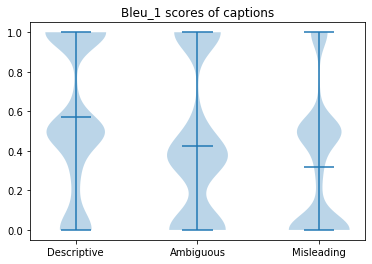

(-0.35645641292188773, 1.5942467598993691e-173)
SpearmanrResult(correlation=-0.35620194381059517, pvalue=2.9151749377602417e-173)
KendalltauResult(correlation=-0.3061688871134749, pvalue=2.9446535051073274e-171)


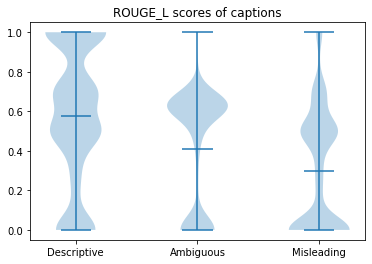

(-0.37330978249177765, 1.9921180564688828e-191)
SpearmanrResult(correlation=-0.37962613021267194, pvalue=2.033866527430056e-198)
KendalltauResult(correlation=-0.31748249192318984, pvalue=6.06166063677614e-194)


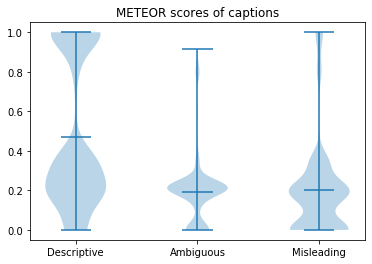

(-0.3325644271697033, 6.007826026680586e-150)
SpearmanrResult(correlation=-0.34051841843648983, pvalue=1.4425227808187668e-157)
KendalltauResult(correlation=-0.2718208447119834, pvalue=2.515273184234204e-147)


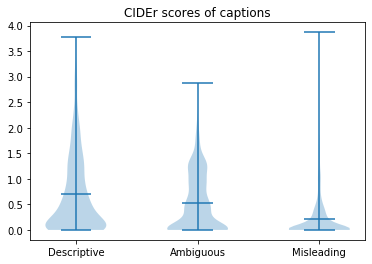

In [94]:
# Notebook Copy - NOT SAME AS BELOW
for metric in all_metrics[:-2]:
    plot_score_dists([good_metrics_1234monroe_filtered, bad_metrics_comb1234_filtered,
                      ugly_metrics_1234monroe_filtered], metric)

(-0.28630118470950056, 7.572081225210919e-104)
SpearmanrResult(correlation=-0.28452262906549397, pvalue=1.571067319165255e-102)
KendalltauResult(correlation=-0.23743153263541356, pvalue=9.207691636867017e-102)


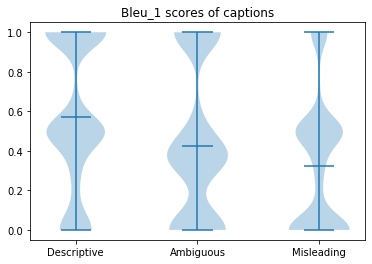

(-0.34436589930205014, 2.4845200945147424e-152)
SpearmanrResult(correlation=-0.3449095479715478, pvalue=7.743166812661134e-153)
KendalltauResult(correlation=-0.2956146069375284, pvalue=9.503768019793277e-152)


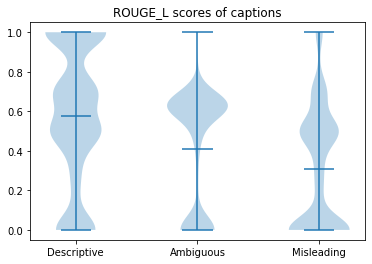

(-0.3619886349925958, 2.8884696388103e-169)
SpearmanrResult(correlation=-0.36699055927775726, pvalue=2.8483864085415006e-174)
KendalltauResult(correlation=-0.3057051725726034, pvalue=1.086069775606445e-170)


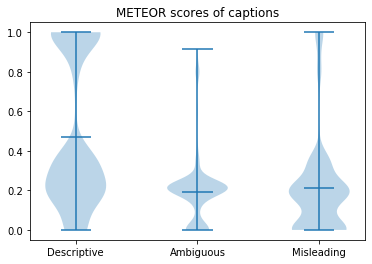

(-0.32007085841910665, 1.0174012440277558e-130)
SpearmanrResult(correlation=-0.3297318569465286, pvalue=4.451650162677396e-139)
KendalltauResult(correlation=-0.2621258373617462, pvalue=2.261986339921834e-130)


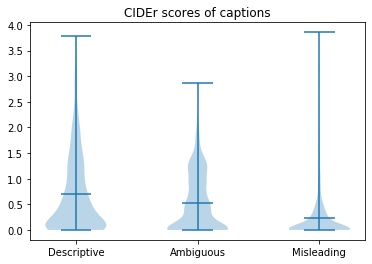

In [1172]:
# ORIGINAL NOTEBOOK - DO NOT RUN
for metric in all_metrics[:-2]:
    plot_score_dists([good_metrics_1234monroe_filtered, bad_metrics_comb1234_filtered,
                      ugly_metrics_1234monroe_filtered], metric)

In [ ]:
# flipped's good is unflipped's ugly (and vice versa)

In [1286]:
# # I THINK ALL OF THIS MIGHT BE JUNK, BUT CAN UNCOMMENT TO CHECK
# # now we have to prepare our lists for speaker evaluations. Everything here is evaluated without references
# # so we don't have to worry about the order of things
# # Also, side note, this code is extremely ugly and I probably should have looked into some kind of data manager
# ctx_good_unflipped_monroe_list = []
# ctx_ugly_unflipped_monroe_list = []

# ctx_good_flipped_monroe_list = []
# ctx_ugly_flipped_monroe_list = []
# for dev_id in ctx_good_unflipped_monroe:
#     if not dev_id in dev_data_indices[:len(mturk_data_combined_1234)//20]:
#         continue
#     # first unflipped
#     good_contexts = [dev_data[cid] for cid in ctx_good_unflipped_monroe[dev_id]]
#     ctx_good_unflipped_monroe_list.extend(good_contexts) # note: unflipped
    
#     ugly_contexts = [copy.deepcopy(dev_data[cid]) for cid in ctx_good_flipped_monroe[dev_id]] # note: flipped
#     for i in range(len(ugly_contexts)):
#         ugly_contexts[i].colors = good_contexts[0].colors
        
#     ctx_ugly_unflipped_monroe_list.extend(ugly_contexts) # note: unflipped
    
#     # then flipped - same code, just reassign variables
#     good_contexts_flipped = [dev_data[cid] for cid in ctx_good_flipped_monroe[dev_id]]
#     ctx_good_flipped_monroe_list.extend(good_contexts_flipped) # note: flipped
    
#     ugly_contexts_flipped = [copy.deepcopy(dev_data[cid]) for cid in ctx_good_unflipped_monroe[dev_id]] # note: unflipped
#     for i in range(len(ugly_contexts_flipped)):
#         ugly_contexts_flipped[i].colors = good_contexts_flipped[0].colors
        
#     ctx_ugly_flipped_monroe_list.extend(ugly_contexts_flipped) # note: flipeed
    
# # ctx_good_unflipped_1234monroe = ctx_good_unflipped_monroe_list + ctx_good_unflipped_comb1234_filtered


# # ctx_good_flipped_monroe_list = []
# # for contexts in ctx_good_flipped_monroe.values():
# #     ctx_good_flipped_monroe_list.extend(list(contexts))
    
# # ctx_good_flipped_1234monroe = ctx_good_flipped_monroe_list + ctx_good_flipped_comb1234_filtered


In [95]:
len(ctx_good_unflipped_monroe_list) # 244

NameError: name 'ctx_good_unflipped_monroe_list' is not defined

In [96]:
count = 0
for idxs in ctx_good_unflipped_monroe.values():
    count += len(idxs)

In [97]:
count

1399

In [1278]:
ctx_good_flipped_monroe

defaultdict(set,
            {205: {2133, 12080},
             219: {2263, 13360},
             259: {5494, 5692, 10662},
             646: {7901, 11073},
             866: {4528, 13727},
             1074: {1599, 4960, 7369, 7666, 8401, 8896, 11450, 15291},
             1499: {4566, 6843},
             1533: {4350, 4478, 14416},
             1858: {3620, 5345, 5964, 7812, 13727},
             2196: {3083, 15660},
             3118: {3746, 8215, 11847, 12225, 15530},
             3657: {5621, 15291},
             3729: {4704, 6976, 7666, 7796, 7901, 8044, 9950},
             4216: {7290},
             4229: {4802},
             4656: {5383, 8881, 11495},
             5396: {5621, 6654, 8362, 8905, 12225},
             5450: {6070},
             5671: {14467, 15198},
             6362: {7150, 8905},
             7368: {7666, 8362},
             7391: {9332},
             8243: {10352, 11091, 12652},
             8817: {14406},
             9109: {14406},
             9463: {13627},
    

In [98]:
len(ctx_good_unflipped_monroe_list) # 1399

NameError: name 'ctx_good_unflipped_monroe_list' is not defined

In [99]:
len(ctx_good_unflipped_comb1234)

900

In [1031]:
# THIS TOO I THINK
# ctx_good_unflipped_1234monroe = ctx_good_unflipped_monroe_list + ctx_good_unflipped_comb1234_filtered
# ctx_ugly_unflipped_1234monroe = ctx_ugly_unflipped_monroe_list + ctx_ugly_unflipped_comb1234_filtered

# ctx_good_flipped_1234monroe = ctx_good_flipped_monroe_list + ctx_good_flipped_comb1234_filtered
# ctx_ugly_flipped_1234monroe = ctx_ugly_flipped_monroe_list + ctx_ugly_flipped_comb1234_filtered

In [100]:
len(ctx_good_unflipped_1234monroe) # this is 38 more than are given the other metrics...... maybe bc it's broken? 2299

NameError: name 'ctx_good_unflipped_1234monroe' is not defined

In [101]:
len(ctx_good_unflipped_1234monroe_2)

1144

In [102]:
# now let's run our listener/speaker evaluations
# get listener scores - unflipped
good_unflipped_scores_1234monroe_filtered = listener_assessment(ctx_good_unflipped_1234monroe_2)
ugly_unflipped_scores_1234monroe_filtered = listener_assessment(ctx_ugly_unflipped_1234monroe_2)

# get speaker scores - unflipped
good_unflipped_scores_1234monroe_speaker_filtered = speaker_assessment(ctx_good_unflipped_1234monroe_2)
ugly_unflipped_scores_1234monroe_speaker_filtered = speaker_assessment(ctx_ugly_unflipped_1234monroe_2)


# get listener scores - flipped
good_flipped_scores_1234monroe_filtered = listener_assessment(ctx_good_flipped_1234monroe_2)
ugly_flipped_scores_1234monroe_filtered = listener_assessment(ctx_ugly_flipped_1234monroe_2)

# get speaker scores - flipped
good_flipped_scores_1234monroe_speaker_filtered = speaker_assessment(ctx_good_flipped_1234monroe_2)
ugly_flipped_scores_1234monroe_speaker_filtered = speaker_assessment(ctx_ugly_flipped_1234monroe_2)

In [103]:
# unflipped
add_score_to_metric(good_unflipped_scores_1234monroe_filtered, good_unflipped_metrics_1234monroe_filtered, name="Literal Listener")
add_score_to_metric(ugly_unflipped_scores_1234monroe_filtered, ugly_unflipped_metrics_1234monroe_filtered, name="Literal Listener")

add_score_to_metric(good_unflipped_scores_1234monroe_speaker_filtered, good_unflipped_metrics_1234monroe_filtered, name="Pragmatic Listener")
add_score_to_metric(ugly_unflipped_scores_1234monroe_speaker_filtered, ugly_unflipped_metrics_1234monroe_filtered, name="Pragmatic Listener")


# flipped
add_score_to_metric(good_flipped_scores_1234monroe_filtered, good_flipped_metrics_1234monroe_filtered, name="Literal Listener")
add_score_to_metric(ugly_flipped_scores_1234monroe_filtered, ugly_flipped_metrics_1234monroe_filtered, name="Literal Listener")

add_score_to_metric(good_flipped_scores_1234monroe_speaker_filtered, good_flipped_metrics_1234monroe_filtered, name="Pragmatic Listener")
add_score_to_metric(ugly_flipped_scores_1234monroe_speaker_filtered, ugly_flipped_metrics_1234monroe_filtered, name="Pragmatic Listener")

In [104]:
# now let's combine the two:
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Literal Listener', 'Pragmatic Listener']


good_metrics_1234monroe_filtered = {}
ugly_metrics_1234monroe_filtered = {}

for metric in all_metrics:
    good_metrics_1234monroe_filtered[metric] = (np.mean([good_unflipped_metrics_1234monroe_filtered[metric][0], 
                                                       good_flipped_metrics_1234monroe_filtered[metric][0]]),
            np.concatenate((good_unflipped_metrics_1234monroe_filtered[metric][1], good_flipped_metrics_1234monroe_filtered[metric][1])))
    ugly_metrics_1234monroe_filtered[metric] = (np.mean([ugly_unflipped_metrics_1234monroe_filtered[metric][0], 
                                                       ugly_flipped_metrics_1234monroe_filtered[metric][0]]),
            np.concatenate((ugly_unflipped_metrics_1234monroe_filtered[metric][1], ugly_flipped_metrics_1234monroe_filtered[metric][1])))
                                              

In [105]:
good_metrics_1234monroe_filtered['Pragmatic Listener'] # avg: 0.5748206

(0.62654495,
 array([0.77766263, 0.00318254, 0.5587215 , ..., 0.42321044, 0.94112486,
        0.9470826 ], dtype=float32))

(-0.29125373756634354, 6.83707095973673e-114)
SpearmanrResult(correlation=-0.28161631169720674, pvalue=2.690186960611173e-106)
KendalltauResult(correlation=-0.23555248245705468, pvalue=1.3156351485735754e-105)


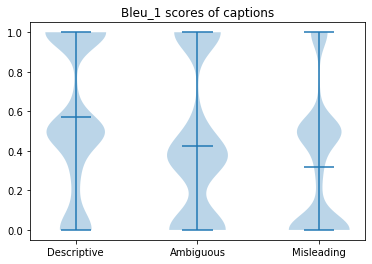

(-0.35645641292188773, 1.5942467598993691e-173)
SpearmanrResult(correlation=-0.35620194381059517, pvalue=2.9151749377602417e-173)
KendalltauResult(correlation=-0.3061688871134749, pvalue=2.9446535051073274e-171)


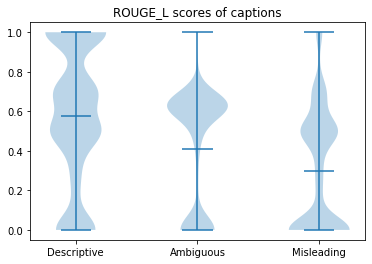

(-0.37330978249177765, 1.9921180564688828e-191)
SpearmanrResult(correlation=-0.37962613021267194, pvalue=2.033866527430056e-198)
KendalltauResult(correlation=-0.31748249192318984, pvalue=6.06166063677614e-194)


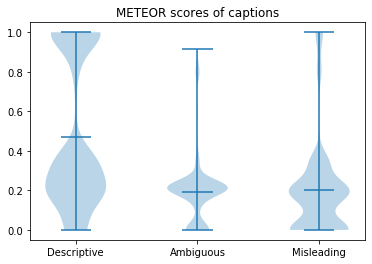

(-0.3325644271697033, 6.007826026680586e-150)
SpearmanrResult(correlation=-0.34051841843648983, pvalue=1.4425227808187668e-157)
KendalltauResult(correlation=-0.2718208447119834, pvalue=2.515273184234204e-147)


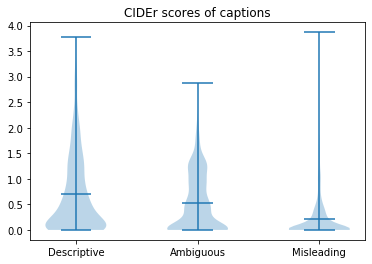

(-0.3949790538782586, 4.531450720396648e-216)
SpearmanrResult(correlation=-0.4289689114532966, pvalue=1.2303057467263083e-258)
KendalltauResult(correlation=-0.33686161191324715, pvalue=1.7201605336761883e-240)


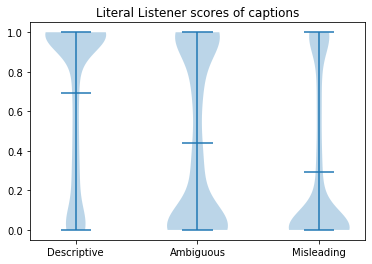

(-0.3984225570965594, 3.681915307796855e-220)
SpearmanrResult(correlation=-0.40528775999754607, pvalue=1.8419011569014836e-228)
KendalltauResult(correlation=-0.3201241998220258, pvalue=1.4047312229598695e-218)


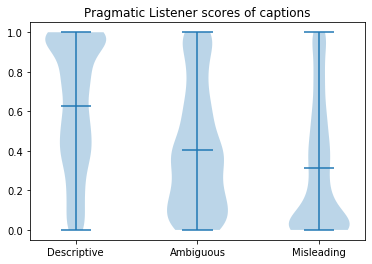

In [1343]:
# dataset sizes that make sense (with ugly repeats that I missed!)
for metric in all_metrics:
    plot_score_dists([good_metrics_1234monroe_filtered, bad_metrics_comb1234_filtered,
                      ugly_metrics_1234monroe_filtered], metric)

(-0.28630118470950056, 7.572081225210919e-104)
SpearmanrResult(correlation=-0.28452262906549397, pvalue=1.571067319165255e-102)
KendalltauResult(correlation=-0.23743153263541356, pvalue=9.207691636867017e-102)


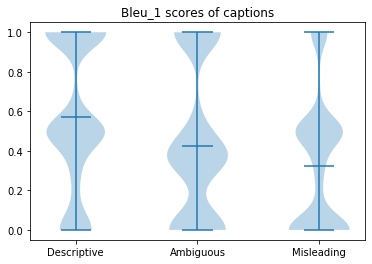

(-0.34436589930205014, 2.4845200945147424e-152)
SpearmanrResult(correlation=-0.3449095479715478, pvalue=7.743166812661134e-153)
KendalltauResult(correlation=-0.2956146069375284, pvalue=9.503768019793277e-152)


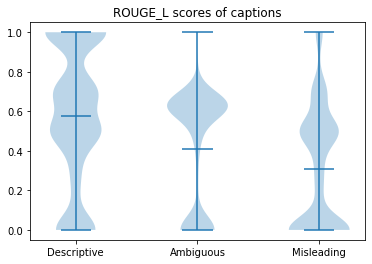

(-0.3619886349925958, 2.8884696388103e-169)
SpearmanrResult(correlation=-0.36699055927775726, pvalue=2.8483864085415006e-174)
KendalltauResult(correlation=-0.3057051725726034, pvalue=1.086069775606445e-170)


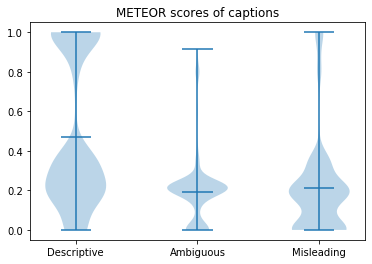

(-0.32007085841910665, 1.0174012440277558e-130)
SpearmanrResult(correlation=-0.3297318569465286, pvalue=4.451650162677396e-139)
KendalltauResult(correlation=-0.2621258373617462, pvalue=2.261986339921834e-130)


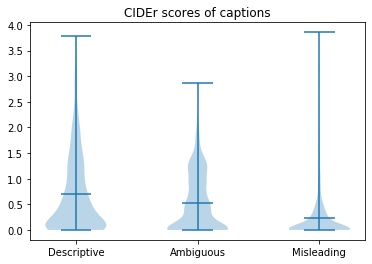

(-0.5534265315571435, 0.0)
SpearmanrResult(correlation=-0.5869390536015304, pvalue=0.0)
KendalltauResult(correlation=-0.463799505050465, pvalue=0.0)


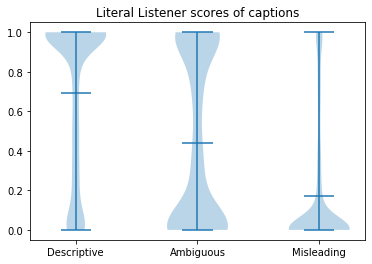

(-0.46213497230897493, 0.0)
SpearmanrResult(correlation=-0.46509240699594445, pvalue=0.0)
KendalltauResult(correlation=-0.36776395747495055, pvalue=0.0)


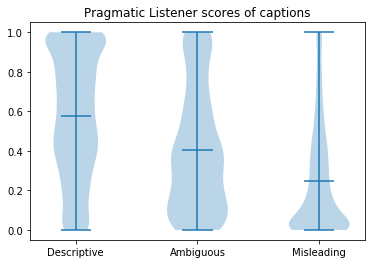

In [1181]:
# dataset sizes that don't make sense (with repeats tho!)
for metric in all_metrics:
    plot_score_dists([good_metrics_1234monroe_filtered, bad_metrics_comb1234_filtered,
                      ugly_metrics_1234monroe_filtered], metric)

(-0.1302061343895866, 8.48345597391422e-21)
SpearmanrResult(correlation=-0.1486845212662586, pvalue=1.0758661442003264e-26)
KendalltauResult(correlation=-0.12462594278502455, pvalue=1.9850644791841905e-27)


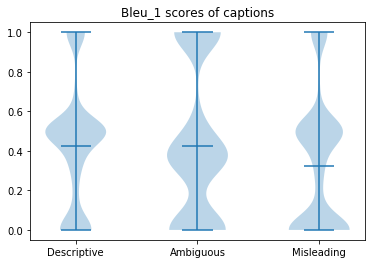

(-0.18336798476182087, 6.001781213675731e-40)
SpearmanrResult(correlation=-0.20104084181083093, pvalue=7.940381654857411e-48)
KendalltauResult(correlation=-0.16958234775847036, pvalue=2.893134825435826e-47)


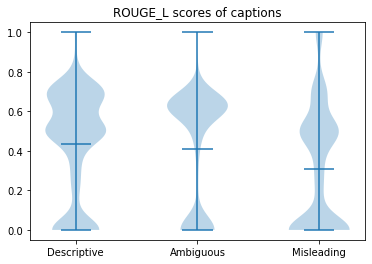

(-0.1280311152250231, 3.718816088960058e-20)
SpearmanrResult(correlation=-0.2222915456408967, pvalue=2.4572611652403586e-58)
KendalltauResult(correlation=-0.18504669410049102, pvalue=1.8626458572164308e-59)


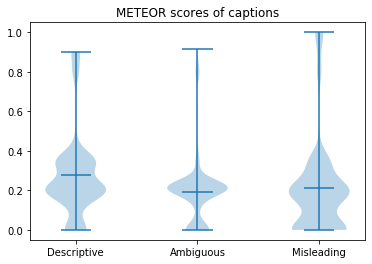

(-0.16078442186798633, 5.437082245246342e-31)
SpearmanrResult(correlation=-0.21389354780144287, pvalue=4.7928763833709894e-54)
KendalltauResult(correlation=-0.1639813855188099, pvalue=1.8076444878409557e-48)


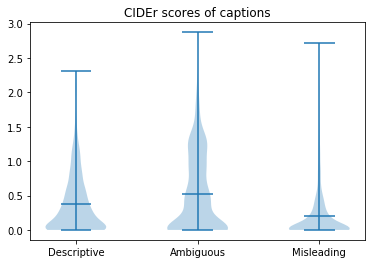

(-0.5534265315571435, 0.0)
SpearmanrResult(correlation=-0.5869390536015304, pvalue=0.0)
KendalltauResult(correlation=-0.463799505050465, pvalue=0.0)


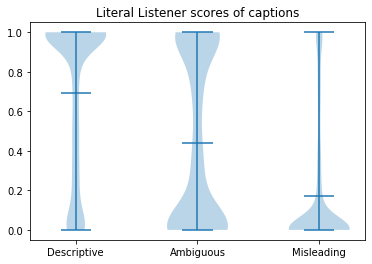

(-0.46213497230897493, 0.0)
SpearmanrResult(correlation=-0.46509240699594445, pvalue=0.0)
KendalltauResult(correlation=-0.36776395747495055, pvalue=0.0)


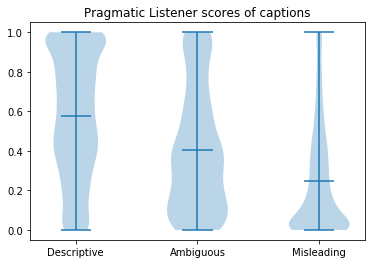

In [1140]:
for metric in all_metrics:
    plot_score_dists([good_metrics_1234monroe_filtered, bad_metrics_comb1234_filtered,
                      ugly_metrics_1234monroe_filtered], metric)

ok, that took a very long time, and we pretty much got the same result (it correlated a little worse), but now I have two sets of plots and regression values that I can use depending on what we decide.

Doing this exercise also made me realize how screwed my coding style is at the moment. I really have go through this notebook at some point and clean it up if I'm every going to have a chance of understanding what I did if I have to come back to it.

Also, another step I want to take--I want to filter out duplicate references in the no-monroe data. (Is this the right thing to do?)



In [ ]:
plot_data = [score[metric][1] for score in scores]
    
# let's also get the pearson correlation coefficient
# domain is [1, 1, 1, ...], [2, 2, 2, ...], [3, 3, 3, 3, ...]
# we could do fancy things with np.flatten(), but that doesn't work for lists with varying dimensions
# correlation_support = []
# for i, d in enumerate(plot_data):
#     correlation_support.extend([i+1] * len(d))

# plot_data_flat = []
# for d in plot_data:
#     plot_data_flat.extend(d)

# #     print()
# print(pearsonr(correlation_support, plot_data_flat))
# print(spearmanr(correlation_support, plot_data_flat))
# print(kendalltau(correlation_support, plot_data_flat))

plt.violinplot(plot_data, showmeans=True)
plt.xticks([1, 2, 3], ["Descriptive", "Ambiguous", "Misleading"])
# mean_cis = [mean_confidence_interval(data) for data in plot_data
# means, cis = zip(*mean_cis)
# plt.errorbar(range(1, 6), means, yerr=cis, capsize=9, color="white",
#              markeredgecolor="orange", ecolor="orange", zorder=-1,
#              elinewidth=5, capthick=1, barsabove=True)
plt.title("{} scores of captions".format(metric))

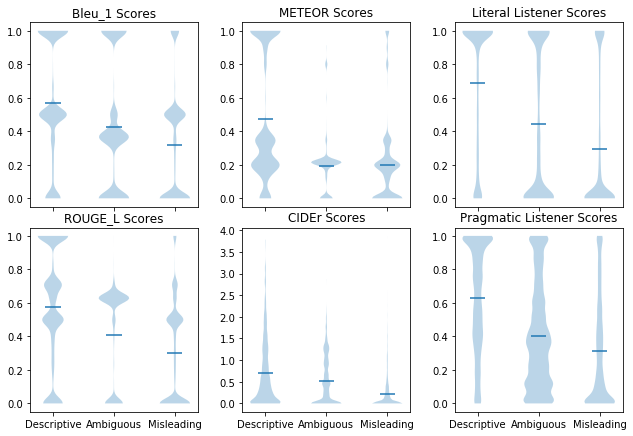

In [1462]:
# let's see if we can make a gridded plot
scores = [good_metrics_1234monroe_filtered, bad_metrics_comb1234_filtered,
                      ugly_metrics_1234monroe_filtered]
mc = 0
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(9, 6))
fig.tight_layout()
for i in range(3):
    for j in range(2):
        metric = all_metrics[mc]
        plot_data = [score[metric][1] for score in scores]
        axes[j, i].violinplot(plot_data, showmeans=True, bw_method=0.1, showextrema=False)
        axes[j, i].xaxis.set_ticks([1, 2, 3])
        axes[j, i].set_xticklabels(["Descriptive", "Ambiguous", "Misleading"])
        axes[j, i].set_title("{} Scores".format(metric))
        mc += 1

(array([ 821., 1012.,  110.,  180.,    2.,    6.,    0.,    0.,    0.,
          99.]),
 array([3.73879591e-06, 4.90741503e-02, 9.81445619e-02, 1.47214973e-01,
        1.96285385e-01, 2.45355797e-01, 2.94426208e-01, 3.43496620e-01,
        3.92567031e-01, 4.41637443e-01, 4.90707854e-01]),
 <a list of 10 Patch objects>)

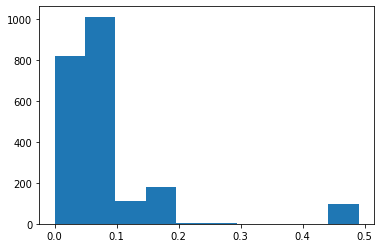

In [1471]:
plt.hist((scores[2]['ROUGE_L'][1] - scores[2]['ROUGE_L'][0])**2)

In [1344]:
import seaborn as sns

In [1349]:
import pandas as pd

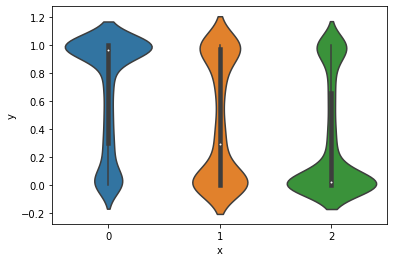

In [1352]:
x = ([0] * len(good_metrics_1234monroe_filtered['Literal Listener'][1].tolist()) +
     [1] * len(bad_metrics_comb1234_filtered['Literal Listener'][1].tolist()) +
     [2] * len(ugly_metrics_1234monroe_filtered['Literal Listener'][1].tolist()))
y = (good_metrics_1234monroe_filtered['Literal Listener'][1].tolist() +
    bad_metrics_comb1234_filtered['Literal Listener'][1].tolist() +
    ugly_metrics_1234monroe_filtered['Literal Listener'][1].tolist())
data = pd.DataFrame({'x':x, 'y':y})
sns.violinplot(x='x', y = 'y', data=data)

{'bodies': [<matplotlib.collections.PolyCollection at 0x1c52d6c390>,
  <matplotlib.collections.PolyCollection at 0x1c52d6c4e0>]}

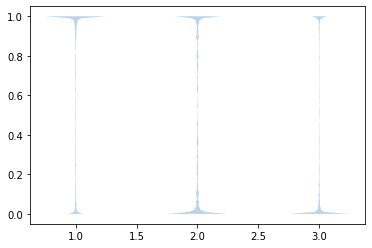

In [1472]:
plt.violinplot([good_metrics_1234monroe_filtered['Literal Listener'][1].tolist(),
                bad_metrics_comb1234_filtered['Literal Listener'][1].tolist(),
                ugly_metrics_1234monroe_filtered['Literal Listener'][1].tolist()], bw_method=0.01, showextrema=False)

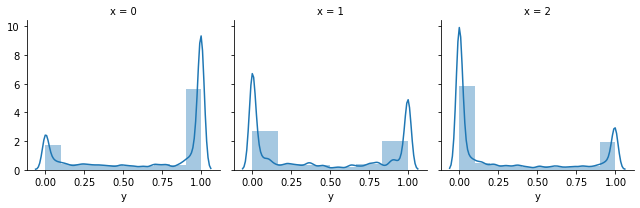

In [1354]:
g = sns.FacetGrid(data, col='x')
g.map(sns.distplot, 'y', kde_kws={'bw':0.02})

In [1346]:
[ 
    good_metrics_1234monroe_filtered['Literal Listener'][1],
    bad_metrics_comb1234_filtered['Literal Listener'][1],
    ugly_metrics_1234monroe_filtered['Literal Listener'][1]
]

[array([5.3459787e-01, 1.3704408e-05, 1.7506203e-05, ..., 9.9898201e-01,
        1.0000000e+00, 1.0000000e+00], dtype=float32),
 array([6.2159033e-06, 1.5823677e-02, 1.5823677e-02, ..., 8.5839337e-01,
        8.5839337e-01, 8.5839337e-01], dtype=float32),
 array([4.8316340e-04, 6.9390836e-08, 4.1813392e-02, ..., 1.5455210e-09,
        6.1560743e-09, 3.5426563e-16], dtype=float32)]

Let's run the William's test of dependent correlations
For this we need correlations between:
1. metric 1 and ground truth
2. metric 2 and ground truth
3. metric 1 and metric 2

We have the first two but we don't have part three for any metrics. Right now, I only care about our listener metric so I'll calculate that correlation

In [1357]:
def metric_correlation(scores, metric1, metric2):
    scores1 = [score_out[metric1][1] for score_out in scores]
    scores2 = [score_out[metric2][1] for score_out in scores]
    
    scores1_flat = []
    for scores in scores1:
        scores1_flat.extend(scores)
        
    scores2_flat = []
    for scores in scores2:
        scores2_flat.extend(scores)
        
    return scores1_flat, scores2_flat, pearsonr(scores1_flat, scores2_flat)


In [1361]:
s1, s2, res = metric_correlation([good_metrics_1234monroe_filtered, bad_metrics_comb1234_filtered,
                                  ugly_metrics_1234monroe_filtered], 'Literal Listener', 'Pragmatic Listener')

In [1362]:
res

(0.50540966, 0.0)

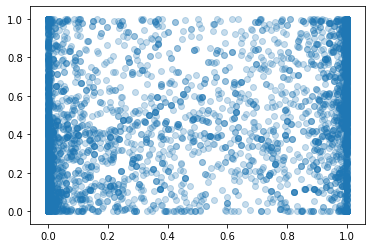

In [1365]:
plt.scatter(s1, s2, alpha=0.25)

(0.21926544810957838, 3.7988769346000046e-64)


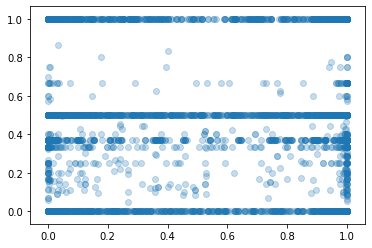

In [1367]:
s1, s2, res = metric_correlation([good_metrics_1234monroe_filtered, bad_metrics_comb1234_filtered,
                                  ugly_metrics_1234monroe_filtered], 'Literal Listener', 'Bleu_1')

print(res)
plt.scatter(s1, s2, alpha=0.25)

(0.27425484622702395, 1.0723605461113034e-100)


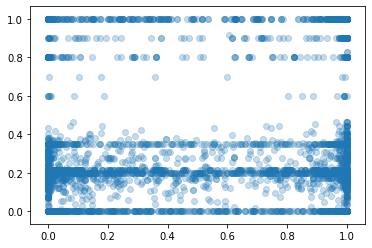

In [1370]:
s1, s2, res = metric_correlation([good_metrics_1234monroe_filtered, bad_metrics_comb1234_filtered,
                                  ugly_metrics_1234monroe_filtered], 'Literal Listener', 'METEOR')

print(res)
plt.scatter(s1, s2, alpha=0.25)

yikes, so it turns out I wasn't limiting the amount of data I was using for the literal listener cases. This is a bit of an issue because using repeated points increases the correlation... I also wasn't filtering out a few bad things... so yeah... now my metrics don't look all that much better correlation-wise. I'm curious about the human data I collected today though.

Ok, so that correlation was -0.5... and has like 510 contexts. Next, I want to find the correlation between the human data and the listener data:

In [ ]:
# read in human data - all unflipped
human_data = ...;


# filter out human data not in listener data (ambiguous in references, misleading in references in far condition)
ctx_good_unflipped_human = []
ctx_bad_unflipped_human = []
ctx_ugly_unflipped_human = []

ref_captions_good_unflipped_human = []
ref_captions_bad_unflipped_human = []
ref_captions_ugly_unflipped_human = []

scores_good_unflipped_human = []
scores_bad_unflipped_human = []
scores_ugly_unflipped_human = []

for i in range(len(human_data)):
    
    references = ref_captions_unflipped_1234monroe[i // 3]
    context = ...;
    
    if i % 3 == 1: # ambiguous
        if not human_data[i].caption in references:
            scores_bad_unflipped_human.append(human_data[i].score)
            ctx_bad_unflipped_human.append(ctx_bad_unflipped_comb1234[i // 3])
            ref_captions_bad_unflipped_human.append(references)
    elif i % 3 == 2: # misleading
        if not (context.condition == "far" and human_data[i].caption in references):
            scores_ugly_unflipped_human.append(human_data[i].score)
            ctx_ugly_unflipped_human.append(context)
            ref_captions_ugly_unflipped_human.append(references)
    else: # descriptive
        scores_good_unflipped_human.append(human_data[i].scores)
        ctx_good_unflipped_human.append(context)
        ref_captions_good_unflipped_human.append(references)
        
    

In [1372]:
ctx_bad_unflipped_human = []
ctx_good_unflipped_human = []
ctx_ugly_unflipped_human = []
for i, references in enumerate(ref_captions_unflipped_comb1234[::5]):
    # let's say we only care about the first one that works.

    for j in range(5): # number of references = 5
        if not normalize(ctx_bad_unflipped_comb1234[5*i + j].caption) in references:
            ctx_bad_unflipped_human.append(copy.deepcopy(ctx_bad_unflipped_comb1234[5*i + j]))
            ctx_good_unflipped_human.append(copy.deepcopy(ctx_good_unflipped_comb1234[5*i + j]))
            ctx_ugly_unflipped_human.append(copy.deepcopy(ctx_good_flipped_comb1234[5*i + j]))
            break

['brown', 'light brown', 'light brown', 'tan', 'light brown']
pale


In [1373]:
with open("../data/mturk/listener_pilot_scores.pkl", "rb") as pfile:
    good_unflipped_correct_human, bad_unflipped_correct_human, ugly_unflipped_correct_human = pkl.load(pfile)

In [1383]:
# filter out misleading the far conditions with identical captions to references:
ctx_ugly_unflipped_human_filtered = []
ugly_unflipped_correct_human_filtered = []
for i in range(len(ugly_unflipped_correct_human)):
    if not ctx_ugly_unflipped_human[i].caption in ref_captions_unflipped_comb1234[5*i]:
        ctx_ugly_unflipped_human_filtered.append(ctx_ugly_unflipped_human[i])
        ugly_unflipped_correct_human_filtered.append(ugly_unflipped_correct_human[i])


In [1384]:
len(ctx_ugly_unflipped_human_filtered)

163

In [1425]:
# it is probably going to be a little difficult to filter out the ones I need, so let's just re-run on the human
# contexts

# get listener scores - unflipped
good_unflipped_scores_human_ll = listener_assessment(ctx_good_unflipped_human)
bad_unflipped_scores_human_ll = listener_assessment(ctx_bad_unflipped_human)
ugly_unflipped_scores_human_ll = listener_assessment(ctx_ugly_unflipped_human_filtered)

# get speaker scores - unflipped
good_unflipped_scores_human_pl = speaker_assessment(ctx_good_unflipped_human)
bad_unflipped_scores_human_pl = speaker_assessment(ctx_bad_unflipped_human)
ugly_unflipped_scores_human_pl = speaker_assessment(ctx_ugly_unflipped_human_filtered)

In [1426]:
# misc reformating/cleaning up to match dimensions of human scores, etc.
good_unflipped_scores_human_ll = np.exp(good_unflipped_scores_human_ll)[:-5]
bad_unflipped_scores_human_ll = np.exp(bad_unflipped_scores_human_ll)[:-5]
 
good_unflipped_scores_human_pl = np.exp(good_unflipped_scores_human_pl)[:-5]
bad_unflipped_scores_human_pl = np.exp(bad_unflipped_scores_human_pl)[:-5]

ugly_unflipped_scores_human_ll = np.exp(ugly_unflipped_scores_human_ll)
ugly_unflipped_scores_human_pl = np.exp(ugly_unflipped_scores_human_pl)

In [1381]:
len(ugly_unflipped_scores_human)

163

In [1388]:
pearsonr(np.exp(good_unflipped_scores_human_ll), np.exp(good_unflipped_scores_human_pl))

(0.40549025, 2.59629754269838e-08)

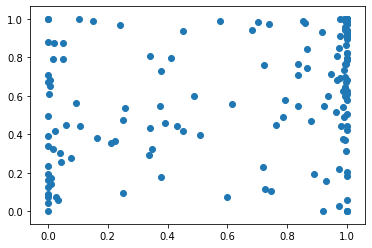

In [1387]:
plt.scatter(np.exp(good_unflipped_scores_human_ll), np.exp(good_unflipped_scores_human_pl))

In [1391]:
len(good_unflipped_correct_human)

170

(0.14033721181523934, 0.06795317022555204)


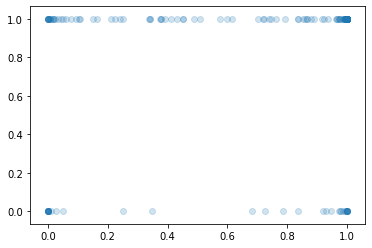

In [1397]:
print(pearsonr(np.exp(good_unflipped_scores_human_ll)[:-5], good_unflipped_correct_human))
plt.scatter(np.exp(good_unflipped_scores_human_ll)[:-5], good_unflipped_correct_human, alpha=0.2)

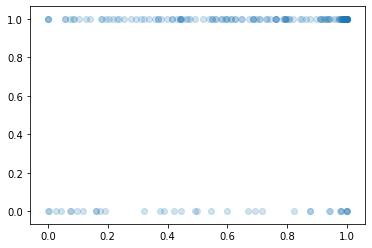

In [1395]:
plt.scatter(np.exp(good_unflipped_scores_human_pl)[:-5], good_unflipped_correct_human, alpha=0.2)

In [1407]:
sum((good_unflipped_correct_human - np.ones(170))**2)/170

0.21176470588235294

In [1408]:
sum((np.exp(good_unflipped_scores_human_pl)[:-5] - np.ones(170))**2)/170

0.23609943797374505

In [1409]:
sum((np.exp(good_unflipped_scores_human_ll)[:-5] - np.ones(170))**2)/170

0.2665276236417783

In [1427]:
all_human_scores = np.concatenate((good_unflipped_correct_human, bad_unflipped_correct_human, ugly_unflipped_correct_human_filtered))

all_human_scores_ll = np.concatenate((good_unflipped_scores_human_ll, bad_unflipped_scores_human_ll, ugly_unflipped_scores_human_ll))
all_human_scores_pl = np.concatenate((good_unflipped_scores_human_pl, bad_unflipped_scores_human_pl, ugly_unflipped_scores_human_pl))

In [1434]:
correlation_support = np.array([1]*len(good_unflipped_correct_human) + [2]*len(bad_unflipped_correct_human) + [3]*len(ugly_unflipped_correct_human_filtered))

In [1435]:
len(correlation_support)

503

In [1433]:
len(all_human_scores)

503

In [1429]:
good_unflipped_scores_human_ll

array([1.3704408e-05, 5.9822392e-01, 1.0000000e+00, 9.7681266e-01,
       1.0000000e+00, 9.9969798e-01, 2.5062340e-01, 1.8163385e-02,
       4.3007496e-01, 1.2866516e-03, 9.9906582e-01, 4.5180756e-01,
       3.3862147e-01, 9.9999857e-01, 9.9404681e-01, 1.0000000e+00,
       9.9986458e-01, 3.4849396e-01, 9.2883432e-01, 8.5231376e-01,
       6.0031930e-04, 9.1829067e-01, 1.0000000e+00, 4.8605073e-02,
       2.7095452e-03, 9.9999571e-01, 9.9774474e-01, 2.4191774e-02,
       1.0000000e+00, 1.1434590e-02, 9.9722320e-01, 9.9999988e-01,
       7.9140657e-01, 9.2283362e-01, 3.7839052e-01, 3.9266863e-01,
       9.6508843e-01, 1.0000000e+00, 1.6988330e-02, 4.5299122e-01,
       1.0000000e+00, 4.5055307e-02, 9.9175251e-01, 1.0000000e+00,
       1.4516960e-05, 7.2734690e-01, 1.0000000e+00, 3.7135815e-05,
       9.9436682e-01, 1.6039910e-06, 2.2301230e-01, 8.5890269e-01,
       1.0000000e+00, 1.2459414e-04, 9.8955071e-01, 7.0101833e-01,
       3.4280553e-01, 9.9779373e-01, 9.9997044e-01, 5.0222985e

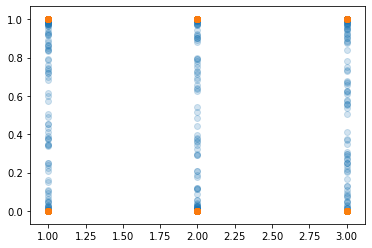

In [1437]:
plt.scatter(correlation_support, all_human_scores_ll, alpha=0.2)
plt.scatter(correlation_support, all_human_scores, alpha=0.2)

In [1734]:
# Ok, now let's actually do the William's test for real:
# to do this, we need pairwise correlations:
scores

[{'Bleu_1': (0.4721877648515045,
   array([1.        , 0.5       , 1.        , ..., 0.36787944, 0.5       ,
          1.        ])),
  'ROUGE_L': (0.570523665435433,
   array([1.        , 0.5       , 1.        , ..., 0.62886598, 0.70930233,
          1.        ])),
  'METEOR': (0.29194789624313766,
   array([1.        , 0.8       , 1.        , ..., 0.21621622, 0.34782609,
          1.        ])),
  'CIDEr': (0.7615978135699071,
   array([1.57764349, 0.67815927, 1.57764349, ..., 1.1120526 , 0.53453821,
          1.75954179])),
  'Literal Listener': (0.74427545,
   array([5.3459787e-01, 1.7506203e-05, 5.3459787e-01, ..., 9.9898201e-01,
          1.0000000e+00, 1.0000000e+00], dtype=float32)),
  'Pragmatic Listener': (0.6683175,
   array([0.77766263, 0.5587215 , 0.77766263, ..., 0.42321044, 0.94112486,
          0.9470826 ], dtype=float32))},
 {'Bleu_1': (0.4398072863005818,
   array([3.6787944e-16, 3.6787944e-01, 3.6787944e-01, ..., 3.6787944e-01,
          3.6787944e-01, 3.6787944e-01])

In [1742]:
all_metrics.append('Human Listener')

In [1748]:
pairwise_corrs = {}
for i, metric_1 in enumerate(all_metrics):
    metric_1_scores = []
    for score in scores:
        metric_1_scores.extend(score[metric_1][1])# for score in scores]
    
    for metric_2 in all_metrics[i+1:]:
        metric_2_scores = []
        for score in scores:
            metric_2_scores.extend(score[metric_2][1])
        # [scores[metric_2][1] for score in scores]
        
        pairwise_corrs[(metric_1, metric_2)] = pearsonr(metric_1_scores, metric_2_scores)
        

In [1749]:
pairwise_corrs

{('Bleu_1', 'ROUGE_L'): (0.8858714964430883, 0.0),
 ('Bleu_1', 'METEOR'): (0.6938764912178449, 0.0),
 ('Bleu_1', 'CIDEr'): (0.6185623748809085, 0.0),
 ('Bleu_1', 'Literal Listener'): (0.32421090765241545,
  1.1169950857102509e-126),
 ('Bleu_1', 'Pragmatic Listener'): (0.33773509919301314,
  5.760837793329827e-138),
 ('Bleu_1', 'Human Listener'): (0.3169108628745788, 8.034428555675119e-121),
 ('ROUGE_L', 'METEOR'): (0.7787928155783429, 0.0),
 ('ROUGE_L', 'CIDEr'): (0.7508824178086836, 0.0),
 ('ROUGE_L', 'Literal Listener'): (0.3991788751936565, 7.657322055673009e-197),
 ('ROUGE_L', 'Pragmatic Listener'): (0.42390161906292195,
  2.4635757681365834e-224),
 ('ROUGE_L', 'Human Listener'): (0.37026352122454453, 1.5734002742455375e-167),
 ('METEOR', 'CIDEr'): (0.7120667767795656, 0.0),
 ('METEOR', 'Literal Listener'): (0.39322164640370044,
  1.4696686135018682e-190),
 ('METEOR', 'Pragmatic Listener'): (0.41240830595519407,
  2.8937401463520273e-211),
 ('METEOR', 'Human Listener'): (0.41931120

In [1750]:
# let's get actual correlations for review
actual_corrs = {}
for metric in all_metrics:
    corr_support = []
    metric_scores = []
    for i, score in enumerate(scores):
        corr_support.extend([i] * len(score[metric][1]))

        metric_scores.extend(score[metric][1])

    print(len(corr_support))        
    actual_corrs[metric] = pearsonr(corr_support, metric_scores)
        


5164
5164
5164
5164
5164
5164
5164


In [1751]:
actual_corrs

{'Bleu_1': (-0.3628210988999968, 1.8645390253470985e-160),
 'ROUGE_L': (-0.44143892628500003, 2.7720016032077667e-245),
 'METEOR': (-0.4822202280917689, 4.968323145062158e-299),
 'CIDEr': (-0.4013334995783916, 3.7980786517678185e-199),
 'Literal Listener': (-0.5805550653443624, 0.0),
 'Pragmatic Listener': (-0.5083332701261113, 0.0),
 'Human Listener': (-0.860545677029805, 0.0)}

In [1727]:
actual_corrs['Human Listener'] = (-0.701496949195766, 0.0)

In [1753]:
r_test_inputs = {}
for i, metric_1 in enumerate(all_metrics):
    for metric_2 in (all_metrics)[i+1:]:
        rstr = "r.test(n=5164, "
        rstr += "r12={}, ".format(-actual_corrs[metric_1][0])
        rstr += "r13={}, ".format(-actual_corrs[metric_2][0])
        rstr += "r23={})".format(pairwise_corrs[(metric_1, metric_2)][0])
        r_test_inputs[(metric_1, metric_2)] = (rstr)

In [1754]:
r_test_inputs

{('Bleu_1',
  'ROUGE_L'): 'r.test(n=5164, r12=0.3628210988999968, r13=0.44143892628500003, r23=0.8858714964430883)',
 ('Bleu_1',
  'METEOR'): 'r.test(n=5164, r12=0.3628210988999968, r13=0.4822202280917689, r23=0.6938764912178449)',
 ('Bleu_1',
  'CIDEr'): 'r.test(n=5164, r12=0.3628210988999968, r13=0.4013334995783916, r23=0.6185623748809085)',
 ('Bleu_1',
  'Literal Listener'): 'r.test(n=5164, r12=0.3628210988999968, r13=0.5805550653443624, r23=0.32421090765241545)',
 ('Bleu_1',
  'Pragmatic Listener'): 'r.test(n=5164, r12=0.3628210988999968, r13=0.5083332701261113, r23=0.33773509919301314)',
 ('Bleu_1',
  'Human Listener'): 'r.test(n=5164, r12=0.3628210988999968, r13=0.860545677029805, r23=0.3169108628745788)',
 ('ROUGE_L',
  'METEOR'): 'r.test(n=5164, r12=0.44143892628500003, r13=0.4822202280917689, r23=0.7787928155783429)',
 ('ROUGE_L',
  'CIDEr'): 'r.test(n=5164, r12=0.44143892628500003, r13=0.4013334995783916, r23=0.7508824178086836)',
 ('ROUGE_L',
  'Literal Listener'): 'r.test(n

In [1488]:
# Now we're ready to run these in R I suppose... I'll do that now
r_test_results = {}
r_test_results[('Bleu_1', 'ROUGE_L')] = "t value -13.2    with probability < 3.7e-39"
r_test_results[('Bleu_1', 'METEOR')] = "t value -12.49    with probability < 2.9e-35"
r_test_results[('Bleu_1', 'CIDEr')] = "t value -3.49    with probability < 0.00049"
r_test_results[('Bleu_1', 'Literal Listener')] = "t value -16.47    with probability < 1.9e-59"
r_test_results[('Bleu_1', 'Pragmatic Listener')] = "t value -10.62    with probability < 4.4e-26"
r_test_results[('Bleu_1', 'Human Listener')] = "t value -54.36    with probability < 0"

r_test_results[('ROUGE_L', 'METEOR')] = "t value -5.05    with probability < 4.5e-07"
r_test_results[('ROUGE_L', 'CIDEr')] = "t value 4.57    with probability < 4.9e-06"
r_test_results[('ROUGE_L', 'Literal Listener')] = "t value -11.36    with probability < 1.5e-29"
r_test_results[('ROUGE_L', 'Pragmatic Listener')] = "t value -5.33    with probability < 1e-07"
r_test_results[('ROUGE_L', 'Human Listener')] = "t value -48.72    with probability < 0"

r_test_results[('METEOR', 'CIDEr')] = "t value 8.75    with probability < 2.8e-18"
r_test_results[('METEOR', 'Literal Listener')] = "t value -8.12    with probability < 5.9e-16"
r_test_results[('METEOR', 'Pragmatic Listener')] = "t value -2.1    with probability < 0.036"
r_test_results[('METEOR', 'Human Listener')] = "t value -46.43    with probability < 0"

r_test_results[('CIDEr', 'Literal Listener')] = "t value -13.7    with probability < 5.3e-42"
r_test_results[('CIDEr', 'Pragmatic Listener')] = "t value -8.1    with probability < 6.9e-16"
r_test_results[('CIDEr', 'Human Listener')] = "t value -51.82    with probability < 0"

r_test_results[('Literal Listener', 'Pragmatic Listener')] = "t value 8.15    with probability < 4.6e-16"
r_test_results[('Literal Listener', 'Human Listener')] = "t value -38.71    with probability < 4.9e-288"

r_test_results[('Pragmatic Listener', 'Human Listener')] = "t value -44.59    with probability < 0"

8/6/2019
Ok, I've run all the tests, but I'm likely going to have to re-run them. Now I'm going to incorporate both
~human data~ and the human-listener filtered captions into the metrics. Basically, I showed each of the captions to 3 human listeners and recorded whether or not 2/3 of them agreed. I'm currently running the experiments with the 
ambiguous captions so I don't have that data yet, but I can make plots using the data I do have now:


In [132]:
# Now with ALL the data - hf = human filtered
mturk_data_combined_1234_hf = MonroeData("../data/csv/mturk_augmented_data_exp1234_filtered.csv", single_speaker=False)

In [133]:
for _ in mturk_data_combined_1234_hf.read_data(): pass

In [135]:
# read in data
# for i in mturk_data_combined_1234_hf.read_data(): pass

# get the contexts
ctx_good_unflipped_comb1234_hf, ctx_bad_unflipped_comb1234_hf, ctx_good_flipped_comb1234_hf, ctx_bad_flipped_comb1234_hf = (
    extract_context_lists(mturk_data_combined_1234_hf)
)

In [108]:
def human_filter_ctx(ctx_list):
    return [ctx for ctx in ctx_list if ctx.outcome]

In [111]:
# combine with monroe et al data
# for word overlap metrics, we have to update the reference captions and add more good / ugly captions
#ref_captions_unflipped_1234monroe_hf = []
def combine_ours_monroe(ctx_ours, ctx_monroe):
    
    ctx_grouped = []

    for i, dev_idx in enumerate(dev_data_indices[:len(mturk_data_combined_1234_hf)//20]): # explaination of 20 above
        # access i's references in the newly collected data, don't worry about filtering because all of the good
        # samples are there. We can just append to reference captions and then do the filtering again I guess

        # at the beginning, before filtering, ref captions has 5 repeated captions
        reference_ctxs = (copy.deepcopy(ctx_ours[5*i: 5*i + 5]) +
                            [copy.deepcopy(dev_data[ci]) for ci in ctx_monroe[dev_idx]])
        ctx_grouped.append(reference_ctxs)
        
    return ctx_grouped

In [204]:
# unflipped - good
ctx_good_unflipped_1234monroe_hf = (
    combine_ours_monroe(ctx_good_unflipped_comb1234_hf, ctx_good_unflipped_monroe)
)

In [208]:
sum([len(x) for x in ctx_good_unflipped_1234monroe_hf])

1144

In [137]:
# flipped - good
ctx_good_flipped_1234monroe_hf = (
    combine_ours_monroe(ctx_good_flipped_comb1234_hf, ctx_good_flipped_monroe)
)

In [138]:
ctx_bad_unflipped_comb1234_hf = np.array(ctx_bad_unflipped_comb1234_hf).reshape(-1, 5).tolist()
ctx_bad_flipped_comb1234_hf = np.array(ctx_bad_flipped_comb1234_hf).reshape(-1, 5).tolist()

In [139]:
def good_to_ugly(good_ctx_caption, good_ctx_color):
    """Convert the good contexts to an ugly one using one for the caption and one for the colors"""
    ugly_ctx = copy.deepcopy(good_ctx_caption)
    
#     contexts_ugly_unflipped = copy.deepcopy(contexts_good_flipped)
#     for i, context in enumerate(contexts_good_unflipped):
#         contexts_ugly_unflipped[i].colors = context.colors

    for i in range(len(ugly_ctx)):
        for j in range(len(ugly_ctx[i])):
            ugly_ctx[i][j].colors = copy.copy(good_ctx_color[i][0].colors)
            
    return ugly_ctx

ctx_ugly_unflipped_1234monroe_hf = good_to_ugly(ctx_good_flipped_1234monroe_hf, ctx_good_unflipped_1234monroe_hf)
ctx_ugly_flipped_1234monroe_hf = good_to_ugly(ctx_good_unflipped_1234monroe_hf, ctx_good_flipped_1234monroe_hf)


In [116]:
def good_ctx_filter(contexts):
    filtered_ctxs = []
    for same_ctx in contexts:
        filtered_ctx = human_filter_ctx(same_ctx)
        filtered_ctxs.append(filtered_ctx)
    return filtered_ctxs

def bad_ctx_filter(contexts, refs):
    assert len(contexts) == len(refs)
    filtered_ctxs = []
    for i, same_ctx in enumerate(contexts):
        ref_caps = [normalize(ctx.caption) for ctx in refs[i]]
        filtered_same_ctx = human_filter_ctx(same_ctx)
        filtered_same_ctx = [ctx for ctx in filtered_same_ctx if normalize(ctx.caption) not in ref_caps]
        filtered_ctxs.append(filtered_same_ctx)
    return filtered_ctxs

def ugly_ctx_filter(contexts, refs):
    """Remove if they were not marked as correct by listeners and if the caption
       is in the references and the condition is far"""
    assert len(contexts) == len(refs)
    filtered_ctxs = []
    for i, same_ctx in enumerate(contexts):
        ref_caps = [normalize(ctx.caption) for ctx in refs[i]]
        filtered_same_ctx = human_filter_ctx(same_ctx)
        filtered_same_ctx_2 = []
        for ctx in filtered_same_ctx:
            if normalize(ctx.caption) in ref_caps and ctx.condition == "far":
                continue
            else:
                filtered_same_ctx_2.append(ctx)
        
        filtered_ctxs.append(filtered_same_ctx_2)
    return filtered_ctxs

In [140]:
# filter good
ctx_good_unflipped_1234monroe_hf = good_ctx_filter(ctx_good_unflipped_1234monroe_hf)
ctx_good_flipped_1234monroe_hf = good_ctx_filter(ctx_good_flipped_1234monroe_hf)


# filter bad
ctx_bad_unflipped_comb1234_hf = bad_ctx_filter(ctx_bad_unflipped_comb1234_hf, refs=ctx_good_unflipped_1234monroe_hf)
ctx_bad_flipped_comb1234_hf = bad_ctx_filter(ctx_bad_flipped_comb1234_hf, refs=ctx_good_flipped_1234monroe_hf)


# filter ugly
ctx_ugly_unflipped_1234monroe_hf = ugly_ctx_filter(ctx_ugly_unflipped_1234monroe_hf, refs=ctx_good_unflipped_1234monroe_hf)
ctx_ugly_flipped_1234monroe_hf = ugly_ctx_filter(ctx_ugly_flipped_1234monroe_hf, refs=ctx_good_flipped_1234monroe_hf)



In [142]:
sum(len(x) for x in ctx_bad_unflipped_comb1234_hf) # 684

684

In [143]:
sum(len(x) for x in ctx_bad_flipped_comb1234_hf) #659

659

In [144]:
def extract_refs_cands_good(ctxs):
    """Extract the captions and references for descriptive contexts"""
    good_captions = []
    good_refs = []
    for ctx in ctxs:
        ref = [normalize(c.caption) for c in ctx]
        if len(ref) == 1:
            ref = ref + ref # if there's only one caption, let it be its own reference
        for i in range(len(ctx)):
            good_captions.append(ref[i])
            good_refs.append(ref[:i] + ref[i+1:])
    return good_refs, good_captions
            
def extract_refs_cands(ctxs, ref_ctxs):
    """Extract the captions and references for ambiguous/misleading contexts"""
    captions = []
    refs = []
    for i, ctx in enumerate(ctxs):
        ref = [normalize(c.caption) for c in ref_ctxs[i]]
        for j in range(len(ctx)):
            refs.append(ref)
            captions.append(normalize(ctx[j].caption))
            
    return refs, captions

In [145]:
# ngrams require captions and references, so let's do those:
good_refs_unflipped_1234monroe_hf, good_cands_unflipped_1234monroe_hf = extract_refs_cands_good(ctx_good_unflipped_1234monroe_hf)
good_refs_flipped_1234monroe_hf, good_cands_flipped_1234monroe_hf = extract_refs_cands_good(ctx_good_flipped_1234monroe_hf)

bad_refs_unflipped_1234monroe_hf, bad_cands_unflipped_1234monroe_hf = extract_refs_cands(ctx_bad_unflipped_comb1234_hf, ref_ctxs=ctx_good_unflipped_1234monroe_hf)
bad_refs_flipped_1234monroe_hf, bad_cands_flipped_1234monroe_hf = extract_refs_cands(ctx_bad_flipped_comb1234_hf, ref_ctxs=ctx_good_flipped_1234monroe_hf)

ugly_refs_unflipped_1234monroe_hf, ugly_cands_unflipped_1234monroe_hf = extract_refs_cands(ctx_ugly_unflipped_1234monroe_hf, ref_ctxs=ctx_good_unflipped_1234monroe_hf)
ugly_refs_flipped_1234monroe_hf, ugly_cands_flipped_1234monroe_hf = extract_refs_cands(ctx_ugly_flipped_1234monroe_hf, ref_ctxs=ctx_good_flipped_1234monroe_hf)

In [146]:
# now let's calculate n-gram overlap metrics
good_unflipped_metrics_1234monroe_hf = get_overlap_scores(good_refs_unflipped_1234monroe_hf, good_cands_unflipped_1234monroe_hf)
good_flipped_metrics_1234monroe_hf = get_overlap_scores(good_refs_flipped_1234monroe_hf, good_cands_flipped_1234monroe_hf)

bad_unflipped_metrics_1234monroe_hf = get_overlap_scores(bad_refs_unflipped_1234monroe_hf, bad_cands_unflipped_1234monroe_hf)
bad_flipped_metrics_1234monroe_hf = get_overlap_scores(bad_refs_flipped_1234monroe_hf, bad_cands_flipped_1234monroe_hf)

ugly_unflipped_metrics_1234monroe_hf = get_overlap_scores(ugly_refs_unflipped_1234monroe_hf, ugly_cands_unflipped_1234monroe_hf)
ugly_flipped_metrics_1234monroe_hf = get_overlap_scores(ugly_refs_flipped_1234monroe_hf, ugly_cands_flipped_1234monroe_hf)



In [174]:
np.sum([
    np.sum([len(x) for x in good_refs_unflipped_1234monroe_hf]),
    np.sum([len(x) for x in good_refs_flipped_1234monroe_hf]),
    np.sum([len(x) for x in bad_refs_unflipped_1234monroe_hf]),
    np.sum([len(x) for x in bad_refs_flipped_1234monroe_hf]),
    np.sum([len(x) for x in ugly_refs_unflipped_1234monroe_hf]),
    np.sum([len(x) for x in ugly_refs_flipped_1234monroe_hf])
])

26865

In [175]:
# macro average - 5.206897907707923
np.mean([
    np.mean([len(x) for x in good_refs_unflipped_1234monroe_hf + good_refs_flipped_1234monroe_hf]),
    np.mean([len(x) for x in bad_refs_unflipped_1234monroe_hf + bad_refs_flipped_1234monroe_hf]),
    np.mean([len(x) for x in ugly_refs_unflipped_1234monroe_hf + ugly_refs_flipped_1234monroe_hf])
])

5.206221668863967

In [176]:
# macro average - 5.206897907707923
np.mean([
    np.mean([len(x) for x in good_refs_unflipped_1234monroe_hf]),
    np.mean([len(x) for x in good_refs_flipped_1234monroe_hf]),
    np.mean([len(x) for x in bad_refs_unflipped_1234monroe_hf]),
    np.mean([len(x) for x in bad_refs_flipped_1234monroe_hf]),
    np.mean([len(x) for x in ugly_refs_unflipped_1234monroe_hf]),
    np.mean([len(x) for x in ugly_refs_flipped_1234monroe_hf])
])

5.206897907707923

In [173]:
np.mean([len(x) for x in good_refs_unflipped_1234monroe_hf])

4.787847579814624

In [148]:
np.mean([len(x) for x in good_refs_flipped_1234monroe_hf]) # 4.997874601487779

4.997874601487779

In [149]:
np.mean([len(x) for x in bad_refs_unflipped_1234monroe_hf]) # 5.292397660818714

5.292397660818714

In [1761]:
np.mean([len(x) for x in bad_refs_flipped_1234monroe_hf]) # 5.185128983308043

5.185128983308043

In [150]:
np.mean([len(x) for x in ugly_refs_unflipped_1234monroe_hf]) # 5.574014909478168

5.574014909478168

In [151]:
np.mean([len(x) for x in ugly_refs_flipped_1234monroe_hf]) # 5.4041237113402065

5.4041237113402065

In [163]:
Counter([len(x) for x in bad_refs_unflipped_1234monroe_hf])

Counter({6: 94, 5: 235, 7: 124, 3: 67, 8: 26, 4: 121, 10: 7, 1: 5, 9: 5})

In [172]:
bad_refs_unflipped_1234monroe_hf

[['bright pink',
  'light pink',
  'bright pink',
  'bright purple',
  'brightest color',
  'lightest shade'],
 ['bright pink',
  'light pink',
  'bright pink',
  'bright purple',
  'brightest color',
  'lightest shade'],
 ['bright pink',
  'light pink',
  'bright pink',
  'bright purple',
  'brightest color',
  'lightest shade'],
 ['bright pink',
  'light pink',
  'bright pink',
  'bright purple',
  'brightest color',
  'lightest shade'],
 ['dim gray',
  'neutral gray',
  'lighter gray',
  'grey. looks less purple than the other one.',
  'grey grey'],
 ['dim gray',
  'neutral gray',
  'lighter gray',
  'grey. looks less purple than the other one.',
  'grey grey'],
 ['dim gray',
  'neutral gray',
  'lighter gray',
  'grey. looks less purple than the other one.',
  'grey grey'],
 ['dim gray',
  'neutral gray',
  'lighter gray',
  'grey. looks less purple than the other one.',
  'grey grey'],
 ['dim gray',
  'neutral gray',
  'lighter gray',
  'grey. looks less purple than the other one.

In [171]:
[x.caption for x in flatten(ctx_bad_unflipped_comb1234_hf)]

['VIOLET',
 'Pink',
 'Pink',
 'purple',
 'dark grey',
 'GRAY',
 'Grey',
 'Grey',
 'grey',
 'YELLOW',
 'Dark color',
 'purple grey',
 'GRAY',
 'Grey',
 'Gray',
 'purple',
 'GREEN',
 'Green',
 'Green',
 'green',
 'pale',
 'Indigo',
 'deep blue',
 'dark blue',
 'sky blue',
 'Purple',
 'purple',
 'deep blue',
 'purple',
 'Purple',
 'bright green',
 'grey',
 'earth tone',
 'purple',
 'Gray',
 'grey',
 'grey',
 'gray',
 'bright purple',
 'Gray',
 'blue-ish',
 'light',
 'medium darkness',
 'green',
 'Green',
 'forest colored',
 'Green',
 'Greenish',
 'purplish',
 'dark water colored',
 'Dark color',
 'bright',
 'Bright',
 "it's not blue",
 'Not brown or black',
 'Hot',
 "It's darker than pink",
 'green',
 'Green',
 'it means go',
 'Green',
 'Green',
 'Midnight Blue',
 'dark',
 'cool color',
 'Blue.',
 'light green',
 'Forest Green',
 'green',
 'green',
 'Green.',
 'green',
 'Purple',
 'sort of purple',
 'Purple.',
 'brown',
 'Ocean Green',
 'dark',
 'cool color',
 'Green.',
 'light black',
 '

In [152]:
from itertools import chain

In [153]:
def flatten(ctxs):
    return list(chain.from_iterable(ctxs))

In [154]:
# we can also calculate our listener-based metrics
# now let's run our listener/speaker evaluations
# get listener scores - unflipped
good_unflipped_scores_1234monroe_hf = listener_assessment(flatten(ctx_good_unflipped_1234monroe_hf))
bad_unflipped_scores_1234monroe_hf = listener_assessment(flatten(ctx_bad_unflipped_comb1234_hf))
ugly_unflipped_scores_1234monroe_hf = listener_assessment(flatten(ctx_ugly_unflipped_1234monroe_hf))

# get speaker scores - unflipped
good_unflipped_scores_1234monroe_speaker_hf = speaker_assessment(flatten(ctx_good_unflipped_1234monroe_hf))
bad_unflipped_scores_1234monroe_speaker_hf = speaker_assessment(flatten(ctx_bad_unflipped_comb1234_hf))
ugly_unflipped_scores_1234monroe_speaker_hf = speaker_assessment(flatten(ctx_ugly_unflipped_1234monroe_hf))


# get listener scores - flipped
good_flipped_scores_1234monroe_hf = listener_assessment(flatten(ctx_good_flipped_1234monroe_hf))
bad_flipped_scores_1234monroe_hf = listener_assessment(flatten(ctx_bad_flipped_comb1234_hf))
ugly_flipped_scores_1234monroe_hf = listener_assessment(flatten(ctx_ugly_flipped_1234monroe_hf))

# get speaker scores - flipped
good_flipped_scores_1234monroe_speaker_hf = speaker_assessment(flatten(ctx_good_flipped_1234monroe_hf))
bad_flipped_scores_1234monroe_speaker_hf = speaker_assessment(flatten(ctx_bad_flipped_comb1234_hf))
ugly_flipped_scores_1234monroe_speaker_hf = speaker_assessment(flatten(ctx_ugly_flipped_1234monroe_hf))



In [201]:
mistakes = np.array(flatten(ctx_ugly_flipped_1234monroe_hf))[np.array([149, 150, 151, 152, 153, 154, 241, 242, 243, 244, 245, 246, 247,
        248])]

deep blue


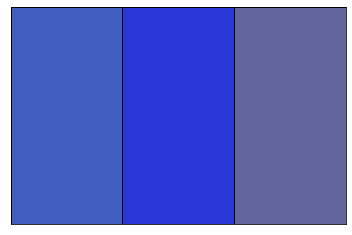

bluest blue


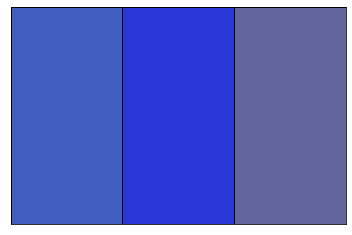

Dark blue.


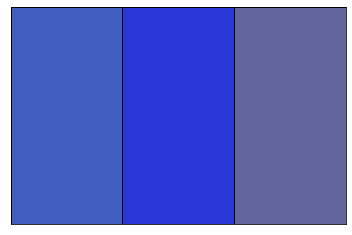

blue


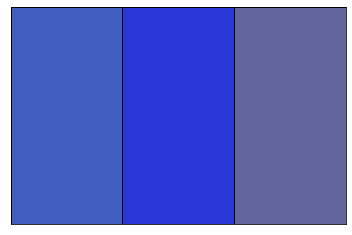

Darkest blue. ~ Yes.


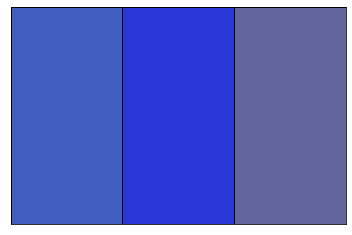

dark blue


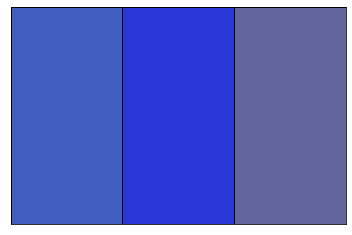

light green


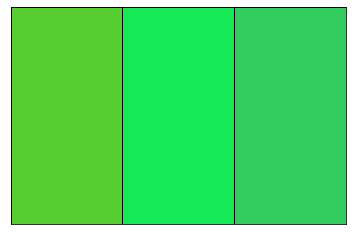

Bright lime green


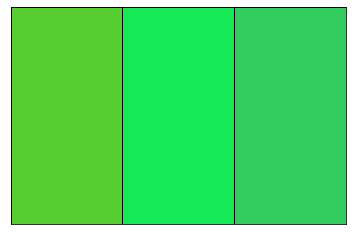

Neon Green


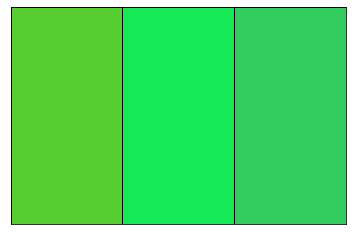

bright green


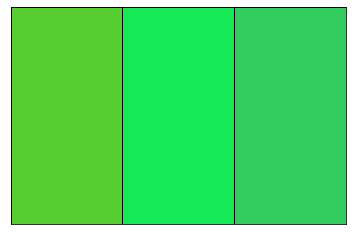

hello ~ are you ready ~ its is the lightes of the other 2 colors


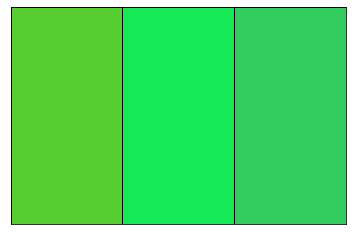

brightest light green


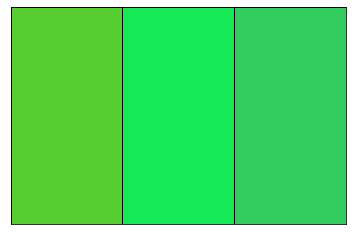

neon green


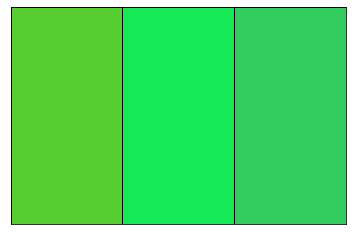

bluish green


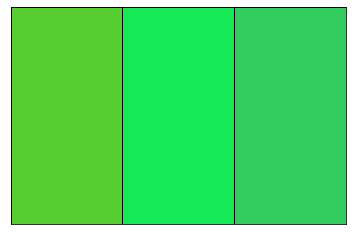

In [203]:
for i in range(len(mistakes)):
    train_data.display_custom_game(mistakes[i].colors, mistakes[i].caption)

bright pink


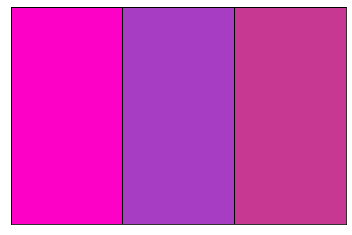

In [178]:
train_data.display_custom_game(ctx_good_unflipped_1234monroe_hf[0][0].colors, ctx_good_unflipped_1234monroe_hf[0][0].caption)

In [199]:
ugly_flipped_scores_1234monroe_speaker_hf

array([-3.65301466e+00, -2.19677496e+00, -3.65301466e+00, -1.13348579e+00,
       -3.13424301e+00, -2.04433250e+00, -4.00666428e+00,  0.00000000e+00,
       -6.60716057e-01, -7.24792480e-05, -2.29696131e+00, -1.06687889e+01,
       -6.22218847e+00, -6.01662970e+00, -8.00376987e+00, -6.91889191e+00,
       -3.94969940e+00, -6.01662970e+00, -1.58324471e+01, -8.50249481e+00,
       -2.59140396e+00, -2.18631172e+00, -5.52100515e+00, -4.40820217e-01,
       -3.50349903e-01, -4.40820217e-01, -4.40820217e-01, -5.85802794e-01,
       -4.40820217e-01, -2.83083200e+00, -1.24202204e+00, -1.24202204e+00,
       -2.70397282e+00, -1.24202204e+00, -2.83083200e+00, -2.83083200e+00,
       -2.66477966e+00, -5.16273308e+00, -3.12895966e+00, -5.41581421e+01,
       -1.64802933e+00, -2.55911064e+00, -3.15942001e+00, -9.30597305e-01,
       -2.27578497e+00, -2.49810123e+00, -9.30597305e-01, -1.51885605e+00,
       -1.74606514e+00, -9.75084019e+00, -9.75084019e+00, -9.75084019e+00,
       -6.05011463e+00, -

In [187]:
# unflipped
add_score_to_metric(good_unflipped_scores_1234monroe_hf, good_unflipped_metrics_1234monroe_hf, name="Literal Listener")
add_score_to_metric(bad_unflipped_scores_1234monroe_hf, bad_unflipped_metrics_1234monroe_hf, name="Literal Listener")
add_score_to_metric(ugly_unflipped_scores_1234monroe_hf, ugly_unflipped_metrics_1234monroe_hf, name="Literal Listener")

add_score_to_metric(good_unflipped_scores_1234monroe_speaker_hf, good_unflipped_metrics_1234monroe_hf, name="Pragmatic Listener")
add_score_to_metric(bad_unflipped_scores_1234monroe_speaker_hf, bad_unflipped_metrics_1234monroe_hf, name="Pragmatic Listener")
add_score_to_metric(ugly_unflipped_scores_1234monroe_speaker_hf, ugly_unflipped_metrics_1234monroe_hf, name="Pragmatic Listener")


# flipped
add_score_to_metric(good_flipped_scores_1234monroe_hf, good_flipped_metrics_1234monroe_hf, name="Literal Listener")
add_score_to_metric(bad_flipped_scores_1234monroe_hf, bad_flipped_metrics_1234monroe_hf, name="Literal Listener")
add_score_to_metric(ugly_flipped_scores_1234monroe_hf, ugly_flipped_metrics_1234monroe_hf, name="Literal Listener")

add_score_to_metric(good_flipped_scores_1234monroe_speaker_hf, good_flipped_metrics_1234monroe_hf, name="Pragmatic Listener")
add_score_to_metric(bad_flipped_scores_1234monroe_speaker_hf, bad_flipped_metrics_1234monroe_hf, name="Pragmatic Listener")
add_score_to_metric(ugly_flipped_scores_1234monroe_speaker_hf, ugly_flipped_metrics_1234monroe_hf, name="Pragmatic Listener")

In [188]:
# now let's combine the two:
all_metrics = ['Bleu_1', 'ROUGE_L', 'METEOR', 'CIDEr', 'Literal Listener', 'Pragmatic Listener']


good_metrics_1234monroe_hf = {}
bad_metrics_1234monroe_hf = {}
ugly_metrics_1234monroe_hf = {}

for metric in all_metrics:
    good_metrics_1234monroe_hf[metric] = (np.mean([good_unflipped_metrics_1234monroe_hf[metric][0], 
                                                       good_flipped_metrics_1234monroe_hf[metric][0]]),
            np.concatenate((good_unflipped_metrics_1234monroe_hf[metric][1], good_flipped_metrics_1234monroe_hf[metric][1])))
    bad_metrics_1234monroe_hf[metric] = (np.mean([bad_unflipped_metrics_1234monroe_hf[metric][0], 
                                                       bad_flipped_metrics_1234monroe_hf[metric][0]]),
            np.concatenate((bad_unflipped_metrics_1234monroe_hf[metric][1], bad_flipped_metrics_1234monroe_hf[metric][1])))
    ugly_metrics_1234monroe_hf[metric] = (np.mean([ugly_unflipped_metrics_1234monroe_hf[metric][0], 
                                                       ugly_flipped_metrics_1234monroe_hf[metric][0]]),
            np.concatenate((ugly_unflipped_metrics_1234monroe_hf[metric][1], ugly_flipped_metrics_1234monroe_hf[metric][1])))
                                              

In [157]:
len(bad_metrics_1234monroe_hf['ROUGE_L'][1])

1343

(-0.3628210988999968, 1.8645390253470985e-160)
SpearmanrResult(correlation=-0.3494045990442967, pvalue=3.582805276242994e-148)
KendalltauResult(correlation=-0.29031567148602705, pvalue=1.5732871070854286e-143)


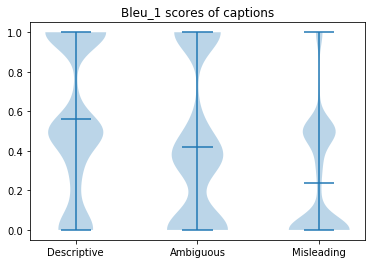

(-0.44143892628500003, 2.7720016032077667e-245)
SpearmanrResult(correlation=-0.43851287378081355, pvalue=1.0582869970875142e-241)
KendalltauResult(correlation=-0.3783911681463812, pvalue=8.209748712908123e-231)


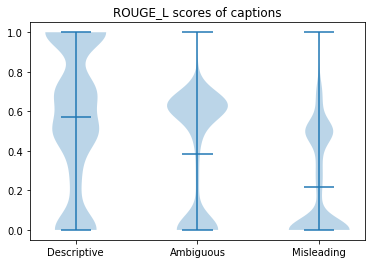

(-0.4822202280917689, 4.968323145062158e-299)
SpearmanrResult(correlation=-0.47927839309905035, pvalue=6.645360205288503e-295)
KendalltauResult(correlation=-0.4039142564215139, pvalue=1.529353521063455e-277)


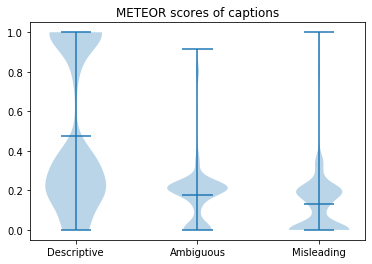

(-0.4013334995783916, 3.7980786517678185e-199)
SpearmanrResult(correlation=-0.41713295268009076, pvalue=1.41408252895847e-216)
KendalltauResult(correlation=-0.34045596856003096, pvalue=2.3339978390794206e-201)


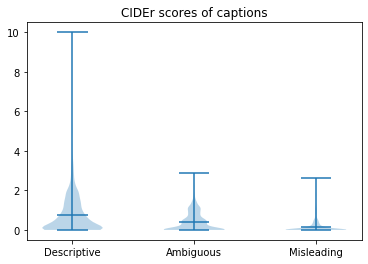

(-0.5805550643111788, 0.0)
SpearmanrResult(correlation=-0.6132094063932807, pvalue=0.0)
KendalltauResult(correlation=-0.48603090345746663, pvalue=0.0)


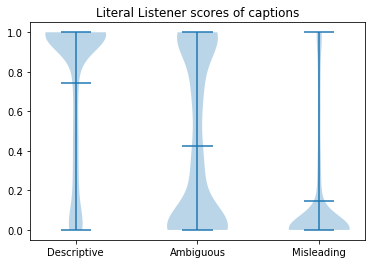

(-0.5540210102608568, 0.0)
SpearmanrResult(correlation=-0.5559565084796021, pvalue=0.0)
KendalltauResult(correlation=-0.44363929008368846, pvalue=0.0)


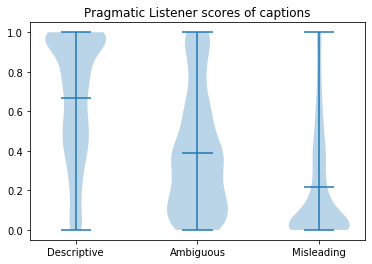

In [189]:
# Notebook Copy (8/24/2019)
for metric in all_metrics:
    plot_score_dists([good_metrics_1234monroe_hf, bad_metrics_1234monroe_hf,
                      ugly_metrics_1234monroe_hf], metric)

In [192]:
bad_metrics_1234monroe_hf['Pragmatic Listener'][0]

0.3882836

In [ ]:
good_metrics_1234monroe_hf

(-0.3628210988999968, 1.8645390253470985e-160)
SpearmanrResult(correlation=-0.3494045990442967, pvalue=3.582805276242994e-148)
KendalltauResult(correlation=-0.29031567148602705, pvalue=1.5732871070854286e-143)


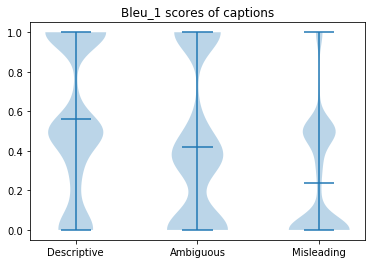

(-0.44143892628500003, 2.7720016032077667e-245)
SpearmanrResult(correlation=-0.43851287378081355, pvalue=1.0582869970875142e-241)
KendalltauResult(correlation=-0.3783911681463812, pvalue=8.209748712908123e-231)


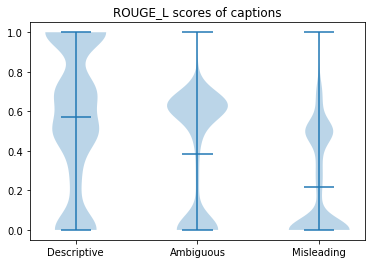

(-0.4822202280917689, 4.968323145062158e-299)
SpearmanrResult(correlation=-0.47927839309905035, pvalue=6.645360205288503e-295)
KendalltauResult(correlation=-0.4039142564215139, pvalue=1.529353521063455e-277)


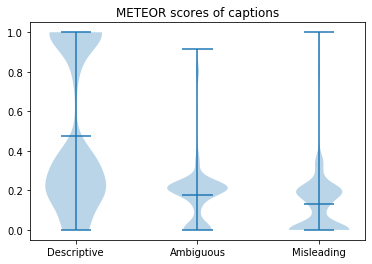

(-0.4013334995783916, 3.7980786517678185e-199)
SpearmanrResult(correlation=-0.41713295268009076, pvalue=1.41408252895847e-216)
KendalltauResult(correlation=-0.34045596856003096, pvalue=2.3339978390794206e-201)


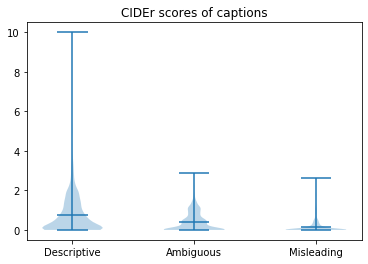

(-0.5805550643111788, 0.0)
SpearmanrResult(correlation=-0.6132094063932807, pvalue=0.0)
KendalltauResult(correlation=-0.48603090345746663, pvalue=0.0)


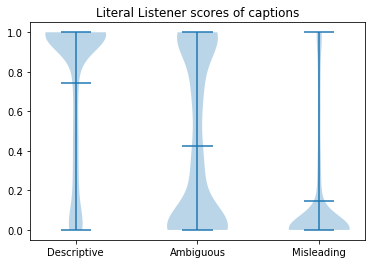

(-0.5083332701260093, 0.0)
SpearmanrResult(correlation=-0.4794254967052603, pvalue=4.141373078728203e-295)
KendalltauResult(correlation=-0.34997530427689105, pvalue=3.685075938912706e-233)


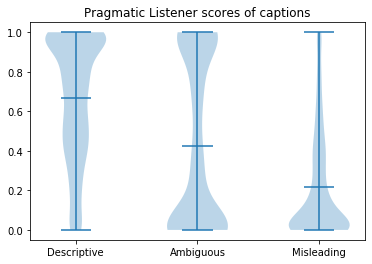

In [158]:
# Notebook Copy (8/23/2019)
for metric in all_metrics:
    plot_score_dists([good_metrics_1234monroe_hf, bad_metrics_1234monroe_hf,
                      ugly_metrics_1234monroe_hf], metric)

(-0.36164585476205363, 2.9874025769599395e-80)
SpearmanrResult(correlation=-0.3505771270218339, pvalue=3.337564953455422e-75)
KendalltauResult(correlation=-0.29099224215092573, pvalue=9.700766895361073e-73)


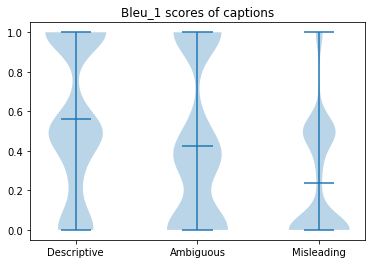

(-0.4429297335649784, 5.878994375026771e-124)
SpearmanrResult(correlation=-0.4375456144974789, pvalue=1.1314802439624984e-120)
KendalltauResult(correlation=-0.37673158280326174, pvalue=8.19860590150219e-115)


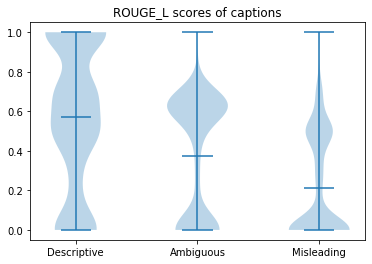

(-0.48677669900354303, 5.08322792780081e-153)
SpearmanrResult(correlation=-0.47558164843616446, pvalue=3.423774996266267e-145)
KendalltauResult(correlation=-0.40104374345158295, pvalue=6.885716933826048e-137)


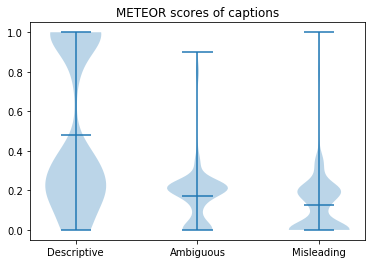

(-0.39532889925539183, 6.833509482700823e-97)
SpearmanrResult(correlation=-0.4151804295387838, pvalue=1.1927281101347139e-107)
KendalltauResult(correlation=-0.33896713151540814, pvalue=5.81992430166644e-100)


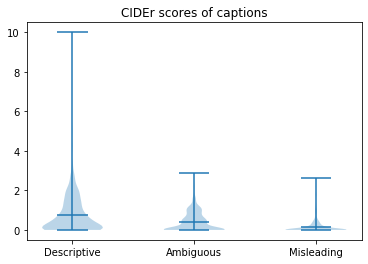

(-0.5886917004772078, 1.4217076760467285e-239)
SpearmanrResult(correlation=-0.6172955325577445, pvalue=7.73892893965266e-270)
KendalltauResult(correlation=-0.49005261968077823, pvalue=2.8290403228219808e-226)


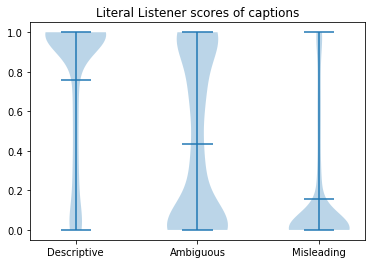

(-0.5106098856894766, 1.0898889021139502e-170)
SpearmanrResult(correlation=-0.481215066678645, pvalue=4.281863973053766e-149)
KendalltauResult(correlation=-0.3523936445117494, pvalue=1.4655345495317392e-118)


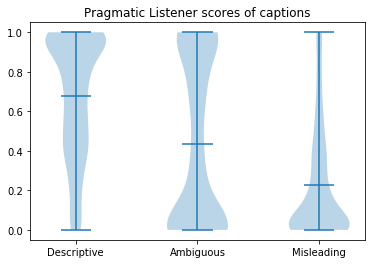

KeyError: 'Human Listener'

In [1802]:
for metric in all_metrics:
    plot_score_dists([good_flipped_metrics_1234monroe_hf, bad_flipped_metrics_1234monroe_hf,
                      ugly_flipped_metrics_1234monroe_hf], metric)

(-0.36410141161402104, 3.8433204939570624e-82)
SpearmanrResult(correlation=-0.34873261703688585, pvalue=4.649342766596868e-75)
KendalltauResult(correlation=-0.29011508173456346, pvalue=6.739756551422502e-73)


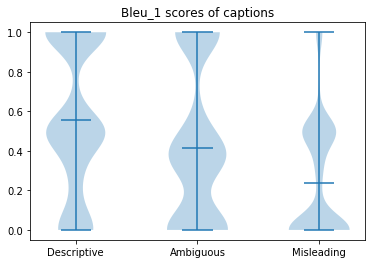

(-0.43969047258351485, 4.27295647315142e-123)
SpearmanrResult(correlation=-0.43915687332143266, pvalue=9.085824911961363e-123)
KendalltauResult(correlation=-0.37985152862725596, pvalue=7.487662410327772e-118)


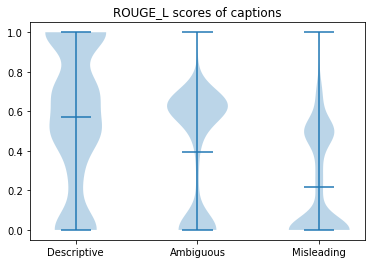

(-0.4775228258203879, 7.032220744834475e-148)
SpearmanrResult(correlation=-0.4832706187088812, pvalue=6.324466244709514e-152)
KendalltauResult(correlation=-0.4071305056755026, pvalue=6.633922024636385e-143)


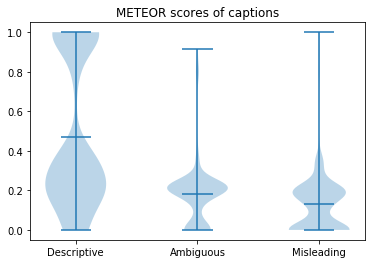

(-0.40773778516170395, 1.7630037250571927e-104)
SpearmanrResult(correlation=-0.4188817611171476, pvalue=9.578320953847733e-111)
KendalltauResult(correlation=-0.341846436268016, pvalue=2.927538453271148e-103)


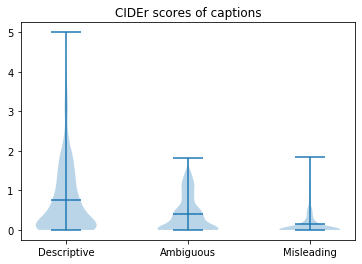

(-0.5732153055278603, 1.676997068519804e-226)
SpearmanrResult(correlation=-0.6104364175213615, pvalue=9.944550385030303e-265)
KendalltauResult(correlation=-0.48311779955049006, pvalue=3.105575814560672e-222)


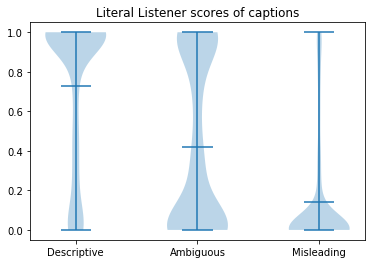

(-0.5066806880399272, 3.1579558899941426e-169)
SpearmanrResult(correlation=-0.47869756117797396, pvalue=1.0627445912367557e-148)
KendalltauResult(correlation=-0.34867073377355245, pvalue=3.072295743447148e-117)


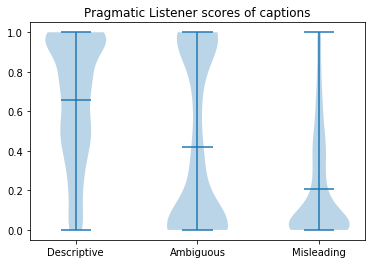

KeyError: 'Human Listener'

In [1801]:
for metric in all_metrics:
    plot_score_dists([good_unflipped_metrics_1234monroe_hf, bad_unflipped_metrics_1234monroe_hf,
                      ugly_unflipped_metrics_1234monroe_hf], metric)

(-0.3628210988999968, 1.8645390253470985e-160)
SpearmanrResult(correlation=-0.3494045990442967, pvalue=3.582805276242994e-148)
KendalltauResult(correlation=-0.29031567148602705, pvalue=1.5732871070854286e-143)


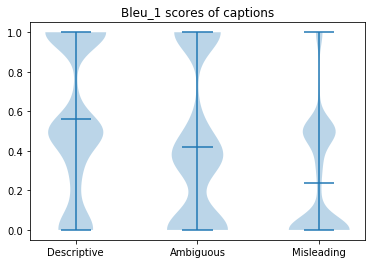

(-0.44143892628500003, 2.7720016032077667e-245)
SpearmanrResult(correlation=-0.43851287378081355, pvalue=1.0582869970875142e-241)
KendalltauResult(correlation=-0.3783911681463812, pvalue=8.209748712908123e-231)


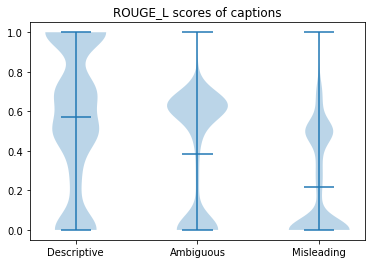

(-0.4822202280917689, 4.968323145062158e-299)
SpearmanrResult(correlation=-0.47927839309905035, pvalue=6.645360205288503e-295)
KendalltauResult(correlation=-0.4039142564215139, pvalue=1.529353521063455e-277)


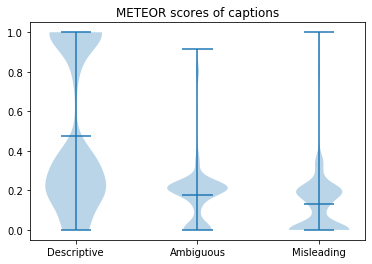

(-0.4013334995783916, 3.7980786517678185e-199)
SpearmanrResult(correlation=-0.41713295268009076, pvalue=1.41408252895847e-216)
KendalltauResult(correlation=-0.34045596856003096, pvalue=2.3339978390794206e-201)


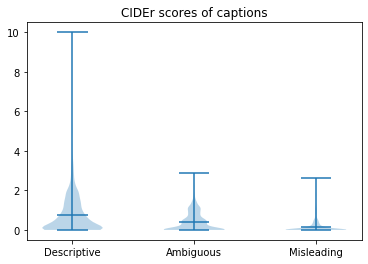

(-0.5805550653443624, 0.0)
SpearmanrResult(correlation=-0.6132059313075633, pvalue=0.0)
KendalltauResult(correlation=-0.48602820177410194, pvalue=0.0)


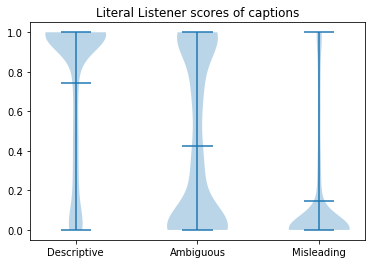

(-0.5083332701261113, 0.0)
SpearmanrResult(correlation=-0.479425496747038, pvalue=4.141372522397623e-295)
KendalltauResult(correlation=-0.349975330538028, pvalue=3.6850755765598072e-233)


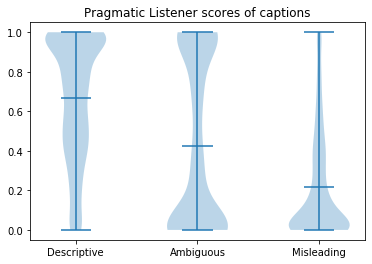

In [1717]:
# This is where the values in the paper come from
for metric in all_metrics:
    plot_score_dists([good_metrics_1234monroe_hf, bad_metrics_1234monroe_hf,
                      ugly_metrics_1234monroe_hf], metric)

(-0.3518406458154281, 3.754988315292313e-154)
SpearmanrResult(correlation=-0.34371107682360125, pvalue=9.541042317177591e-147)
KendalltauResult(correlation=-0.2849027272026993, pvalue=7.359626106780495e-142)


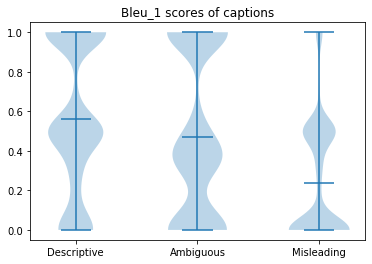

(-0.4248057209653761, 4.2835758459163674e-231)
SpearmanrResult(correlation=-0.4264312193622658, pvalue=4.870824523087804e-233)
KendalltauResult(correlation=-0.3645713833063183, pvalue=1.5674062025762644e-220)


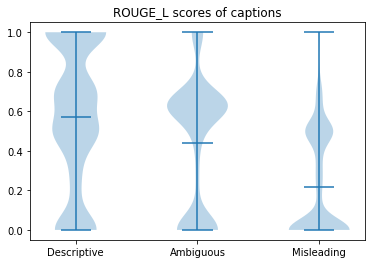

(-0.45102000397202324, 8.731885593848778e-264)
SpearmanrResult(correlation=-0.46604136880051666, pvalue=7.464715326909739e-284)
KendalltauResult(correlation=-0.38921667064540566, pvalue=1.0461146298210738e-264)


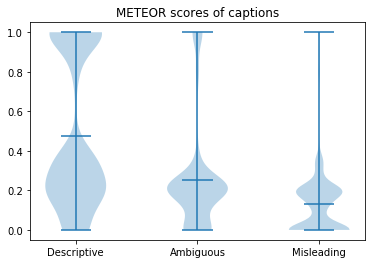

(-0.38889217852865093, 8.856711386759589e-191)
SpearmanrResult(correlation=-0.40826297889801894, pvalue=6.597441062016084e-212)
KendalltauResult(correlation=-0.3310655276333008, pvalue=2.2637663323904577e-196)


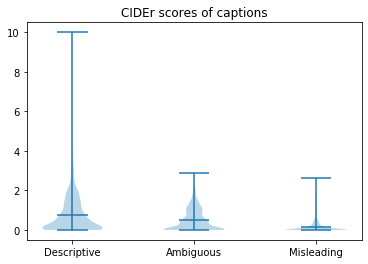

(-0.5715475583086687, 0.0)
SpearmanrResult(correlation=-0.6039352716134765, pvalue=0.0)
KendalltauResult(correlation=-0.4772735001617022, pvalue=0.0)


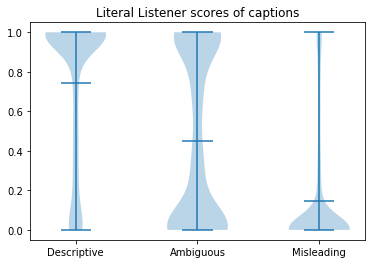

(-0.4977991491217279, 0.0)
SpearmanrResult(correlation=-0.46720918003436634, pvalue=1.863435540227591e-285)
KendalltauResult(correlation=-0.3385814173531904, pvalue=3.377556584434987e-224)


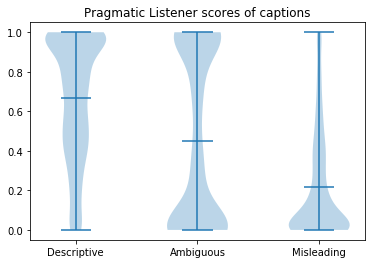

In [1669]:
for metric in all_metrics:
    plot_score_dists([good_metrics_1234monroe_hf, bad_metrics_1234monroe_hf,
                      ugly_metrics_1234monroe_hf], metric)

In [1746]:
# let's also add the human scores for yucks - the actual human scores are in the other notebook (because we
# have 3 ratings from each listener), but we need the dimensions to be the same to do a correlation, so we
# can just assume that all of the descriptive are correct and all of the misleading are incorrect:
good_metrics_1234monroe_hf['Human Listener'] = (1, np.ones(len(good_metrics_1234monroe_hf['ROUGE_L'][1])))
ugly_metrics_1234monroe_hf['Human Listener'] = (0, np.zeros(len(ugly_metrics_1234monroe_hf['ROUGE_L'][1])))

# for the ambiguous ones we have to balance it with the actual data a little more: 598 1's, 745 0's (from listener nb)
bad_metrics_1234monroe_hf['Human Listener'] = (598/(598+745), np.concatenate((np.zeros(745), np.ones(598))))

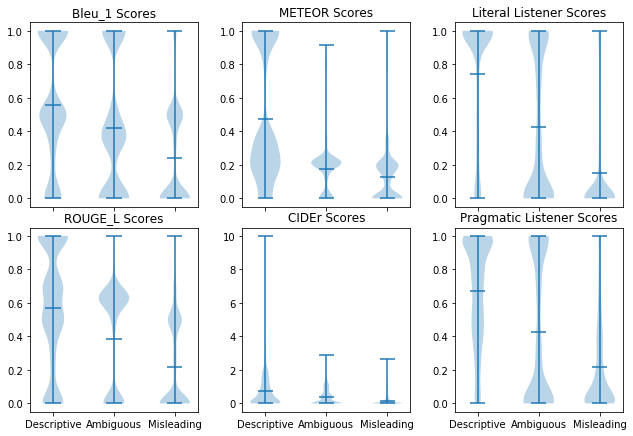

In [1747]:
# let's see if we can make a gridded plot
scores = [good_metrics_1234monroe_hf,
          bad_metrics_1234monroe_hf,
          ugly_metrics_1234monroe_hf]
mc = 0
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(9, 6))
fig.tight_layout()
for i in range(3):
    for j in range(2):
        metric = all_metrics[mc]
        plot_data = [score[metric][1] for score in scores]
        axes[j, i].violinplot(plot_data, showmeans=True, bw_method=0.2, showextrema=True)
        axes[j, i].xaxis.set_ticks([1, 2, 3])
        axes[j, i].set_xticklabels(["Descriptive", "Ambiguous", "Misleading"])
        axes[j, i].set_title("{} Scores".format(metric))
        mc += 1

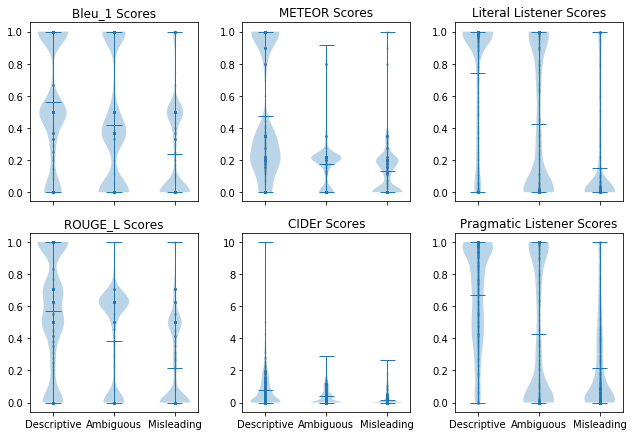

In [1799]:
# let's see if we can make a gridded plot
scores = [good_metrics_1234monroe_hf,
          bad_metrics_1234monroe_hf,
          ugly_metrics_1234monroe_hf]
mc = 0
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(9, 6))
fig.tight_layout()
fig.subplots_adjust(hspace=0.175)
for i in range(3):
    for j in range(2):
        metric = all_metrics[mc]
        plot_data = [score[metric][1] for score in scores]
        point_data = [np.repeat(i+1, len(s)) for i, s in enumerate(plot_data)]
        vpdata = axes[j, i].violinplot(plot_data, showmeans=True, bw_method=0.2, showextrema=True)
        vpdata["cbars"].set(linewidths=1)
        vpdata["cmeans"].set(linewidths=1)
        vpdata["cmins"].set(linewidths=1)
        vpdata["cmaxes"].set(linewidths=1)
        
        scatter_data_x = []
        scatter_data_y = []
        for k in range(3):
            scatter_data_x.extend(point_data[k])
            scatter_data_y.extend(plot_data[k])
        axes[j, i].scatter(scatter_data_x, scatter_data_y, alpha=0.01, s=5)
        axes[j, i].xaxis.set_ticks([1, 2, 3])
        axes[j, i].set_xticklabels(["Descriptive", "Ambiguous", "Misleading"])
        axes[j, i].set_title("{} Scores".format(metric))
        mc += 1

In [1769]:
np.repeat(1, 3)

array([1, 1, 1])

In [1723]:
len(bad_metrics_1234monroe_hf['Bleu_1'][1])

1343

In [1724]:
1343 + 1912 + 1909

5164

In [ ]:
# All that's left is the human data - which I have to finish checking over and also somehow import into here.
# I'll take the contexts where a majority of the people got them correct and plot all three of the human scores 
# could also plot average or max, idk - average sounds good.

